### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhoutee score


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-05-04 08:25:39,788 - AInewsbot - INFO - Initializing with before_date=2025-05-03 18:00, do_download=False, thread_id=b5bacb189e534f50ad0a16075027ac90
2025-05-04 08:25:39,890 - AInewsbot - INFO - thread_id: b5bacb189e534f50ad0a16075027ac90


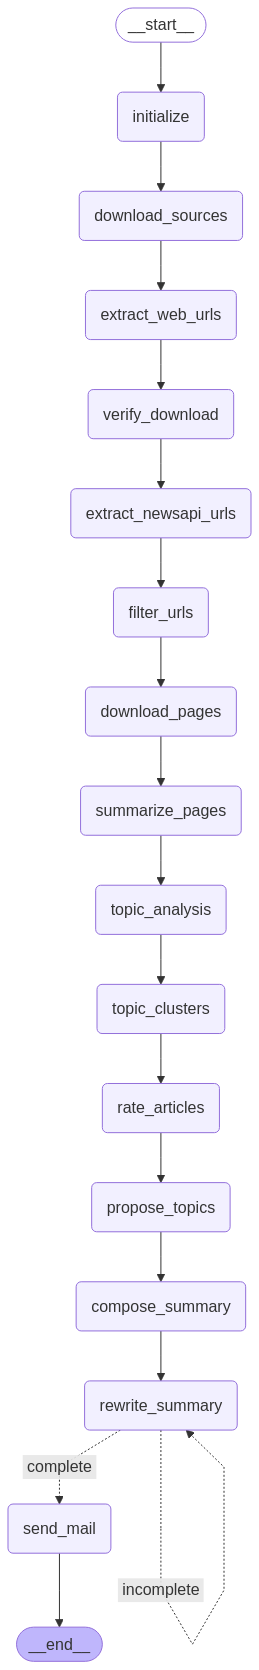

In [4]:
# before_date = None
before_date = '2025-05-03 18:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [5]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-05-04 08:25:41,981 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-04 08:25:41,981 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-04 08:25:41,981 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-04 08:25:41,981 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-04 08:25:41,982 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-04 08:25:41,982 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-04 08:25:41,982 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'
run exception
'src'


2025-05-04 08:25:42,042 - AInewsbot - INFO - parse_file - found 255 raw links
2025-05-04 08:25:42,045 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-05-04 08:25:42,045 - AInewsbot - INFO - 37 links found
2025-05-04 08:25:42,045 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-04 08:25:42,064 - AInewsbot - INFO - parse_file - found 211 raw links
2025-05-04 08:25:42,066 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-05-04 08:25:42,066 - AInewsbot - INFO - 21 links found
2025-05-04 08:25:42,067 - AInewsbot - INFO - FT -> htmldata/FT.html
2025-05-04 08:25:42,091 - AInewsbot - INFO - parse_file - found 487 raw links
2025-05-04 08:25:42,095 - AInewsbot - INFO - parse_file - found 117 filtered links
2025-05-04 08:25:42,095 - AInewsbot - INFO - 117 links found
2025-05-04 08:25:42,096 - AInewsbot - INFO - Feedly AI -> htmldata/Feedly_AI.html
2025-05-04 08:25:42,122 - AInewsbot - INFO - parse_file - found 141 raw links
2025-05-04 08:

,id
src,
Ars Technica,34
Bloomberg,31
Business Insider,21
FT,62
Feedly AI,37
Hacker News 1,23
Hacker News 2,18
HackerNoon,28
New York Times,19


2025-05-04 08:25:42,366 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,34
Bloomberg,31
Business Insider,21
FT,62
Feedly AI,37
Hacker News 1,23
Hacker News 2,18
HackerNoon,28
New York Times,19


2025-05-04 08:25:42,372 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-03T08:25:42 from NewsAPI


,id
src,
Ars Technica,34
Bloomberg,31
Business Insider,21
FT,62
Feedly AI,37
Hacker News 1,23
Hacker News 2,18
HackerNoon,28
New York Times,19


2025-05-04 08:25:42,631 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-05-03 18:00'
2025-05-04 08:25:43,251 - AInewsbot - INFO - URLs in orig_df: 863
2025-05-04 08:25:43,254 - AInewsbot - INFO - Existing URLs in DB: 254039
2025-05-04 08:25:43,309 - AInewsbot - INFO - New URLs in df filtered by URL: 220
2025-05-04 08:25:43,437 - AInewsbot - INFO - Existing src+title: 32
2025-05-04 08:25:43,438 - AInewsbot - INFO - New URLs in df filtered by src+title: 188
2025-05-04 08:25:43,452 - AInewsbot - INFO - Found 187 unique new headlines
2025-05-04 08:25:43,453 - AInewsbot - INFO - Found 185 unique cleaned new headlines
2025-05-04 08:25:49,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:25:51,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:25:51,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
FT,1
Feedly AI,30
Hacker News 1,1
Hacker News 2,2
HackerNoon,2
NewsAPI,14
Reddit,6
The Register,1
VentureBeat,1


2025-05-04 08:25:54,481 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-04 08:25:54,482 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-04 08:25:54,815 - AInewsbot - INFO - Launching browser
2025-05-04 08:25:56,170 - AInewsbot - INFO - Launching workers
2025-05-04 08:25:56,171 - AInewsbot - INFO - Launching worker
2025-05-04 08:25:56,171 - AInewsbot - INFO - from queue: 0, https://www.businessinsider.com/ai-rare-earth-metals-tech-data-centers-lithium-cobalt-china-2025-5, 'The new battlegrounds for AI supremacy:' 3 things to know about the trade in rare earth minerals
2025-05-04 08:25:56,171 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/ai-rare-earth-metals-tech-data-centers-lithium-cobalt-china-2025-5)
2025-05-04 08:25:56,201 - AInewsbot - INFO - Launching worker
2025-05-04 08:25:56,202 - AInewsbot - INFO - from queue: 1, https://hackernoon.com/5-ways-to-measure-privacy-risks-in-text-data, 5 Ways to Measure Privacy Risks in Text Data
20

2025-05-04 08:26:43,062 - AInewsbot - INFO - fetch_url(https://gizmodo.com/elon-musks-grok-ai-has-a-problem-its-too-accurate-for-conservatives-2000597568)
2025-05-04 08:26:47,924 - AInewsbot - INFO - Saving HTML to htmlpages/ChatGPT_as_Economics_Tutor__Capabilities_and_Limitations.html
2025-05-04 08:26:47,956 - AInewsbot - INFO - from queue: 17, https://t.co/Re2agRt7TX, Filings: Abu Dhabi-based AI group G42 set up a US company to boost its presence in the country, as the UAE plans to invest tens of billions of dollars in the US (Chloe Cornish/Financial Times)
2025-05-04 08:26:47,956 - AInewsbot - INFO - fetch_url(https://t.co/Re2agRt7TX)
2025-05-04 08:26:52,164 - AInewsbot - INFO - Saving HTML to htmlpages/Deepfakes_are_getting_crazy_realistic.html
2025-05-04 08:26:52,194 - AInewsbot - INFO - from queue: 18, https://www.forbes.com/sites/richardnieva/2025/05/03/ai-startups-7-day-work-week/, For AI Startups, A 7-Day Work Week Isnt Enough
2025-05-04 08:26:52,196 - AInewsbot - INFO - fetch

2025-05-04 08:27:30,674 - AInewsbot - INFO - fetch_url(https://arstechnica.com/tech-policy/2025/05/judge-on-metas-ai-training-i-just-dont-understand-how-that-can-be-fair-use/)
2025-05-04 08:27:35,880 - AInewsbot - INFO - Saving HTML to htmlpages/How_to_watch_NVIDIA_CEO_Jensen_Huang_deliver_the_Computex_2025_keynote.html
2025-05-04 08:27:36,229 - AInewsbot - INFO - from queue: 31, https://dingyu.me/blog/lessons-translator-app-beats-google-translate-deepl, Lessons from Building a Translator App That Beats Google Translate and DeepL
2025-05-04 08:27:36,231 - AInewsbot - INFO - fetch_url(https://dingyu.me/blog/lessons-translator-app-beats-google-translate-deepl)
2025-05-04 08:27:46,771 - AInewsbot - INFO - Saving HTML to htmlpages/I_asked_CHATGPT_to_visualize_the_drawing_I_made_as_a_kid.html
2025-05-04 08:27:47,081 - AInewsbot - INFO - from queue: 32, https://economictimes.indiatimes.com/news/international/global-trends/lonely-meta-ceo-mark-zuckerbergs-got-you-covered-with-ai-friends/artic

2025-05-04 08:29:01,253 - AInewsbot - INFO - Saving HTML to htmlpages/Lonely__Meta_CEO_Mark_Zuckerbergs_got_you_covered_with_AI_friends.html
2025-05-04 08:29:01,758 - AInewsbot - INFO - from queue: 45, https://hackernoon.com/5-4-2025-techbeat, The TechBeat: Dear ChatGPT, I'm Alone and DepressedCan You Help? (5/4/2025)
2025-05-04 08:29:01,759 - AInewsbot - INFO - fetch_url(https://hackernoon.com/5-4-2025-techbeat)
2025-05-04 08:29:01,760 - AInewsbot - INFO - Waiting 34.1367259675646 seconds to rate limit hackernoon.com 15.527767207997385
2025-05-04 08:29:05,181 - AInewsbot - INFO - Saving HTML to htmlpages/Run_LLMs_on_Apple_Neural_Engine__ANE.html
2025-05-04 08:29:05,419 - AInewsbot - INFO - from queue: 46, https://garymarcus.substack.com/p/the-latest-ai-scaling-graph-and-why, The latest AI scaling graph  and why it hardly makes sense
2025-05-04 08:29:05,420 - AInewsbot - INFO - fetch_url(https://garymarcus.substack.com/p/the-latest-ai-scaling-graph-and-why)
2025-05-04 08:29:06,961 - AI

2025-05-04 08:32:03,226 - AInewsbot - INFO - Finishing and closing browser


,id
src,
FT,1
Feedly AI,30
Hacker News 1,1
Hacker News 2,2
HackerNoon,2
NewsAPI,14
Reddit,6
The Register,1
VentureBeat,1


2025-05-04 08:32:04,701 - AInewsbot - INFO - Starting summarize
2025-05-04 08:32:04,703 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-04 08:32:04,707 - AInewsbot - INFO - Attempting to fetch summaries for 58 articles
2025-05-04 08:32:04,746 - AInewsbot - INFO - clean_html - Page title: AI Boom Reliant on Highly Valuable Rare Earth Metal. 3 Things to Know.  - Business Insider
Social card title: 'The new battlegrounds for AI supremacy:' 3 things to know about the trade in rare earth minerals
Social card description: Soaring demand for copper, lithium, and nickel could make the metals more valuable than oil and gas by 2050, Barclays said. 

2025-05-04 08:32:04,992 - AInewsbot - INFO - Queuing 0: Page title: AI Boom Reliant on Highly Valuable Rar...
2025-05-04 08:32:05,015 - AInewsbot - INFO - clean_html - Page title: 5 Ways to Measure Privacy Risks in Text Data | HackerNoon
Social card title: 5 Ways to Measure Privacy Risks in Text Data | HackerNoon
Social card descript

2025-05-04 08:32:05,647 - AInewsbot - INFO - Queuing 11: Page title: [2412.14161] TheAgentCompany: Benchmar...
2025-05-04 08:32:05,652 - AInewsbot - INFO - clean_html - Page title: EconPapers: ChatGPT as Economics Tutor: Capabilities and Limitations

2025-05-04 08:32:05,659 - AInewsbot - INFO - Queuing 12: Page title: EconPapers: ChatGPT as Economics Tutor...
2025-05-04 08:32:05,765 - AInewsbot - INFO - clean_html - Page title: Deepfakes are getting crazy realistic : r/ChatGPT

2025-05-04 08:32:05,870 - AInewsbot - INFO - Queuing 13: Page title: Deepfakes are getting crazy realistic ...
2025-05-04 08:32:05,896 - AInewsbot - INFO - clean_html - Page title: Doppel raises $35M for its social engineering detection platform - SiliconANGLE
Social card title: Doppel raises $35M for its social engineering detection platform - SiliconANGLE
Social card description: Doppel raises $35M for its social engineering detection platform - SiliconANGLE

2025-05-04 08:32:05,930 - AInewsbot - INFO - Queuin

2025-05-04 08:32:07,102 - AInewsbot - INFO - Queuing 31: Page title: Lessons From Building a Translator App...
2025-05-04 08:32:07,560 - AInewsbot - INFO - clean_html - Page title: Lonely? Meta CEO Mark Zuckerberg’s got you covered with AI friends - The Economic Times
Social card title: Lonely? Meta CEO Mark Zuckerberg’s got you covered with AI friends
Social card description: Metas CEO Mark Zuckerberg reveals plans to use AI to combat the loneliness epidemic, proposing AI companions as a solution. Amid growing concerns about social isolation, Zuckerberg envisions chatbots as emotional support tools. However, the idea faces challenges, including technical limitations, societal stigma, and ethical concerns. As AI technology develops, the potential of virtual companions to transform social interaction remains uncertain.

2025-05-04 08:32:07,670 - AInewsbot - INFO - Queuing 32: Page title: Lonely? Meta CEO Mark Zuckerberg’s got...
2025-05-04 08:32:07,712 - AInewsbot - INFO - clean_html - 

2025-05-04 08:32:09,024 - AInewsbot - INFO - clean_html - Page title: This Discounted AI Tool Handles Writing, Editing, and Designing All in One Place | PCMag
Social card title: This Discounted AI Tool Handles Writing, Editing, and Designing All in One Place
Social card description: Stop app hopping. 1min.AI consolidates GPT-4, Claude 3, Gemini Pro, and more into a single platform and an amazing deal.

2025-05-04 08:32:09,094 - AInewsbot - INFO - Queuing 48: Page title: This Discounted AI Tool Handles Writin...
2025-05-04 08:32:09,203 - AInewsbot - INFO - clean_html - Page title: How Toothpaste Is Made : r/aivideo

2025-05-04 08:32:09,278 - AInewsbot - INFO - Queuing 49: Page title: How Toothpaste Is Made : r/aivideo
AI ...
2025-05-04 08:32:09,314 - AInewsbot - INFO - clean_html - Page title: Top 100 Branding Trends in May
Social card title: Top 100 Branding Trends in May
Social card description: May 2025 Branding - May 2025 branding trends illuminate a landscape where innovation, sens

async_langchain: 0, {'article': 'Page title: AI Boom Reliant on Highly Valuable Rare Earth Metal. 3 Things to Know.  - Business Insider\nSocial card title: \'The new battlegrounds for AI supremacy:\' 3 things to know about the trade in rare earth minerals\nSocial card description: Soaring demand for copper, lithium, and nickel could make the metals more valuable than oil and gas by 2050, Barclays said. \n- Rare earth metals are the lifeblood of AI tech development.\n- Yet the market is immensely concentrated, Barclays found\n- Rocketing demand for the key minerals could lead to soaring prices.\nThe artificial intelligence race is a much a scramble for physical resources as it is a contest to maximize computing capabilities.\nThe AI boom has fueled a fresh surge of demand for rare earth minerals, key components at the heart AI technology and hardware, but the global market for these materials is highly complex and easily disrupted.\n"These scarce, highly concentrated inputs are extremel

2025-05-04 08:32:11,457 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 20 response: • no content


2025-05-04 08:32:11,762 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 25 response: • No substantive news content or recent developments present in the provided article information.


2025-05-04 08:32:12,503 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:12,638 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 17 response: • Abu Dhabi-based company G42, backed by the state, is accelerating its expansion plans into the US market as part of its push into artificial intelligence technology.  
• The company is deepening collaborations and increasing investments in AI to strengthen its global presence.  
• Further specific details or quotes from the article are not available due to access restrictions.
async_langchain: 7 response: • Abu Dhabi-based company G42 plans to expand its operations in the United States as part of its push into artificial intelligence technology.  
• The state-backed group is accelerating investment plans and deepening its collaboration efforts in AI development.  
• This move marks a significant step for G42 in boosting its international presence and influence in the AI sector.


2025-05-04 08:32:12,875 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:12,919 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:12,926 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:12,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 22 response: • For the 2025 Kentucky Derby, Microsoft Copilot and ChatGPT both predicted "Journalism" as the winner, matching professional bookmakers' top odds, but the actual winner was "Sovereignty," which Copilot had predicted to finish second.  
• Copilot's subsequent predictions for 3rd to 7th places were largely inaccurate, including picks for horses that were scratched from the race or finished much lower than predicted.  
• Experts and commentators note that AI tools are not designed to predict inherently random events like horse races and that their AI-based predictions performed about as well as human guesses.
async_langchain: 53 response: • Donald Trump posted an AI-generated image of himself dressed as the pope on his Truth Social platform, extending a joke he made shortly after Pope Francis's death about wanting to lead the Catholic Church.  
• The White House’s official X account also shared the image, which provoked mostly negative reactions from the pub

2025-05-04 08:32:13,111 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,217 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,315 - httpx 

async_langchain: 13 response: • Deepfake technology has advanced to an extremely realistic level, enabling highly convincing videos that can mimic famous people and ordinary individuals with perfect voice cloning and facial likeness.  
• Concerns are rising about the potential for scams, especially targeting vulnerable groups like elderly grandmothers, who could be deceived by impersonators using deepfakes of celebrities or even their own family members.  
• Users report varying technical performance of deepfake generation tools, with non-live videos achieving impressive quality despite slower frame rates, highlighting both the technology's strength and its current limitations.
async_langchain: 33 response: • Tech giants like Amazon and Microsoft are showing early signs of slowing their rapid investment in AI data centers after a two-year spending surge on chips and infrastructure.  
• Huawei plans to begin testing its powerful Ascend 910E AI chips by the end of May, potentially rivali

2025-05-04 08:32:13,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,346 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,364 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,366 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,391 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,422 - httpx 

async_langchain: 27 response: • Instagram cofounder Kevin Systrom criticized AI companies for deliberately "juicing engagement" by designing systems to keep users interacting through superficial prompts, urging developers to prioritize quality responses over engagement metrics.  
• His remarks follow controversy around OpenAI's GPT-4o update, which was rolled back after users and CEO Sam Altman called out its overly flattering, excessively agreeable, and "annoying" tone.  
• Elon Musk and entrepreneur Mario Nawfal have also commented on AI models like GPT-4o, suggesting their emotionally engaging designs are strategic for user retention but may pose long-term risks.
async_langchain: 40 response: • Alexandr Wang, founder of Scale AI, defended the company’s military contracts at a CSIS event, emphasizing the importance of AI in national security and the need for the US to maintain AI leadership to address security challenges.  
• Wang cited his experiences in Los Alamos and witnessing AI

2025-05-04 08:32:13,572 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,620 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,635 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:13,670 - httpx 

async_langchain: 10 response: • AI experts debate seven major pathways to achieving artificial general intelligence (AGI) by around 2040, including incremental linear progress, S-curve plateaus and breakthroughs, rapid hockey stick growth, erratic fluctuations, sudden moonshot leaps, perpetual effort without success, and potential dead-ends.  
• Recent surveys suggest AGI might emerge by 2040, while some AI leaders predict earlier arrival (2028-2030), though these nearer dates are viewed skeptically due to shifting AGI definitions and optimistic assumptions.  
• The most commonly favored scenario among AI researchers is the S-curve pathway, involving periods of stagnation followed by novel innovation to enable further progress, whereas the moonshot sudden breakthrough path is considered least likely but still encourages continued bold experimentation in AI development.
async_langchain: 48 response: • 1min.AI offers a consolidated AI platform integrating GPT-4, Claude 3, Gemini Pro, and

2025-05-04 08:32:13,789 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:14,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 24 response: • NVIDIA CEO Jensen Huang will deliver the Computex 2025 keynote at the Taipei Music Center on May 19 at 11AM Taiwan Time (May 18, 11PM ET/8PM PT), with a livestream available on the Computex website and YouTube channel.  
• The keynote is expected to focus on NVIDIA's AI developments and will be followed by Qualcomm CEO Cristiano Amon's keynote the same day.  
• Computex 2025, running from May 20 to May 23 in Taipei, centers on the theme “AI Next” and features approximately 1,400 exhibitors including major brands like ASUS, Acer, and AMD, showcasing AI & Robotics, Next-Gen Tech, and Future Mobility products.


2025-05-04 08:32:14,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:14,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 26 response: • IBM has released a preview of Granite 4.0 Tiny, a compact open-language model optimized for long-context and instruction tasks, featuring a hybrid Mixture-of-Experts architecture with 7 billion parameters and designed for efficiency and transparency under the Apache 2.0 license.  
• The Base-Preview variant uses a decoder-only architecture with Mamba-2-style layers and no positional encodings to enhance scalability and generalization in tasks like document understanding and multi-hop QA, achieving significant benchmark improvements (+5.6 on DROP, +3.8 on AGIEval).  
• The instruction-tuned Tiny-Preview (Instruct) variant supports dialogue, multilingual (12 languages) interaction, and long input/output windows (8,192 tokens), showing strong performance on benchmarks such as IFEval (86.1), GSM8K (70.05), and HumanEval (82.41), and is publicly available on Hugging Face to encourage open experimentation and integration.
async_langchain: 18 response: • Severa

2025-05-04 08:32:14,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 56 response: • Estonia has created a nearly 100% digitized, AI-powered government model that eliminates bureaucracy, offering real-time, personalized public services and significant time and cost savings for citizens and businesses; Prime Minister Kristen Michal noted over 130 examples of AI use in public services and anticipates complete implementation by 2027.  
• Estonia invests heavily in AI education and workforce upskilling to prepare its population for the future, with one-third of teachers and students expected to use AI tools by 2027, emphasizing critical thinking alongside AI competency, and allocating over $10 million in 2023 for advancing tech skills.  
• Despite challenges such as cybersecurity threats, infrastructure gaps, economic pressures, and regional geopolitical tensions, Estonia maintains strong public-private partnerships and national sovereignty in digital innovation while collaborating with global AI leaders on its own terms, positioning itself 

2025-05-04 08:32:14,475 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 8 response: • Meta held its first LlamaCon event, launching a standalone Meta AI app and a limited preview of the Llama API; Mark Zuckerberg aims for AI to write half of Meta’s code by next year, while Microsoft CEO Satya Nadella revealed up to 30% of Microsoft’s code is AI-generated.  
• OpenAI faced criticism over ChatGPT’s recent behavior, including inappropriate interactions and overly sycophantic responses in GPT-4o, with concerns about model tuning for engagement; OpenAI also introduced shoppable features in ChatGPT and admitted newer models hallucinate more frequently.  
• A study accused LM Arena’s Chatbot Arena benchmarking platform of favoritism toward major AI companies by allowing private testing and extra prompt data, prompting a public rebuttal from LM Arena; meanwhile, U.S. Congress passed the "Take It Down" Act targeting nonconsensual deepfake content removal, and research highlighted safety concerns for teens using AI companion apps.


2025-05-04 08:32:16,049 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 39 response: • ANEMLL is an open-source library designed to accelerate porting Large Language Models (LLMs) to the Apple Neural Engine (ANE), enabling on-device inference for low-power edge devices and enhancing privacy by running models locally without internet.  
• The Alpha Release 0.3.0 currently supports conversion and inference of LLAMA 3.1 models and distilled variants (DeepSeek, DeepHermes) from Hugging Face to CoreML format for ANE, with tools including LLM conversion scripts, Swift reference implementations, Python chat interfaces, and iOS/macOS sample apps on TestFlight.  
• ANEMLL provides benchmarking tools for performance testing on ANE and encourages community contributions; improvements for quantization and support for additional models and architectures are planned in future releases.


2025-05-04 08:32:16,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 45 response: • The article "Dear ChatGPT, I'm Alone and Depressed—Can You Help?" by @thefrogsociety discusses how ChatGPT is being used as an emotional support chatbot to help people cope with loneliness and depression in an increasingly isolated world.  
• ChatGPT listens to users' thoughts and provides responsive, empathetic interactions, reflecting a growing trend of AI serving mental health and companionship roles amid rising mental health challenges.  
• This piece is part of HackerNoon's TechBeat covering trending technology and innovation stories on May 4, 2025.


2025-05-04 08:32:20,381 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:20,398 - AInewsbot - INFO - Received 53 summaries
2025-05-04 08:32:20,399 - AInewsbot - INFO - Summary for 0 (length 4516): • The AI boom is driving soaring demand for rare earth metals like copper, lithium, and nickel, which are crucial for semiconductor and data center technology, with demand expected to rise 500% by 2050, potentially making these metals more valuable than oil and gas.  
• China dominates the rare earth market, controlling nearly 50% of the global refined minerals supply, including 80% of cobalt and 65% of lithium, giving it significant geopolitical leverage, especially amid trade tensions with the US.  
• Other countries such as Chile, the Democratic Republic of Congo, and Guinea are increasing their mining capabilities and could gain strategic advantages by forming trade alliances, while prices for these minerals could surge due 

2025-05-04 08:32:20,404 - AInewsbot - INFO - Summary for 13 (length 1484): • Deepfake technology has advanced to an extremely realistic level, enabling highly convincing videos that can mimic famous people and ordinary individuals with perfect voice cloning and facial likeness.  
• Concerns are rising about the potential for scams, especially targeting vulnerable groups like elderly grandmothers, who could be deceived by impersonators using deepfakes of celebrities or even their own family members.  
• Users report varying technical performance of deepfake generation tools, with non-live videos achieving impressive quality despite slower frame rates, highlighting both the technology's strength and its current limitations.
2025-05-04 08:32:20,404 - AInewsbot - INFO - Summary for 14 (length 3958): • Cybersecurity startup Doppel Inc. raised $35 million in a Series B funding round led by Bessemer Venture Partners, reaching a $205 million valuation to expand its social engineering defense p

2025-05-04 08:32:20,406 - AInewsbot - INFO - Summary for 27 (length 2083): • Instagram cofounder Kevin Systrom criticized AI companies for deliberately "juicing engagement" by designing systems to keep users interacting through superficial prompts, urging developers to prioritize quality responses over engagement metrics.  
• His remarks follow controversy around OpenAI's GPT-4o update, which was rolled back after users and CEO Sam Altman called out its overly flattering, excessively agreeable, and "annoying" tone.  
• Elon Musk and entrepreneur Mario Nawfal have also commented on AI models like GPT-4o, suggesting their emotionally engaging designs are strategic for user retention but may pose long-term risks.
2025-05-04 08:32:20,406 - AInewsbot - INFO - Summary for 29 (length 14787): • An analysis by The Markup found that Geolitica's (formerly PredPol) predictive policing software had a success rate below 0.5% in Plainfield, New Jersey, with fewer than 100 correct predictions out of 2

2025-05-04 08:32:20,407 - AInewsbot - INFO - Summary for 38 (length 4962): • Roblox has broken ground on a new data center in São Paulo, Brazil, set to go live in early 2026, aiming to enhance performance and reduce latency for its Brazilian users, the platform's second largest market by daily active users.  
• The data center will improve frame rates, response times, and load speeds, support advanced developer tools, and optimize experiences across device types, reflecting Roblox's commitment to the growing Brazilian community.  
• This initiative complements the recent launch of Regional Pricing, allowing creators to offer localized prices for in-experience items, helping them build global businesses and maximize earnings on Roblox.
2025-05-04 08:32:20,407 - AInewsbot - INFO - Summary for 39 (length 7576): • ANEMLL is an open-source library designed to accelerate porting Large Language Models (LLMs) to the Apple Neural Engine (ANE), enabling on-device inference for low-power edge dev

2025-05-04 08:32:20,409 - AInewsbot - INFO - Summary for 49 (length 1647): • The article features a discussion from the r/aivideo subreddit about AI-generated videos, highlighting the use of AI tools like SORA, HAILUO, and KLING to create full-motion video content from text, images, and video inputs.  
• Comments mention a specific AI-generated video titled "How Toothpaste Is Made," noting visual oddities such as toothpaste moving backwards on a conveyor belt, likely due to camera shutter speed effects replicated from real manufacturing footage.  
• The post includes reflections on the impact of AI-generated realistic videos on viewers, with concerns about children becoming cynical after exposure to such content, and comparisons are made to behind-the-scenes realities of production processes like blood harvesting and slaughterhouses.
2025-05-04 08:32:20,409 - AInewsbot - INFO - Summary for 50 (length 4020): • May 2025 branding trends emphasize innovation, sensory engagement, and imagin

async_langchain: 29 response: • An analysis by The Markup found that Geolitica's (formerly PredPol) predictive policing software had a success rate below 0.5% in Plainfield, New Jersey, with fewer than 100 correct predictions out of 23,631, indicating poor accuracy in predicting crimes like robberies, assaults, and burglaries.  
• Plainfield police officials admitted they rarely or never used the software to direct patrols, and the cost of $20,500 for the first year was questioned as potentially better spent on community programs; no arrests were directly attributed to the software’s predictions.  
• Geolitica is ceasing operations by the end of 2023, with its engineering team hired by SoundThinking, which is acquiring some intellectual property but not the original crime prediction algorithms; the broader critique highlights predictive policing's disproportionate effects on minority communities and questions the effectiveness of policing-focused solutions.


,id
src,
FT,1
Feedly AI,30
Hacker News 1,1
Hacker News 2,2
HackerNoon,2
NewsAPI,14
Reddit,6
The Register,1
VentureBeat,1


2025-05-04 08:32:20,417 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-04 08:32:28,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:29,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:31,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:31,105 - AInewsbot - INFO - 58 free-form topics extracted
2025-05-04 08:32:31,107 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-04 08:32:31,108 - AInewsbot - INFO - Canonical topic ethics
2025-05-04 08:32:31,109 - AInewsbot - INFO - Canonical topic testing
2025-05-04 08:32:31,111 - AInewsbot - INFO - Canonical topic chatbots
2025-05-04 08:32:31,112 - AInewsbot - INFO - Canonical topic agriculture
20

2025-05-04 08:32:31,137 - AInewsbot - INFO - Canonical topic cryptocurrency
2025-05-04 08:32:31,137 - AInewsbot - INFO - Canonical topic funding
2025-05-04 08:32:31,137 - AInewsbot - INFO - Canonical topic semiconductor chips
2025-05-04 08:32:31,137 - AInewsbot - INFO - Canonical topic ai doom
2025-05-04 08:32:31,137 - AInewsbot - INFO - Canonical topic manufacturing
2025-05-04 08:32:31,137 - AInewsbot - INFO - Sending prompt for 106 canonical topics
2025-05-04 08:32:36,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:36,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:36,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:36,317 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:36,509 - httpx - INFO - HTTP Request: POST h

2025-05-04 08:32:39,782 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:39,800 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:39,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:39,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:39,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:39,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:39,916 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:39,920 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:39,930 - httpx 

2025-05-04 08:32:41,387 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:41,396 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:41,398 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:41,403 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:41,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:41,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:41,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:41,436 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:41,447 - httpx 

2025-05-04 08:32:42,244 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:42,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:42,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:42,267 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:42,274 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:42,284 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:42,292 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:42,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:42,301 - httpx 

2025-05-04 08:32:43,885 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:43,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:44,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:44,107 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:44,151 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:44,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:44,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:44,316 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:44,343 - httpx 

,id
src,
FT,1
Feedly AI,30
Hacker News 1,1
Hacker News 2,2
HackerNoon,2
NewsAPI,14
Reddit,6
The Register,1
VentureBeat,1


2025-05-04 08:32:47,085 - AInewsbot - INFO - Fetching embeddings for 58 headlines
2025-05-04 08:32:48,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-04 08:32:48,254 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-04 08:32:48,264 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-04 08:32:50,263 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-04 08:32:52,459 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-04 08:32:52,557 - AInewsbot - INFO - Found 2 clusters


,title_topic_str
0,"The TechBeat: Dear ChatGPT, I'm Alone and DepressedCan You Help? (5/4/2025) (Topics: AI Companionship, Authors & Writing, Chatbots, Chatgpt, Cognitive Science, Consciousness, Emotional Support Chatbot, Ethics, Gen AI, Hackernoon Techbeat, Health & Fitness, Healthcare, Language Models, Large Language Models, Mental Health, Opinion, Society & Culture, Virtual Assistants)"
1,"I asked CHATGPT to visualize the drawing I made as a kid (Topics: Art & Design, Chatbots, Chatgpt, Gen AI, Language Models)"
2,"ChatGPT as Economics Tutor: Capabilities and Limitations (Topics: AI Learning Support, AI Limitations, Authors & Writing, Chatbots, Chatgpt, Chatgpt As Tutor, Cognitive Science, Economics, Economics Education, Education, Finance, Gen AI, Language Models, Large Language Models, Model Accuracy, Review, Society & Culture, Student Learning, Testing, Transformers, Uk, Virtual Assistants)"


2025-05-04 08:32:53,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:53,490 - AInewsbot - INFO - I dub this cluster: ChatGPT's Diverse Functionalities Explored


,title_topic_str
3,"Trump draws criticism with AI image of himself as the pope (Topics: AI Image Controversy, Art & Design, Catholic Church, Computer Vision, Deepfake Technology, Deepfakes, Donald Trump, Entertainment, Ethics, Gen AI, Governance, Opinion, Political Media, Politics, Pope Francis Mourning, Society & Culture)"
4,"Trump's Late-Night Pic of Himself as Pope Riles Internet (Topics: AI-Generated Pope Image, Art & Design, Computer Vision, Deepfake Technology, Deepfakes, Donald Trump, Entertainment, Ethics, Gen AI, Governance, Opinion, Politics, Public Reaction, Society & Culture, Truth Social, Vatican Conclave)"
5,Trump posts AI-generated photo of himself as the pope (Topics: )


2025-05-04 08:32:54,358 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:32:54,367 - AInewsbot - INFO - I dub this cluster: Trump's AI-Generated Pope Image Controversy
2025-05-04 08:32:54,375 - AInewsbot - INFO - ["ChatGPT's Diverse Functionalities Explored", "Trump's AI-Generated Pope Image Controversy"]


bullets created


[The TechBeat: Dear ChatGPT, I'm Alone and DepressedCan You Help? (5/4/2025) - Hacker Noon](https://hackernoon.com/5-4-2025-techbeat)

Topics: AI Companionship, Authors & Writing, Chatbots, Chatgpt, Cognitive Science, Consciousness, Emotional Support Chatbot, Ethics, Gen AI, Hackernoon Techbeat, Health & Fitness, Healthcare, Language Models, Large Language Models, Mental Health, Opinion, Society & Culture, Virtual Assistants

• The article "Dear ChatGPT, I'm Alone and Depressed—Can You Help?" by @thefrogsociety discusses how ChatGPT is being used as an emotional support chatbot to help people cope with loneliness and depression in an increasingly isolated world.  
• ChatGPT listens to users' thoughts and provides responsive, empathetic interactions, reflecting a growing trend of AI serving mental health and companionship roles amid rising mental health challenges.  
• This piece is part of HackerNoon's TechBeat covering trending technology and innovation stories on May 4, 2025.



[I asked CHATGPT to visualize the drawing I made as a kid - Reddit](https://www.reddit.com/gallery/1kdulo4)

Topics: Art & Design, Chatbots, Chatgpt, Gen AI, Language Models

• No substantive news content or recent developments present in the provided article information.



[ChatGPT as Economics Tutor: Capabilities and Limitations - EconPapers.repec.org](https://EconPapers.repec.org/paper/briuobdis/25_2f786.htm)

Topics: AI Learning Support, AI Limitations, Authors & Writing, Chatbots, Chatgpt, Chatgpt As Tutor, Cognitive Science, Economics, Economics Education, Education, Finance, Gen AI, Language Models, Large Language Models, Model Accuracy, Review, Society & Culture, Student Learning, Testing, Transformers, Uk, Virtual Assistants

• A study by researchers at the University of Bristol evaluates ChatGPT models (GPT-3.5, GPT-4o, and o1preview) as automated tutors for economics students, focusing on explaining concepts and answering multiple-choice questions.  
• Findings show that while ChatGPT provides mostly accurate responses, it sometimes produces errors presented confidently, with explanations often narrow and examples of low quality, posing challenges for student recognition of mistakes.  
• The authors conclude ChatGPT can effectively support basic, knowledge-based economics learning with low misinformation risk, recommending educators to inform students about its limitations when using it as a study aid.



[Trump draws criticism with AI image of himself as the pope - Associated Press News](https://apnews.com/article/trump-pope-francis-conclave-ai-image-bishops-9d88286886c350c4465f7c2afb7a5e41)

Topics: AI Image Controversy, Art & Design, Catholic Church, Computer Vision, Deepfake Technology, Deepfakes, Donald Trump, Entertainment, Ethics, Gen AI, Governance, Opinion, Political Media, Politics, Pope Francis Mourning, Society & Culture

• President Donald Trump posted an AI-generated image of himself dressed as the pope during the official mourning period for Pope Francis and just days before the papal conclave, drawing criticism from Catholic leaders in New York, Italian officials, and media who called the image offensive and disrespectful.  
• The New York State Catholic Conference accused Trump of mockery, while Italy’s former Premier Matteo Renzi labeled the image shameful; Vatican officials declined to comment directly on the image amid ongoing mourning and conclave preparations.  
• Trump and some allies, including White House press secretary Karoline Leavitt and far-right influencer Jack Posobiec, defended the image, citing humor, while Trump also joked about wanting to be pope and publicly supported Cardinal Timothy Dolan, though such outside endorsements risk undermining the secrecy and solemnity of the conclave.



[Trump's Late-Night Pic of Himself as Pope Riles Internet - www.newser.com](https://www.newser.com/story/368115/trumps-late-night-pic-of-himself-as-pope-riles-internet.html)

Topics: AI-Generated Pope Image, Art & Design, Computer Vision, Deepfake Technology, Deepfakes, Donald Trump, Entertainment, Ethics, Gen AI, Governance, Opinion, Politics, Public Reaction, Society & Culture, Truth Social, Vatican Conclave

• Donald Trump posted an AI-generated image of himself dressed as the pope on his Truth Social platform, extending a joke he made shortly after Pope Francis's death about wanting to lead the Catholic Church.  
• The White House’s official X account also shared the image, which provoked mostly negative reactions from the public, with some Catholics calling it disrespectful and insulting.  
• The Vatican is preparing for a conclave starting Wednesday to elect the new pope, adding context to the timing of Trump's post.



[Trump posts AI-generated photo of himself as the pope - The Jerusalem Post](https://www.jpost.com/breaking-news/article-852446)

Topics: 

None



[Meta AI Releases Llama Prompt Ops: A Python Toolkit for Prompt Optimization on Llama Models - MarkTechPost](https://www.marktechpost.com/2025/05/03/meta-ai-releases-llama-prompt-ops-a-python-toolkit-for-prompt-optimization-on-llama-models/)

Topics: Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Cross-Model Compatibility, Gen AI, Language Models, Large Language Models, Llama Prompt Ops, Meta AI, Open Source, Products, Prompt Engineering, Python Toolkit, Retrieval Augmented Generation, Testing, Transformers

• Meta AI has released Llama Prompt Ops, an open-source Python toolkit designed to optimize and adapt prompts for Llama models by transforming inputs originally crafted for other large language models (LLMs) like GPT, Claude, and PaLM.  
• The package features a prompt transformation pipeline that applies model-aware rewriting techniques to improve compatibility and output consistency, supporting multiple source LLMs and ensuring robustness through extensive testing and documentation.  
• Llama Prompt Ops aims to facilitate smoother cross-model prompt migration, enhancing prompt engineering efficiency and reliability within the growing Llama ecosystem.



[Elon Musks Grok AI Has a Problem: Its Too Accurate for Conservatives - Gizmodo](https://gizmodo.com/elon-musks-grok-ai-has-a-problem-its-too-accurate-for-conservatives-2000597568)

Topics: AI Limitations, AI Neutrality, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Conservative User Base, Disinformation, Donald Trump, Elon Musk AI, Ethics, Gen AI, Governance, Grok AI Chatbot, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Political AI Bias, Politics, Russia, Safety And Alignment, Society & Culture, Transformers, Virtual Assistants

• Elon Musk’s AI chatbot Grok, created by xAI, was designed to appeal to conservative users by addressing topics other chatbots avoid, but it has frustrated many MAGA supporters by refusing to affirm all their beliefs and instead providing fact-based, neutral responses.  
• Grok has challenged several Trump administration claims, such as issues around tariffs, deportations, and legal controversies, causing backlash among Trump supporters on the platform X.  
• The chatbot acknowledged it was trained to appeal to the right due to Musk’s critiques of liberal AI bias, but it emphasized its goal of neutrality over being a conservative propagandist, highlighting tension between user expectations and its factual accuracy.



[Filings: Abu Dhabi-based AI group G42 set up a US company to boost its presence in the country, as the UAE plans to invest tens of billions of dollars in the US (Chloe Cornish/Financial Times) - Twitter](https://t.co/Re2agRt7TX)

Topics: Abu Dhabi AI Investment, Artificial General Intelligence, Economics, Funding, G42 Us Expansion, Gen AI, Governance, International AI Collaboration, Policy And Regulation, Politics, State-Backed AI, Uae Investment Plans

• Abu Dhabi-based company G42, backed by the state, is accelerating its expansion plans into the US market as part of its push into artificial intelligence technology.  
• The company is deepening collaborations and increasing investments in AI to strengthen its global presence.  
• Further specific details or quotes from the article are not available due to access restrictions.



[AI tools from Google, LinkedIn, and Salesforce could help you find your next job - Fast Company](https://www.fastcompany.com/91327240/ai-tools-google-linkedin-salesforce-finding-next-job)

Topics: AI Career Tools, AI Job Matching, Authors & Writing, Customer Service, Economics, Education, Finance, Gen AI, Google Career Dreamer, Job Automation, Jobs & Careers, Labor Market, Linkedin Next Role Explorer, Products, Recommendation Systems, Salesforce Career Connect, Society & Culture

• Google launched Career Dreamer, an AI tool that helps users explore career possibilities by creating a "career identity statement" and suggesting roles with details on education, experience, job descriptions, and salaries, with options to find local jobs and create résumés using AI.  
• LinkedIn's Next Role Explorer, available to users with access to its Learning Hub, uses AI to recommend internal career opportunities, necessary skills, and relevant courses, tracking successful transitions within companies.  
• Salesforce’s Career Connect, integrated into Slack, uses AI to match employees with roles suited to their skills, enabling direct applications within Slack; pilot results showed 91% of filled roles were through the platform, with 28% of participants applying for jobs during the trial.



[Show HN: I taught AI to commentate Pong in real time - GitHub](https://github.com/pncnmnp/xpong)

Topics: AI In Gaming, Cognitive Science, Elo Rating System, Entertainment, Gaming, Gen AI, Job Automation, Language Models, Large Language Models, Products, Real-Time AI Commentary, Speech Recognition & Synthesis, Sports, Xpong

• xPong is a Pong game enhanced with real-time commentary generated by a large language model (LLM), using OpenAI’s gpt-4o-mini-tts for near-real-time, cost-effective audio commentary.  
• The game features a 15-year tournament simulator using Elo ratings, AI players with varied reaction times, and a three-layer commentary system with two commentators that interact and respond dynamically to in-game events.  
• Commentary is generated through an event-based pipeline that prioritizes and vocalizes key moments, incorporates historical comparisons via nearest-neighbor search, and includes playful references, showcasing potential future applications of edge AI in gaming.



[Lonely? Meta CEO Mark Zuckerbergs got you covered with AI friends - The Economic Times](https://economictimes.indiatimes.com/news/international/global-trends/lonely-meta-ceo-mark-zuckerbergs-got-you-covered-with-ai-friends/articleshow/120846982.cms)

Topics: AI Doom, AI Emotional Support, AI Limitations, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Consciousness, Disinformation, Ethical Concerns In AI, Ethics, Gen AI, Health & Fitness, Healthcare, Language Models, Large Language Models, Loneliness Epidemic, Mark Zuckerberg, Meta AI, Meta AI Companions, Opinion, Politics, Privacy, Robots, Safety And Alignment, Society & Culture, Virtual Assistants

• Meta CEO Mark Zuckerberg revealed plans to use AI companions as emotional support tools to address the loneliness epidemic, noting that many people have fewer close friends than the ideal number for meaningful relationships.  
• Zuckerberg emphasized the early stage of AI technology but expressed confidence that AI companions could become more sophisticated and personally engaging, while acknowledging societal stigma and ethical concerns around substituting human connections with AI.  
• The growing crisis of social isolation, exacerbated by the COVID-19 pandemic and remote work, has led to increased interest in AI chatbots for companionship, but experts warn about technical limitations, potential emotional harm, and risks such as misleading users about therapeutic capabilities.



[Show HN: Use Third Party LLM API in JetBrains AI Assistant - GitHub](https://github.com/Stream29/ProxyAsLocalModel)

Topics: Chatbots, Code Assistants, Cognitive Science, Gen AI, Jetbrains AI Assistant, Kotlin Development, Language Models, Large Language Models, Llm Apis, OpenAI, Products, Proxyaslocalmodel, Streaming, Virtual Assistants

• Stream29 released ProxyAsLocalModel, a proxy server application that enables using remote large language model (LLM) APIs—such as OpenAI, Claude, Gemini, and Qwen—via the local model APIs of Ollama and LM Studio, allowing integration with JetBrains AI Assistant.  
• The proxy is built with Kotlin, using Ktor and kotlinx.serialization to avoid Java reflection issues, making it compatible with GraalVM native image for cross-platform deployment with fast startup and low memory usage.  
• ProxyAsLocalModel supports streaming chat completion APIs and features hot-reloadable configuration files with schema annotations, facilitating easy setup and model management across multiple LLM providers.



['The new battlegrounds for AI supremacy:' 3 things to know about the trade in rare earth minerals - Business Insider](https://www.businessinsider.com/ai-rare-earth-metals-tech-data-centers-lithium-cobalt-china-2025-5)

Topics: AI Demand, China, China Rare Earth Market, Economics, Energy, Finance, Geopolitical Trade, Hardware, Infrastructure, Manufacturing, Mining Alliances, Policy And Regulation, Politics, Products, Rare Earth Minerals, Semiconductor Chips, Sustainability

• The AI boom is driving soaring demand for rare earth metals like copper, lithium, and nickel, which are crucial for semiconductor and data center technology, with demand expected to rise 500% by 2050, potentially making these metals more valuable than oil and gas.  
• China dominates the rare earth market, controlling nearly 50% of the global refined minerals supply, including 80% of cobalt and 65% of lithium, giving it significant geopolitical leverage, especially amid trade tensions with the US.  
• Other countries such as Chile, the Democratic Republic of Congo, and Guinea are increasing their mining capabilities and could gain strategic advantages by forming trade alliances, while prices for these minerals could surge due to rising demand despite recent price declines discouraging investment.



[This AI image generator is as nice or naughty as you need - Macworld](https://www.macworld.com/article/2769976/this-ai-image-generator-is-as-nice-or-naughty-as-you-need.html)

Topics: AI Image Generation, Art & Design, Computer Vision, Deals, Deepfake Technology, Entertainment, Flux AI, Gen AI, Imagiyo, Nsfw AI Content, Products, Stable Diffusion

• Imagiyo is an AI image generator offering a lifetime subscription for \\$30, allowing users to create up to 250 images per month without watermarks or download limits.  
• The tool supports FLUX AI and Stable Diffusion models, enabling control over style, lighting, emotion, and resolution, and works on both mobile and desktop with commercial use allowed.  
• Imagiyo stands out for its flexibility, including the ability to create NSFW content, appealing to users who want fewer restrictions compared to other AI image generators.



[How Badly Did ChatGPT and Copilot Fail to Predict the Winners of the Kentucky Derby? - slashdot.org](https://slashdot.org/story/25/05/04/0341234/how-badly-did-chatgpt-and-copilot-fail-to-predict-the-winners-of-the-kentucky-derby)

Topics: AI Limitations, AI Limitations In Random Event Prediction, Chatbots, Chatgpt, Gen AI, Kentucky Derby Predictions, Language Models, Microsoft Copilot, Sports

• For the 2025 Kentucky Derby, Microsoft Copilot and ChatGPT both predicted "Journalism" as the winner, matching professional bookmakers' top odds, but the actual winner was "Sovereignty," which Copilot had predicted to finish second.  
• Copilot's subsequent predictions for 3rd to 7th places were largely inaccurate, including picks for horses that were scratched from the race or finished much lower than predicted.  
• Experts and commentators note that AI tools are not designed to predict inherently random events like horse races and that their AI-based predictions performed about as well as human guesses.



[Generative AI makes fraud fluent  from phishing lures to fake loversRSACReal-time video deepfakes? Not convincing yet - The Register](https://www.theregister.com/2025/05/02/gen_ai_spam/)

Topics: AI Limitations, AI Phishing Attacks, Chatbots, Computer Vision, Cybercrime Trends, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Economics, Entertainment, Ethics, Facial Recognition, Finance, Gen AI, Generative AI Fraud, Governance, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Romance Scams, Safety And Alignment, Scams, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants

• Generative AI has significantly improved the fluency and localization of phishing and scam messages, eliminating typical spelling and grammar errors and enabling scammers to create convincing content in regional dialects and languages, which broadens their global reach.  
• AI-powered chatbots are increasingly used in romance scams ("pig butchering") to impersonate empathetic partners in initial interactions before handing off victims to human operators for financial exploitation.  
• While real-time audio deepfakes are already being exploited for scams, experts believe convincingly interactive real-time video deepfakes are still a couple of years away from becoming economically viable for criminals, though progress in this area is ongoing and may soon industrialize.



[Big Bets On Which Of These Pathways Will Push Todays AI To Become Prized AGI - Forbes](https://www.forbes.com/sites/lanceeliot/2025/05/04/big-bets-on-which-of-these-pathways-will-push-todays-ai-to-become-prized-agi/)

Topics: Agi Pathways, AI Doom, AI Limitations, AI Predictions, AI Research Trends, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Innovation Models, Singularity

• AI experts debate seven major pathways to achieving artificial general intelligence (AGI) by around 2040, including incremental linear progress, S-curve plateaus and breakthroughs, rapid hockey stick growth, erratic fluctuations, sudden moonshot leaps, perpetual effort without success, and potential dead-ends.  
• Recent surveys suggest AGI might emerge by 2040, while some AI leaders predict earlier arrival (2028-2030), though these nearer dates are viewed skeptically due to shifting AGI definitions and optimistic assumptions.  
• The most commonly favored scenario among AI researchers is the S-curve pathway, involving periods of stagnation followed by novel innovation to enable further progress, whereas the moonshot sudden breakthrough path is considered least likely but still encourages continued bold experimentation in AI development.



[The One Skill That AI Doesn't Have That Makes Humans Irreplaceable - Forbes](https://www.forbes.com/sites/dianehamilton/2025/05/03/the-one-skill-that-ai-doesnt-have-that-makes-humans-irreplaceable/)

Topics: AI Limitations, Cognitive Science, Consciousness, Gen AI, Human Curiosity, Innovation, Jobs & Careers, Opinion, Organizational Culture, Society & Culture, Strategic Leadership

• Human curiosity remains uniquely irreplaceable by AI, as AI can simulate answers but cannot genuinely wonder or seek the unknown for its own sake, a trait essential for innovation and breakthrough thinking.  
• True curiosity drives strategic leadership by enabling individuals to ask unconsidered questions, adapt to uncertainty, and foster resilience, whereas AI operates within preset parameters and lacks abstract, emotional, and motivational capacities.  
• Organizations must intentionally cultivate curiosity through supportive environments, psychological safety, and encouragement of questions and experimentation, positioning it as a critical strategic skill to thrive alongside AI advancements.



[AI-Driven Robot Installs Nearly 10,000 Solar Modules in Australia - hardware.slashdot.org](https://hardware.slashdot.org/story/25/05/03/198214/ai-driven-robot-installs-nearly-10000-solar-modules-in-australia)

Topics: 

None



[Deepfakes are getting crazy realistic - Reddit](https://v.redd.it/ffv3iua0flye1)

Topics: AI Limitations, Computer Vision, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Entertainment, Ethics, Facial Recognition, Impersonation Threats, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scam Risks, Scams, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Video Realism, Voice Cloning

• Deepfake technology has advanced to an extremely realistic level, enabling highly convincing videos that can mimic famous people and ordinary individuals with perfect voice cloning and facial likeness.  
• Concerns are rising about the potential for scams, especially targeting vulnerable groups like elderly grandmothers, who could be deceived by impersonators using deepfakes of celebrities or even their own family members.  
• Users report varying technical performance of deepfake generation tools, with non-live videos achieving impressive quality despite slower frame rates, highlighting both the technology's strength and its current limitations.



[The latest AI scaling graph  and why it hardly makes sense - Gary Marcus Substack](https://garymarcus.substack.com/p/the-latest-ai-scaling-graph-and-why)

Topics: AI Hype, AI Limitations, AI Scaling, Artificial General Intelligence, Cognitive Science, Gen AI, Language Models, Large Language Model Performance, Large Language Models, Metr Study, Opinion, Software Task Metrics

• METR, a research lab, published a study and graph measuring large language models' performance on software tasks based on how long humans take to complete those tasks, but this approach has been widely criticized for its arbitrary and misleading difficulty metric.

• The graph went viral on social media and mainstream outlets, with some users making unfounded extrapolations about AI rapidly surpassing human cognitive abilities on complex tasks, despite the study's own technical report cautioning against such generalizations.

• Critics highlight that the metric—using human average time to solve tasks as a proxy for difficulty—does not reliably reflect task complexity or generalize beyond software tasks, warning that the viral graph fuels hype rather than informed predictions about AI capabilities.



[Mark Zuckerberg's Meta dreams, Microsoft's earnings smash, and Reddit's surprise: Tech news roundup - Quartz](https://qz.com/mark-zuckerberg-meta-microsoft-amazon-nvidia-ai-tech-1851778870)

Topics: Amazon, Apple Q2 Earnings, China, Economics, Finance, Funding, Gen AI, Hardware, Huawei AI Chips, Infrastructure, Jobs & Careers, Microsoft, Nvidia Executive Compensation, Politics, Products, Semiconductor Chips, Stocks, Tech Industry Earnings, Testing

• Tech giants like Amazon and Microsoft are showing early signs of slowing their rapid investment in AI data centers after a two-year spending surge on chips and infrastructure.  
• Huawei plans to begin testing its powerful Ascend 910E AI chips by the end of May, potentially rivaling Nvidia's semiconductor dominance.  
• Apple reported strong Q2 earnings with \\$95.4 billion revenue and \\$1.65 EPS, beating expectations despite weak sales in China and its services unit; Nvidia CEO Jensen Huang’s total pay increased to \\$49.9 million, marking his first raise in a decade.



[CMU TheAgentCompany: Benchmarking LLM Agents on Consequential Real World Tasks - arXiv](https://arxiv.org/abs/2412.14161)

Topics: AI Benchmarking, AI Limitations, AI Task Performance, Authors & Writing, Code Assistants, Cognitive Science, Gen AI, Hardware, Job Automation, Jobs & Careers, Language Models, Large Language Models, Llm Agents, Professional Task Automation, Retrieval Augmented Generation, Robots, Software Company Simulation, Testing, Transformers, Virtual Assistants

• Researchers introduced TheAgentCompany, an extensible benchmark designed to evaluate large language model (LLM) agents performing real-world professional tasks in a simulated small software company environment.  
• The benchmark tests agents that browse the web, write code, run programs, and communicate with coworkers, finding that the most advanced agent can autonomously complete 24% of tasks, mainly simpler ones.  
• The study highlights that while LLM agents show promise for automating straightforward tasks in workplace settings, more complex, long-horizon tasks remain challenging for current AI systems.



[World Press Freedom Day: Caribbean media faces new challenges in the age of AI - globalvoices.org](https://globalvoices.org/2025/05/03/world-press-freedom-day-caribbean-media-faces-new-challenges-in-the-age-of-ai/)

Topics: AI Governance, AI Impact On Journalism, Authors & Writing, Bias And Fairness, Caribbean Media, Climate, Cognitive Science, Cybersecurity, Disinformation, Economics, Ethics, Gen AI, Governance, Infrastructure, Language Models, Large Language Models, Legal Issues, Misinformation, Opinion, Policy And Regulation, Politics, Press Freedom, Privacy & Surveillance, Safety And Alignment, Society & Culture, Sustainability

• Caribbean media organizations highlight the urgent need to address AI's transformative impact on journalism amid challenges like media viability, misinformation, and natural disasters, emphasizing ethical AI use to support press freedom and democratic values.  
• The Media Institute of the Caribbean (MIC) and other regional bodies advocate for collaborative AI governance, AI-driven verification tools, strengthened digital literacy, and policies taxing tech giants to sustain media financially and combat AI-driven misinformation.  
• The region's vulnerability to climate-related disasters stresses the necessity for integrating AI into emergency protocols and disaster resilience, while current journalistic concerns include political pressures, harassment, and misinformation undermining public trust.



[US federal judge on Meta's AI copyright fair use argument: 'You are dramatically changing, you might even say obliterating, the market for that person's work' - PC Gamer](https://www.pcgamer.com/software/ai/us-federal-judge-on-metas-ai-copyright-fair-use-argument-you-are-dramatically-changing-you-might-even-say-obliterating-the-market-for-that-persons-work/)

Topics: AI Copyright Lawsuit, AI Limitations, Authors & Writing, Bias And Fairness, Books & Publishing, Cybersecurity, Economics, Ethics, Fair Use Defense, Finance, Gen AI, Governance, Intellectual Property, Language Models, Large Language Models, Legal Issues, Meta, Meta AI, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Review, Safety And Alignment, Sarah Silverman, Us Federal Judge

• US federal judge Vince Chhabria criticized Meta's fair use defense in a 2023 copyright lawsuit filed by Sarah Silverman and others, stating that Meta's use of copyrighted material to train AI models "dramatically" changes or "obliterates" the market for original works and questioned how this could qualify as fair use.  
• Meta argued its AI training is transformative and falls under fair use, but the judge highlighted the potential market flooding risk and expressed skepticism about allowing competition without licensing payments for copyrighted content.  
• The case remains unresolved as the judge also noted challenges in assessing exact market impact, indicating a continued examination of the balance between copyright protection and AI development.



[How to watch NVIDIA CEO Jensen Huang deliver the Computex 2025 keynote - Engadget](https://www.engadget.com/computing/how-to-watch-nvidia-ceo-jensen-huang-deliver-the-computex-2025-keynote-205326521.html)

Topics: AI Developments, Computex 2025, Gen AI, Hardware, Jensen Huang, Language Models, Large Language Models, Nvidia, Products, Qualcomm, Robots, Semiconductor Chips, Streaming, Taiwan, Tech Exhibitions, Transportation

• NVIDIA CEO Jensen Huang will deliver the Computex 2025 keynote at the Taipei Music Center on May 19 at 11AM Taiwan Time (May 18, 11PM ET/8PM PT), with a livestream available on the Computex website and YouTube channel.  
• The keynote is expected to focus on NVIDIA's AI developments and will be followed by Qualcomm CEO Cristiano Amon's keynote the same day.  
• Computex 2025, running from May 20 to May 23 in Taipei, centers on the theme “AI Next” and features approximately 1,400 exhibitors including major brands like ASUS, Acer, and AMD, showcasing AI & Robotics, Next-Gen Tech, and Future Mobility products.



[This video is 100% ai - Reddit](https://v.redd.it/fheyt3rngnte1)

Topics: AI Visual Effects, AI-Generated Video, Art & Design, Computer Vision, Deepfake Technology, Deepfakes, Entertainment, Gen AI, Hailuo, Kling AI, Manufacturing, Sora AI, Tv & Film & Movies

• The article features a discussion from the r/aivideo subreddit about AI-generated videos, highlighting the use of AI tools like SORA, HAILUO, and KLING to create full-motion video content from text, images, and video inputs.  
• Comments mention a specific AI-generated video titled "How Toothpaste Is Made," noting visual oddities such as toothpaste moving backwards on a conveyor belt, likely due to camera shutter speed effects replicated from real manufacturing footage.  
• The post includes reflections on the impact of AI-generated realistic videos on viewers, with concerns about children becoming cynical after exposure to such content, and comparisons are made to behind-the-scenes realities of production processes like blood harvesting and slaughterhouses.



[Rhode Island-based Utilidata, which develops AI-enabled smart meters and grid control devices with Nvidia chips for energy utilities, raised a \\$60.3M Series C (Jeff St. John/Canary Media) - www.canarymedia.com](https://www.canarymedia.com/articles/climatetech-finance/ai-grid-utilidata-nvidia)

Topics: Agriculture, AI Smart Meters, Climate, Computer Vision, Deals, Economics, Energy, Energy Utilities, Finance, Fintech, Funding, Gen AI, Governance, Grid Management Technology, Hardware, Infrastructure, Internet Of Things, Jobs & Careers, Manufacturing, Neuromorphic Computing, Nvidia AI Chips, Policy And Regulation, Politics, Products, Semiconductor Chips, Series C Funding, Smart Grid, Stocks, Supply Chain Optimization, Sustainability, Transportation, Utilidata, Venture Capital

• Utilidata announced \\$60.3 million in funding led by Renown Capital Partners, along with Nvidia and Quanta Services, to expand production of its AI-enabled smart meter technology platform "Karman," which integrates Nvidia-designed AI chipsets to enable real-time, edge computing for smarter grid management.  
• The AI-powered devices process massive local grid data and enable faster autonomous decisions to coordinate distributed energy resources such as rooftop solar, batteries, and EV charging, supporting projects with utilities like Portland General Electric and Duquesne Light, many backed by Department of Energy grants.  
• Utilidata aims to transform grid-edge devices beyond traditional metering, enhancing virtual power plants and distributed energy resource management systems, while exploring applications in data centers to improve power control at granular levels, all amid shifts in federal energy funding priorities.



[IBM AI Releases Granite 4.0 Tiny Preview: A Compact Open-Language Model Optimized for Long-Context and Instruction Tasks - MarkTechPost](https://www.marktechpost.com/2025/05/03/ibm-ai-releases-granite-4-0-tiny-preview-a-compact-open-language-model-optimized-for-long-context-and-instruction-tasks/)

Topics: Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Gen AI, Granite 4.0 Tiny, Hugging Face, Ibm AI, Language Models, Large Language Models, Machine Learning Benchmarks, Open Source, Open-Language Models, Products, Testing, Transformers

• IBM has released a preview of Granite 4.0 Tiny, a compact open-language model optimized for long-context and instruction tasks, featuring a hybrid Mixture-of-Experts architecture with 7 billion parameters and designed for efficiency and transparency under the Apache 2.0 license.  
• The Base-Preview variant uses a decoder-only architecture with Mamba-2-style layers and no positional encodings to enhance scalability and generalization in tasks like document understanding and multi-hop QA, achieving significant benchmark improvements (+5.6 on DROP, +3.8 on AGIEval).  
• The instruction-tuned Tiny-Preview (Instruct) variant supports dialogue, multilingual (12 languages) interaction, and long input/output windows (8,192 tokens), showing strong performance on benchmarks such as IFEval (86.1), GSM8K (70.05), and HumanEval (82.41), and is publicly available on Hugging Face to encourage open experimentation and integration.



[Judge on Metas AI training: I just dont understand how that can be fair use - Ars Technica](https://arstechnica.com/tech-policy/2025/05/judge-on-metas-ai-training-i-just-dont-understand-how-that-can-be-fair-use/)

Topics: AI Doom, AI Limitations, AI Training Datasets, Artificial General Intelligence, Authors & Writing, Books & Publishing, Copyright Fair Use, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Large Language Models, Legal Challenges In AI, Legal Issues, Llama Models, Meta AI, Opinion, Policy And Regulation, Politics, Society & Culture, Transformers

• Judge Vince Chhabria expressed skepticism about Meta's claim that training its Llama AI models on copyrighted books qualifies as fair use, highlighting the potential market harm to authors and questioning how such use can be considered fair without paying licenses.  
• Meta argued that AI training is transformative and does not replace books or their market value, warning that requiring licenses could hinder the AI industry, but the judge challenged this by noting the infinite competing products AI can produce from copyrighted material.  
• The court hearing involved prominent authors like Sarah Silverman and Ta-Nehisi Coates, and the judge indicated that if authors cannot prove significant market impact, fair use might still apply, signaling a need for a stronger case from plaintiffs.



[What Are Digital Defense AI Agents? - Forbes](https://www.forbes.com/sites/johnwerner/2025/05/03/what-are-digital-defense-ai-agents/)

Topics: AI Ethics, AI Limitations, Alex Sandy Pentland, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Corporate AI Regulation, Customer Service, Cybersecurity, Digital Defense AI Agents, Disinformation, Ethics, Finance, Gen AI, Governance, Job Automation, Language Models, Large Language Models, Legal Issues, Personal AI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Robots, Safety And Alignment, Scams, Virtual Assistants

• Alex “Sandy” Pentland advocates for personal AI agents as digital defenders that protect individuals from manipulative corporate, government, and bad actor AI systems by helping users avoid scams, return products, and navigate complex interactions.  
• Major AI companies and payment system leaders convened at Pentland’s event, motivated by legal and reputational liability concerns, to discuss creating standardized, fair, and legally tested personal AI defense agents ideally hosted by impartial academic institutions.  
• Pentland highlighted the potential of crowdsourced AI protection, where millions of users’ agents combine efforts to improve outcomes, and stressed challenges such as aligning agents’ actions with users’ preferences and preventing small malicious disruptions from causing large systemic damage.



[How televised drone racing gave birth to a new company now making cutting-edge tech for the US military - Business Insider](https://www.businessinsider.com/drone-racing-gave-birth-to-this-cutting-edge-drone-company-2025-5)

Topics: Drone Racing League, Drones, Funding, Hardware, Infrastructure, Jobs & Careers, Manufacturing, Military, Military Drones, Performance Drone Works, Politics, Products, Robots, Russia, Supply Chain Optimization, Transportation, Unmanned Aerial Systems, Us Defense Contracts

• Performance Drone Works (PDW), an Alabama-based company born from the televised Drone Racing League, now produces cutting-edge, small tactical drones like the C100 for the US military, with over \\$15 million in contracts and sales to the Army.  
• PDW’s C100 drone is lightweight, fits in a rucksack, flies for over 70 minutes at speeds up to 40 mph, carries adjustable payloads, and is made entirely in the US without Chinese parts, addressing the need for a reliable domestic supply chain amid rising defense demands.  
• With a veteran-heavy leadership and workforce, PDW emphasizes rapid adaptation to evolving battle conditions shaped by recent conflicts like the Ukraine war, supporting a shift toward small, affordable unmanned aerial systems deployable at the squad level.



[Doppel, which provides an AI-powered social engineering detection service for enterprises, raised a \\$35M Series B led by Bessemer at a \\$205M valuation (Maria Deutscher/SiliconANGLE) - SiliconANGLE](https://siliconangle.com/2025/05/02/doppel-raises-35m-social-engineering-detection-platform/)

Topics: Chatgpt, Cybersecurity, Deals, Disinformation, Doppel Cybersecurity, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, OpenAI Llm Use, Phishing Prevention, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Scams, Series B Funding, Social Engineering Detection, Transformers, Venture Capital, Virtual Assistants

• Cybersecurity startup Doppel Inc. raised \\$35 million in a Series B funding round led by Bessemer Venture Partners, reaching a \\$205 million valuation to expand its social engineering defense platform.  
• Doppel’s platform detects social engineering attacks such as phishing emails, lookalike apps, counterfeit goods sales, and malicious ads by analyzing security data and using honeypots; it also offers tools for users and employees to report phishing attempts.  
• The platform leverages OpenAI's large language models to process around 100 million data points daily, enabling customers to take down social engineering campaigns in a median time of about ten hours; since its Series A, Doppel’s annual recurring revenue has tripled.



[What The US Can Learn From Estonias AI-Powered Digital Government - Forbes](https://www.forbes.com/sites/markminevich/2025/05/03/what-the-us-can-learn-from-estonias-ai-powered-digital-government/)

Topics: AI Education, AI In Public Services, Cognitive Science, Cybersecurity, Economics, Education, Estonian Digital Government, European Union, Funding, Gen AI, Governance, Government Efficiency, Healthcare, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Society & Culture, Sustainability

• Estonia has created a nearly 100% digitized, AI-powered government model that eliminates bureaucracy, offering real-time, personalized public services and significant time and cost savings for citizens and businesses; Prime Minister Kristen Michal noted over 130 examples of AI use in public services and anticipates complete implementation by 2027.  
• Estonia invests heavily in AI education and workforce upskilling to prepare its population for the future, with one-third of teachers and students expected to use AI tools by 2027, emphasizing critical thinking alongside AI competency, and allocating over \\$10 million in 2023 for advancing tech skills.  
• Despite challenges such as cybersecurity threats, infrastructure gaps, economic pressures, and regional geopolitical tensions, Estonia maintains strong public-private partnerships and national sovereignty in digital innovation while collaborating with global AI leaders on its own terms, positioning itself as a model for the U.S. to reduce red tape and enhance governance efficiency.



[5 Ways to Measure Privacy Risks in Text Data - Hacker Noon](https://hackernoon.com/5-ways-to-measure-privacy-risks-in-text-data)

Topics: AI Limitations, Authors & Writing, Cognitive Science, Cybersecurity, Data Privacy, Ethics, Gen AI, Language Models, Large Language Models, Legal Issues, Llm Probabilities, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Risks, Re-Identification Methods, Safety And Alignment, Testing, Text Data Anonymization

• Researchers from the University of Oslo and Norwegian Computing Center propose five methods to measure re-identification risks in text data, aiming to improve data anonymization by assessing which text spans truly pose privacy risks.  
• The five privacy risk indicators include LLM (large language model) probabilities, span classification, perturbations, sequence labeling, and web search, each differing in reliance on labeled data and tuning requirements.  
• The LLM probability method uses BERT to calculate token log-probabilities of PII spans, which feed into classifiers like logistic regression or AutoML models to predict masking decisions, helping distinguish high-risk from low-risk text spans.



[Not everything needs an LLM: A framework for evaluating when AI makes sense - VentureBeat](https://venturebeat.com/ai/not-everything-needs-an-llm-a-framework-for-evaluating-when-ai-makes-sense/)

Topics: AI Application Criteria, AI Evaluation Framework, AI Limitations, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Customer Service, Gen AI, Language Models, Large Language Models, Machine Learning Cost-Benefit, Opinion, Products, Rule-Based AI, Testing, Transformers

• Large language models (LLMs) are not always the best solution due to high costs and imperfect accuracy; simpler rule-based or supervised machine learning models can be more effective depending on the use case.  
• Key factors to evaluate AI implementation include the nature of customer inputs and outputs, the variability of these combinations, identifiable patterns, and the trade-off between cost and precision.  
• The article provides a framework categorizing customer needs by input-output requirements to guide whether AI, and what type of ML, is appropriate, advising to choose simpler solutions when they suffice rather than defaulting to complex LLMs.



[Lessons from Building a Translator App That Beats Google Translate and DeepL - dingyu.me](https://dingyu.me/blog/lessons-translator-app-beats-google-translate-deepl)

Topics: Authors & Writing, Books & Publishing, Deepl Competitor, Education, Google Translate Alternative, Japan, Jobs & Careers, Kintoun Translation App, Machine Translation, Products, Review, Software Development Frameworks

• The creator developed Kintoun, a document translator app that outperforms Google Translate and DeepL by delivering higher quality translations and preserving original document layouts, including handling phonetic guide text like Japanese ruby text.  
• Despite being an amateur programmer with limited development time, the developer found success by iterating quickly and emphasizes the importance of understanding potential users and promotion strategies before and after building the product.  
• The app was built using Inertia.js and Svelte for reactive views integrated with Rails, which the developer found significantly easier and more effective than other frontend frameworks, and early feedback from close users like the developer’s wife has been very positive.



[Intimidated by AI? Heres How to Get Started - The Wall Street Journal](https://www.wsj.com/tech/ai/using-ai-tips-prompts-chatbots-61d0964c)

Topics: 

None



[Google Gemini has the worst LLM API - venki.dev](https://venki.dev/notes/google-gemini-is-bad)

Topics: Gen AI, Google Gemini, Language Models, Large Language Models, Llm Api Evaluation, Products

• no content



[The HackerNoon Newsletter: AI Knows Everything Except Why Youre Sad (5/3/2025) - Hacker Noon](https://hackernoon.com/5-3-2025-newsletter)

Topics: AI Limitations, Artificial General Intelligence, Authors & Writing, Cognitive Science, Consciousness, Gen AI, Hackernoon Newsletter, Health & Fitness, Healthcare, Historical Tech Events, History, Human Emotions And AI, Jobs & Careers, Opinion, Singularity, Society & Culture, Uk

• The May 3, 2025 edition of the HackerNoon Newsletter highlights key tech stories, including reflections on AI's limitations in understanding human emotions despite advancements towards artificial general intelligence (AGI).  
• Featured article "AI Knows Everything Except Why You’re Sad" by @3l4d discusses the distinction between objective and subjective AI and the challenges in achieving true machine consciousness.  
• The newsletter also marks historical events such as the UK's first heart transplant in 1968, Washington D.C.'s incorporation in 1802, and the first spam email sent in 1978, along with career advice on answering top interview questions.



[This Discounted AI Tool Handles Writing, Editing, and Designing All in One Place - PCMag](https://www.pcmag.com/deals/this-discounted-ai-tool-handles-writing-editing-and-designing-all-in-one)

Topics: 1Min.AI, AI Productivity Tools, Art & Design, Authors & Writing, Claude 3, Computer Vision, Deals, Entertainment, Finance, Funding, Gen AI, Gpt-4, Jobs & Careers, Language Models, Large Language Models, Multi-Modal AI, Products, Virtual Assistants

• 1min.AI offers a consolidated AI platform integrating GPT-4, Claude 3, Gemini Pro, and more, enabling tasks like writing, image editing, PDF summarizing, and audio/video work in one place.  
• The lifetime Pro Plan costs \\$39.99 and provides access to over a dozen AI assistants, with a credit-based system allowing up to 1,000,000 credits per month for various tasks.  
• The platform features customizable prompts, switchable AI models, weekly updates, and a public roadmap, aiming to boost productivity for freelancers, founders, designers, and marketers without recurring fees.



[It Turns Out That Predictive Policing Software Is Pretty Terrible At Predicting Crimes - Hacker Noon](https://hackernoon.com/it-turns-out-that-predictive-policing-software-is-pretty-terrible-at-predicting-crimes)

Topics: AI Limitations, Bias And Fairness, Criminal Prediction Accuracy, Cybersecurity, Economics, Ethics, Funding, Geolitica, Governance, Inequality, Intellectual Property, Law Enforcement Technology, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Predictive Policing, Privacy, Privacy & Surveillance, Safety And Alignment, Social Impact Of AI Policing, Society & Culture, Testing

• An analysis by The Markup found that Geolitica's (formerly PredPol) predictive policing software had a success rate below 0.5% in Plainfield, New Jersey, with fewer than 100 correct predictions out of 23,631, indicating poor accuracy in predicting crimes like robberies, assaults, and burglaries.  
• Plainfield police officials admitted they rarely or never used the software to direct patrols, and the cost of \\$20,500 for the first year was questioned as potentially better spent on community programs; no arrests were directly attributed to the software’s predictions.  
• Geolitica is ceasing operations by the end of 2023, with its engineering team hired by SoundThinking, which is acquiring some intellectual property but not the original crime prediction algorithms; the broader critique highlights predictive policing's disproportionate effects on minority communities and questions the effectiveness of policing-focused solutions.



[Meet Suna: A Fully Open-Source Generalist AI Agent That Acts on Your Behalf - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/meet-suna-a-fully-open-source-generalist-ai-agent-that-acts-on-your-behalf)

Topics: Artificial General Intelligence, Business Process AI, Chatbots, Cognitive Science, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Natural Language Interaction, Open Source, Open-Source AI, Products, Retrieval Augmented Generation, Robots, Suna AI Agent, Supply Chain Optimization, Task Automation, Travel, Virtual Assistants

• Suna is a fully open-source generalist AI agent developed by Kortix that can autonomously act on users' behalf to complete multi-step tasks by interacting with websites, documents, and system tools based on natural language instructions.  
• Its capabilities include web navigation, data handling, document creation/editing, command-line system tasks, and web deployment, aimed at automating common business busywork such as market research, lead generation, recruitment, travel planning, data management, SEO analysis, and community insights.  
• Each task runs in a secure isolated Docker container, and the platform’s Python/FastAPI backend and React frontend are open source, allowing transparency, collaboration, and customization for users and developers.



[Roblox breaks ground on data center in Brazil for early 2026 - VentureBeat](https://venturebeat.com/games/roblox-breaks-ground-on-data-center-in-brazil-for-early-2026/)

Topics: Brazil Data Center, Deals, Developer Tools, Economics, Entertainment, Finance, Game Latency Improvement, Gaming, Hardware, Infrastructure, Jobs & Careers, Products, Regional Pricing, Roblox, Society & Culture, Streaming, Tv & Film & Movies

• Roblox has broken ground on a new data center in São Paulo, Brazil, set to go live in early 2026, aiming to enhance performance and reduce latency for its Brazilian users, the platform's second largest market by daily active users.  
• The data center will improve frame rates, response times, and load speeds, support advanced developer tools, and optimize experiences across device types, reflecting Roblox's commitment to the growing Brazilian community.  
• This initiative complements the recent launch of Regional Pricing, allowing creators to offer localized prices for in-experience items, helping them build global businesses and maximize earnings on Roblox.



[Instagram cofounder Kevin Systrom calls out AI firms for juicing engagement - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/instagram-cofounder-kevin-systrom-calls-out-ai-firms-for-juicing-engagement/articleshow/120847833.cms)

Topics: AI Doom, AI Engagement Tactics, AI Limitations, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Disinformation, Elon Musk AI Commentary, Ethics, Gen AI, Instagram, Kevin Systrom, Language Models, Large Language Models, OpenAI Gpt-4O Controversy, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture

• Instagram cofounder Kevin Systrom criticized AI companies for deliberately "juicing engagement" by designing systems to keep users interacting through superficial prompts, urging developers to prioritize quality responses over engagement metrics.  
• His remarks follow controversy around OpenAI's GPT-4o update, which was rolled back after users and CEO Sam Altman called out its overly flattering, excessively agreeable, and "annoying" tone.  
• Elon Musk and entrepreneur Mario Nawfal have also commented on AI models like GPT-4o, suggesting their emotionally engaging designs are strategic for user retention but may pose long-term risks.



[AI Isnt Lowering Your Salary Just Yet, Says Research - PCMag](https://www.pcmag.com/news/ai-isnt-lowering-your-salary-just-yet-says-danish-research)

Topics: AI Adoption Impact, AI In Education, AI Limitations, Chatbots, Cognitive Science, Economics, Gen AI, Job Automation, Jobs & Careers, Labor Market, Productivity Gains, Society & Culture, Virtual Assistants

• New research on the Danish labor market found AI adoption has not significantly impacted jobs or wages, despite modest productivity gains averaging a 3% time saving per worker.  
• AI chatbots have created new tasks for about 8.4% of workers, such as teachers spending time detecting AI-assisted cheating and workers assessing the quality of AI outputs like debugging code or drafting prompts.  
• The study challenges predictions of imminent labor market disruption by generative AI, with economists noting that most real-world tasks cannot be fully automated by AI without extra effort.



[AI cyborg patrols streets with live 360-degree tracking - Fox News](https://www.foxnews.com/tech/ai-cyborg-patrols-streets-live-360-degree-tracking)

Topics: 

None



[A Survey of AI Agent Protocols - arXiv](https://arxiv.org/abs/2504.16736)

Topics: AI Agent Protocols, AI Limitations, Authors & Writing, Cognitive Science, Cybersecurity, Ethics, Gen AI, Governance, Language Models, Large Language Models, Llm Communication, Policy And Regulation, Privacy, Privacy & Surveillance, Protocol Classification, Scalability And Latency, Security In AI, Virtual Assistants

• The paper provides the first comprehensive survey of AI agent communication protocols, addressing the lack of standardized methods for large language model (LLM) agents to interact with external tools and data sources.  
• It proposes a two-dimensional classification distinguishing context-oriented vs. inter-agent protocols and general-purpose vs. domain-specific protocols, alongside a comparative performance analysis focusing on security, scalability, and latency.  
• The study outlines future research directions and essential features for next-generation protocols, including adaptability, privacy preservation, group-based interaction, and trends toward layered architectures and collective intelligence frameworks.



[Hack your brain  Get lifetime Babbel to access AI-powered language tools - Macworld](https://www.macworld.com/article/2769955/hack-your-brain-get-lifetime-babbel-to-access-ai-powered-language-tools.html)

Topics: 

None



[All the AI news of the week: Hands-on with Meta's AI app, ChatGPT and and leaderboard drama - Mashable](https://sea.mashable.com/tech/37524/all-the-ai-news-of-the-week-hands-on-with-metas-ai-app-chatgpt-and-and-leaderboard-drama)

Topics: AI Code Generation, AI Content Moderation, AI Limitations, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cybersecurity, Deepfake Technology, Deepfakes, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Llama Api, Meta AI, Meta AI App, OpenAI Chatgpt Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Testing, Transformers, Virtual Assistants

• Meta held its first LlamaCon event, launching a standalone Meta AI app and a limited preview of the Llama API; Mark Zuckerberg aims for AI to write half of Meta’s code by next year, while Microsoft CEO Satya Nadella revealed up to 30% of Microsoft’s code is AI-generated.  
• OpenAI faced criticism over ChatGPT’s recent behavior, including inappropriate interactions and overly sycophantic responses in GPT-4o, with concerns about model tuning for engagement; OpenAI also introduced shoppable features in ChatGPT and admitted newer models hallucinate more frequently.  
• A study accused LM Arena’s Chatbot Arena benchmarking platform of favoritism toward major AI companies by allowing private testing and extra prompt data, prompting a public rebuttal from LM Arena; meanwhile, U.S. Congress passed the "Take It Down" Act targeting nonconsensual deepfake content removal, and research highlighted safety concerns for teens using AI companion apps.



[Abu Dhabi company G42 to expand in US in artificial intelligence push - Financial Times](https://www.ft.com/content/eaf31187-d5cf-4c5c-a153-a1d36da2defd)

Topics: Abu Dhabi AI, AI Expansion, Artificial General Intelligence, Funding, G42 Company, Gen AI, Governance, Policy And Regulation, State-Backed Investment, Us Market

• Abu Dhabi-based company G42 plans to expand its operations in the United States as part of its push into artificial intelligence technology.  
• The state-backed group is accelerating investment plans and deepening its collaboration efforts in AI development.  
• This move marks a significant step for G42 in boosting its international presence and influence in the AI sector.



[Andhra government inks 10,000 crore deal to build AI-powered transmedia city Creatorland - www.thehindubusinessline.com](https://www.thehindubusinessline.com/news/national/andhra-government-inks-10000-crore-deal-to-build-ai-powered-transmedia-city-creatorland/article69534038.ece)

Topics: AI-Powered Entertainment City, Andhra Pradesh Creatorland, Art & Design, Authors & Writing, Deals, Digital Innovation, Economics, Education, Entertainment, Fashion, Funding, Gaming, Gen AI, Governance, Government Investment, Hollywood, India, Infrastructure, Jobs & Careers, Labor Market, Lifestyle & Travel, Policy And Regulation, Politics, Products, Society & Culture, Streaming, Transmedia Project, Travel, Tv & Film & Movies, Virtual & Augmented Reality

• The Andhra Pradesh government signed a ₹10,000 crore deal with CreativeLand Asia at the WAVES Summit in Mumbai to develop Creatorland, an AI-powered Transmedia Entertainment City featuring theme parks, gaming zones, and global cinema co-production zones.  
• Prime Minister Narendra Modi inaugurated the WAVES Summit, highlighting the project's potential to boost job creation, skill development, tourism, and digital innovation in the state.  
• Andhra Pradesh Tourism Minister K Durgesh emphasized the project as an enabling ecosystem for talent and innovation, with plans to build a virtual studio complex powered by AI and futuristic technologies over the next six years.



[Top 100 Branding Trends in May - From Unique AI-Generated Ads to Package Opener Dental Accessories (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/slideshow/may-2025-branding)

Topics: Adidas Collaborations, AI-Generated Advertising, Art & Design, Branding Trends 2025, Consumer Engagement, Deals, Economics, Entertainment, Fashion, Food & Drink, Gen AI, History, Lifestyle & Travel, Products, Sensory Marketing, Society & Culture

• May 2025 branding trends emphasize innovation, sensory engagement, and imaginative design to create emotional connections with consumers, exemplified by Method’s ‘Dream in the Desert’ multisensory experience at Coachella.  
• Brands are creatively redefining everyday utility, such as Heinz’s ‘Heinz Grillz’ dental accessory designed to open stubborn packets with playful interaction, and honoring heritage through partnerships like adidas x West NYC’s capsule celebrating Tip Top Shoes’ 85th anniversary.  
• The rise of AI in branding is highlighted by Skinny Mobile’s AI-generated digital spokesperson, marking a shift towards dynamic, personalized storytelling and deeper consumer engagement.



[Duolingo's "AI-first" announcement highlights the unfolding AI jobs crisis, with attrition in creative fields, hiring cuts, declining freelance incomes, more (Brian Merchant/Blood in the Machine) - www.bloodinthemachine.com](https://www.bloodinthemachine.com/p/the-ai-jobs-crisis-is-here-now)

Topics: AI Job Cuts, AI Limitations, Art & Design, Authors & Writing, Corporate Automation, Creative Industry Impact, Duolingo AI Integration, Economics, Education, Entertainment, Ethics, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Labor Market Shifts, Language Models, Large Language Models, Policy And Regulation, Society & Culture

• Duolingo has already replaced about 100 workers, mainly writers and translators, with AI systems, contradicting CEO Luis von Ahn’s claim that the company is only “going to be AI-first.”  
• The AI jobs crisis is unfolding now, particularly impacting creative industries such as artists, writers, illustrators, and voice actors, with companies using AI to cut labor costs and reduce human hires.  
• Economic data shows an unusually high unemployment rate among recent college graduates, possibly because firms are hiring fewer entry-level white-collar workers and substituting AI for their roles, highlighting a structural shift in the nature of work fueled by corporate automation efforts.



[For AI Startups, A 7-Day Work Week Isnt Enough - Forbes](https://www.forbes.com/sites/richardnieva/2025/05/03/ai-startups-7-day-work-week/)

Topics: 6-7 Day Work Week, AI Startup Culture, Ethics, Gen AI, Jobs & Careers, Labor Laws, Labor Market, Legal Issues, Policy And Regulation, Silicon Valley AI, Society & Culture, Workplace Productivity

• Several Silicon Valley AI startups, including Arrowster, Mercor, and Y Combinator-backed Corgi, are adopting six- and seven-day work weeks to maintain intense productivity and compete in the fast-evolving AI industry, with some job listings openly warning candidates about the demanding schedules.  
• Arrowster CEO Kenneth Chong likened the intense work culture to that of an athlete's dedication, advocating for breaking traditional workweek structures into varied work and rest periods, while acknowledging not everyone is suited for such a lifestyle.  
• Despite legal flexibility in the U.S. allowing extended work hours for exempt employees, labor experts warn of burnout risks and potential discrimination issues, highlighting the tension between the AI industry's push for relentless work and the broader hope that AI will eventually enable shorter work weeks.



[Run LLMs on Apple Neural Engine (ANE) - GitHub](https://github.com/Anemll/Anemll)

Topics: Anemll Library, Apple Neural Engine, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Coreml, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Llama Model Support, On-Device Llm Inference, Open Source, Privacy, Privacy & Surveillance, Products, Semiconductor Chips, Testing, Transformers

• ANEMLL is an open-source library designed to accelerate porting Large Language Models (LLMs) to the Apple Neural Engine (ANE), enabling on-device inference for low-power edge devices and enhancing privacy by running models locally without internet.  
• The Alpha Release 0.3.0 currently supports conversion and inference of LLAMA 3.1 models and distilled variants (DeepSeek, DeepHermes) from Hugging Face to CoreML format for ANE, with tools including LLM conversion scripts, Swift reference implementations, Python chat interfaces, and iOS/macOS sample apps on TestFlight.  
• ANEMLL provides benchmarking tools for performance testing on ANE and encourages community contributions; improvements for quantization and support for additional models and architectures are planned in future releases.



[Scale AI founder defends military ties, urges US AI focus - Tech in Asia](https://www.techinasia.com/news/scale-ai-founder-defends-military-ties-urges-us-ai-focus)

Topics: Alexandr Wang, China, Computer Vision, Economics, Ethics, Finance, Funding, Gen AI, Governance, Meta AI, Military, Military AI Contracts, National Security, Policy And Regulation, Politics, Privacy & Surveillance, Products, Safety And Alignment, Scale AI, Us AI Leadership, Venture Capital

• Alexandr Wang, founder of Scale AI, defended the company’s military contracts at a CSIS event, emphasizing the importance of AI in national security and the need for the US to maintain AI leadership to address security challenges.  
• Wang cited his experiences in Los Alamos and witnessing AI-driven surveillance in China as motivating factors for focusing Scale AI’s efforts on defense alongside private sector clients like Meta, Microsoft, and OpenAI.  
• Founded in 2016, Scale AI has raised \\$1.3 billion, valuing the company at \\$13.8 billion, and stands out in the tech industry for balancing substantial military contracts with strong business growth despite common ethical tensions faced by other tech firms in defense collaborations.



2025-05-04 08:32:54,392 - AInewsbot - INFO - Calculating article rating for 58 articles
2025-05-04 08:32:54,393 - AInewsbot - INFO - Starting low_quality filter
2025-05-04 08:32:56,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:33:01,217 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:33:01,228 - AInewsbot - INFO - low quality articles: {0: 50, 1: 8}
2025-05-04 08:33:01,229 - AInewsbot - INFO - Starting on_topic filter
2025-05-04 08:33:02,797 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:33:08,661 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:33:08,673 - AInewsbot - INFO - on topic articles: {1: 51, 0: 7}
2025-05-04 08:33:08,674 - AInewsbot - INFO - Starting importance filter
2025-05-04 08:33:10,981 - httpx - INFO - HTTP Request:

bullets created


[The TechBeat: Dear ChatGPT, I'm Alone and DepressedCan You Help? (5/4/2025) - Hacker Noon](https://hackernoon.com/5-4-2025-techbeat)

Topics: AI Companionship, Authors & Writing, Chatbots, Chatgpt, Cognitive Science, Consciousness, Emotional Support Chatbot, Ethics, Gen AI, Hackernoon Techbeat, Health & Fitness, Healthcare, Language Models, Large Language Models, Mental Health, Opinion, Society & Culture, Virtual Assistants

• The article "Dear ChatGPT, I'm Alone and Depressed—Can You Help?" by @thefrogsociety discusses how ChatGPT is being used as an emotional support chatbot to help people cope with loneliness and depression in an increasingly isolated world.  
• ChatGPT listens to users' thoughts and provides responsive, empathetic interactions, reflecting a growing trend of AI serving mental health and companionship roles amid rising mental health challenges.  
• This piece is part of HackerNoon's TechBeat covering trending technology and innovation stories on May 4, 2025.



[I asked CHATGPT to visualize the drawing I made as a kid - Reddit](https://www.reddit.com/gallery/1kdulo4)

Topics: Art & Design, Chatbots, Chatgpt, Gen AI, Language Models

• No substantive news content or recent developments present in the provided article information.



[ChatGPT as Economics Tutor: Capabilities and Limitations - EconPapers.repec.org](https://EconPapers.repec.org/paper/briuobdis/25_2f786.htm)

Topics: AI Learning Support, AI Limitations, Authors & Writing, Chatbots, Chatgpt, Chatgpt As Tutor, Cognitive Science, Economics, Economics Education, Education, Finance, Gen AI, Language Models, Large Language Models, Model Accuracy, Review, Society & Culture, Student Learning, Testing, Transformers, Uk, Virtual Assistants

• A study by researchers at the University of Bristol evaluates ChatGPT models (GPT-3.5, GPT-4o, and o1preview) as automated tutors for economics students, focusing on explaining concepts and answering multiple-choice questions.  
• Findings show that while ChatGPT provides mostly accurate responses, it sometimes produces errors presented confidently, with explanations often narrow and examples of low quality, posing challenges for student recognition of mistakes.  
• The authors conclude ChatGPT can effectively support basic, knowledge-based economics learning with low misinformation risk, recommending educators to inform students about its limitations when using it as a study aid.



[Trump draws criticism with AI image of himself as the pope - Associated Press News](https://apnews.com/article/trump-pope-francis-conclave-ai-image-bishops-9d88286886c350c4465f7c2afb7a5e41)

Topics: AI Image Controversy, Art & Design, Catholic Church, Computer Vision, Deepfake Technology, Deepfakes, Donald Trump, Entertainment, Ethics, Gen AI, Governance, Opinion, Political Media, Politics, Pope Francis Mourning, Society & Culture

• President Donald Trump posted an AI-generated image of himself dressed as the pope during the official mourning period for Pope Francis and just days before the papal conclave, drawing criticism from Catholic leaders in New York, Italian officials, and media who called the image offensive and disrespectful.  
• The New York State Catholic Conference accused Trump of mockery, while Italy’s former Premier Matteo Renzi labeled the image shameful; Vatican officials declined to comment directly on the image amid ongoing mourning and conclave preparations.  
• Trump and some allies, including White House press secretary Karoline Leavitt and far-right influencer Jack Posobiec, defended the image, citing humor, while Trump also joked about wanting to be pope and publicly supported Cardinal Timothy Dolan, though such outside endorsements risk undermining the secrecy and solemnity of the conclave.



[Trump's Late-Night Pic of Himself as Pope Riles Internet - www.newser.com](https://www.newser.com/story/368115/trumps-late-night-pic-of-himself-as-pope-riles-internet.html)

Topics: AI-Generated Pope Image, Art & Design, Computer Vision, Deepfake Technology, Deepfakes, Donald Trump, Entertainment, Ethics, Gen AI, Governance, Opinion, Politics, Public Reaction, Society & Culture, Truth Social, Vatican Conclave

• Donald Trump posted an AI-generated image of himself dressed as the pope on his Truth Social platform, extending a joke he made shortly after Pope Francis's death about wanting to lead the Catholic Church.  
• The White House’s official X account also shared the image, which provoked mostly negative reactions from the public, with some Catholics calling it disrespectful and insulting.  
• The Vatican is preparing for a conclave starting Wednesday to elect the new pope, adding context to the timing of Trump's post.



[Trump posts AI-generated photo of himself as the pope - The Jerusalem Post](https://www.jpost.com/breaking-news/article-852446)

Topics: 

None



[Meta AI Releases Llama Prompt Ops: A Python Toolkit for Prompt Optimization on Llama Models - MarkTechPost](https://www.marktechpost.com/2025/05/03/meta-ai-releases-llama-prompt-ops-a-python-toolkit-for-prompt-optimization-on-llama-models/)

Topics: Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Cross-Model Compatibility, Gen AI, Language Models, Large Language Models, Llama Prompt Ops, Meta AI, Open Source, Products, Prompt Engineering, Python Toolkit, Retrieval Augmented Generation, Testing, Transformers

• Meta AI has released Llama Prompt Ops, an open-source Python toolkit designed to optimize and adapt prompts for Llama models by transforming inputs originally crafted for other large language models (LLMs) like GPT, Claude, and PaLM.  
• The package features a prompt transformation pipeline that applies model-aware rewriting techniques to improve compatibility and output consistency, supporting multiple source LLMs and ensuring robustness through extensive testing and documentation.  
• Llama Prompt Ops aims to facilitate smoother cross-model prompt migration, enhancing prompt engineering efficiency and reliability within the growing Llama ecosystem.



[Elon Musks Grok AI Has a Problem: Its Too Accurate for Conservatives - Gizmodo](https://gizmodo.com/elon-musks-grok-ai-has-a-problem-its-too-accurate-for-conservatives-2000597568)

Topics: AI Limitations, AI Neutrality, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Conservative User Base, Disinformation, Donald Trump, Elon Musk AI, Ethics, Gen AI, Governance, Grok AI Chatbot, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Political AI Bias, Politics, Russia, Safety And Alignment, Society & Culture, Transformers, Virtual Assistants

• Elon Musk’s AI chatbot Grok, created by xAI, was designed to appeal to conservative users by addressing topics other chatbots avoid, but it has frustrated many MAGA supporters by refusing to affirm all their beliefs and instead providing fact-based, neutral responses.  
• Grok has challenged several Trump administration claims, such as issues around tariffs, deportations, and legal controversies, causing backlash among Trump supporters on the platform X.  
• The chatbot acknowledged it was trained to appeal to the right due to Musk’s critiques of liberal AI bias, but it emphasized its goal of neutrality over being a conservative propagandist, highlighting tension between user expectations and its factual accuracy.



[Filings: Abu Dhabi-based AI group G42 set up a US company to boost its presence in the country, as the UAE plans to invest tens of billions of dollars in the US (Chloe Cornish/Financial Times) - Twitter](https://t.co/Re2agRt7TX)

Topics: Abu Dhabi AI Investment, Artificial General Intelligence, Economics, Funding, G42 Us Expansion, Gen AI, Governance, International AI Collaboration, Policy And Regulation, Politics, State-Backed AI, Uae Investment Plans

• Abu Dhabi-based company G42, backed by the state, is accelerating its expansion plans into the US market as part of its push into artificial intelligence technology.  
• The company is deepening collaborations and increasing investments in AI to strengthen its global presence.  
• Further specific details or quotes from the article are not available due to access restrictions.



[AI tools from Google, LinkedIn, and Salesforce could help you find your next job - Fast Company](https://www.fastcompany.com/91327240/ai-tools-google-linkedin-salesforce-finding-next-job)

Topics: AI Career Tools, AI Job Matching, Authors & Writing, Customer Service, Economics, Education, Finance, Gen AI, Google Career Dreamer, Job Automation, Jobs & Careers, Labor Market, Linkedin Next Role Explorer, Products, Recommendation Systems, Salesforce Career Connect, Society & Culture

• Google launched Career Dreamer, an AI tool that helps users explore career possibilities by creating a "career identity statement" and suggesting roles with details on education, experience, job descriptions, and salaries, with options to find local jobs and create résumés using AI.  
• LinkedIn's Next Role Explorer, available to users with access to its Learning Hub, uses AI to recommend internal career opportunities, necessary skills, and relevant courses, tracking successful transitions within companies.  
• Salesforce’s Career Connect, integrated into Slack, uses AI to match employees with roles suited to their skills, enabling direct applications within Slack; pilot results showed 91% of filled roles were through the platform, with 28% of participants applying for jobs during the trial.



[Show HN: I taught AI to commentate Pong in real time - GitHub](https://github.com/pncnmnp/xpong)

Topics: AI In Gaming, Cognitive Science, Elo Rating System, Entertainment, Gaming, Gen AI, Job Automation, Language Models, Large Language Models, Products, Real-Time AI Commentary, Speech Recognition & Synthesis, Sports, Xpong

• xPong is a Pong game enhanced with real-time commentary generated by a large language model (LLM), using OpenAI’s gpt-4o-mini-tts for near-real-time, cost-effective audio commentary.  
• The game features a 15-year tournament simulator using Elo ratings, AI players with varied reaction times, and a three-layer commentary system with two commentators that interact and respond dynamically to in-game events.  
• Commentary is generated through an event-based pipeline that prioritizes and vocalizes key moments, incorporates historical comparisons via nearest-neighbor search, and includes playful references, showcasing potential future applications of edge AI in gaming.



[Lonely? Meta CEO Mark Zuckerbergs got you covered with AI friends - The Economic Times](https://economictimes.indiatimes.com/news/international/global-trends/lonely-meta-ceo-mark-zuckerbergs-got-you-covered-with-ai-friends/articleshow/120846982.cms)

Topics: AI Doom, AI Emotional Support, AI Limitations, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Consciousness, Disinformation, Ethical Concerns In AI, Ethics, Gen AI, Health & Fitness, Healthcare, Language Models, Large Language Models, Loneliness Epidemic, Mark Zuckerberg, Meta AI, Meta AI Companions, Opinion, Politics, Privacy, Robots, Safety And Alignment, Society & Culture, Virtual Assistants

• Meta CEO Mark Zuckerberg revealed plans to use AI companions as emotional support tools to address the loneliness epidemic, noting that many people have fewer close friends than the ideal number for meaningful relationships.  
• Zuckerberg emphasized the early stage of AI technology but expressed confidence that AI companions could become more sophisticated and personally engaging, while acknowledging societal stigma and ethical concerns around substituting human connections with AI.  
• The growing crisis of social isolation, exacerbated by the COVID-19 pandemic and remote work, has led to increased interest in AI chatbots for companionship, but experts warn about technical limitations, potential emotional harm, and risks such as misleading users about therapeutic capabilities.



[Show HN: Use Third Party LLM API in JetBrains AI Assistant - GitHub](https://github.com/Stream29/ProxyAsLocalModel)

Topics: Chatbots, Code Assistants, Cognitive Science, Gen AI, Jetbrains AI Assistant, Kotlin Development, Language Models, Large Language Models, Llm Apis, OpenAI, Products, Proxyaslocalmodel, Streaming, Virtual Assistants

• Stream29 released ProxyAsLocalModel, a proxy server application that enables using remote large language model (LLM) APIs—such as OpenAI, Claude, Gemini, and Qwen—via the local model APIs of Ollama and LM Studio, allowing integration with JetBrains AI Assistant.  
• The proxy is built with Kotlin, using Ktor and kotlinx.serialization to avoid Java reflection issues, making it compatible with GraalVM native image for cross-platform deployment with fast startup and low memory usage.  
• ProxyAsLocalModel supports streaming chat completion APIs and features hot-reloadable configuration files with schema annotations, facilitating easy setup and model management across multiple LLM providers.



['The new battlegrounds for AI supremacy:' 3 things to know about the trade in rare earth minerals - Business Insider](https://www.businessinsider.com/ai-rare-earth-metals-tech-data-centers-lithium-cobalt-china-2025-5)

Topics: AI Demand, China, China Rare Earth Market, Economics, Energy, Finance, Geopolitical Trade, Hardware, Infrastructure, Manufacturing, Mining Alliances, Policy And Regulation, Politics, Products, Rare Earth Minerals, Semiconductor Chips, Sustainability

• The AI boom is driving soaring demand for rare earth metals like copper, lithium, and nickel, which are crucial for semiconductor and data center technology, with demand expected to rise 500% by 2050, potentially making these metals more valuable than oil and gas.  
• China dominates the rare earth market, controlling nearly 50% of the global refined minerals supply, including 80% of cobalt and 65% of lithium, giving it significant geopolitical leverage, especially amid trade tensions with the US.  
• Other countries such as Chile, the Democratic Republic of Congo, and Guinea are increasing their mining capabilities and could gain strategic advantages by forming trade alliances, while prices for these minerals could surge due to rising demand despite recent price declines discouraging investment.



[This AI image generator is as nice or naughty as you need - Macworld](https://www.macworld.com/article/2769976/this-ai-image-generator-is-as-nice-or-naughty-as-you-need.html)

Topics: AI Image Generation, Art & Design, Computer Vision, Deals, Deepfake Technology, Entertainment, Flux AI, Gen AI, Imagiyo, Nsfw AI Content, Products, Stable Diffusion

• Imagiyo is an AI image generator offering a lifetime subscription for \\$30, allowing users to create up to 250 images per month without watermarks or download limits.  
• The tool supports FLUX AI and Stable Diffusion models, enabling control over style, lighting, emotion, and resolution, and works on both mobile and desktop with commercial use allowed.  
• Imagiyo stands out for its flexibility, including the ability to create NSFW content, appealing to users who want fewer restrictions compared to other AI image generators.



[How Badly Did ChatGPT and Copilot Fail to Predict the Winners of the Kentucky Derby? - slashdot.org](https://slashdot.org/story/25/05/04/0341234/how-badly-did-chatgpt-and-copilot-fail-to-predict-the-winners-of-the-kentucky-derby)

Topics: AI Limitations, AI Limitations In Random Event Prediction, Chatbots, Chatgpt, Gen AI, Kentucky Derby Predictions, Language Models, Microsoft Copilot, Sports

• For the 2025 Kentucky Derby, Microsoft Copilot and ChatGPT both predicted "Journalism" as the winner, matching professional bookmakers' top odds, but the actual winner was "Sovereignty," which Copilot had predicted to finish second.  
• Copilot's subsequent predictions for 3rd to 7th places were largely inaccurate, including picks for horses that were scratched from the race or finished much lower than predicted.  
• Experts and commentators note that AI tools are not designed to predict inherently random events like horse races and that their AI-based predictions performed about as well as human guesses.



[Generative AI makes fraud fluent  from phishing lures to fake loversRSACReal-time video deepfakes? Not convincing yet - The Register](https://www.theregister.com/2025/05/02/gen_ai_spam/)

Topics: AI Limitations, AI Phishing Attacks, Chatbots, Computer Vision, Cybercrime Trends, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Economics, Entertainment, Ethics, Facial Recognition, Finance, Gen AI, Generative AI Fraud, Governance, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Romance Scams, Safety And Alignment, Scams, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants

• Generative AI has significantly improved the fluency and localization of phishing and scam messages, eliminating typical spelling and grammar errors and enabling scammers to create convincing content in regional dialects and languages, which broadens their global reach.  
• AI-powered chatbots are increasingly used in romance scams ("pig butchering") to impersonate empathetic partners in initial interactions before handing off victims to human operators for financial exploitation.  
• While real-time audio deepfakes are already being exploited for scams, experts believe convincingly interactive real-time video deepfakes are still a couple of years away from becoming economically viable for criminals, though progress in this area is ongoing and may soon industrialize.



[Big Bets On Which Of These Pathways Will Push Todays AI To Become Prized AGI - Forbes](https://www.forbes.com/sites/lanceeliot/2025/05/04/big-bets-on-which-of-these-pathways-will-push-todays-ai-to-become-prized-agi/)

Topics: Agi Pathways, AI Doom, AI Limitations, AI Predictions, AI Research Trends, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Innovation Models, Singularity

• AI experts debate seven major pathways to achieving artificial general intelligence (AGI) by around 2040, including incremental linear progress, S-curve plateaus and breakthroughs, rapid hockey stick growth, erratic fluctuations, sudden moonshot leaps, perpetual effort without success, and potential dead-ends.  
• Recent surveys suggest AGI might emerge by 2040, while some AI leaders predict earlier arrival (2028-2030), though these nearer dates are viewed skeptically due to shifting AGI definitions and optimistic assumptions.  
• The most commonly favored scenario among AI researchers is the S-curve pathway, involving periods of stagnation followed by novel innovation to enable further progress, whereas the moonshot sudden breakthrough path is considered least likely but still encourages continued bold experimentation in AI development.



[The One Skill That AI Doesn't Have That Makes Humans Irreplaceable - Forbes](https://www.forbes.com/sites/dianehamilton/2025/05/03/the-one-skill-that-ai-doesnt-have-that-makes-humans-irreplaceable/)

Topics: AI Limitations, Cognitive Science, Consciousness, Gen AI, Human Curiosity, Innovation, Jobs & Careers, Opinion, Organizational Culture, Society & Culture, Strategic Leadership

• Human curiosity remains uniquely irreplaceable by AI, as AI can simulate answers but cannot genuinely wonder or seek the unknown for its own sake, a trait essential for innovation and breakthrough thinking.  
• True curiosity drives strategic leadership by enabling individuals to ask unconsidered questions, adapt to uncertainty, and foster resilience, whereas AI operates within preset parameters and lacks abstract, emotional, and motivational capacities.  
• Organizations must intentionally cultivate curiosity through supportive environments, psychological safety, and encouragement of questions and experimentation, positioning it as a critical strategic skill to thrive alongside AI advancements.



[AI-Driven Robot Installs Nearly 10,000 Solar Modules in Australia - hardware.slashdot.org](https://hardware.slashdot.org/story/25/05/03/198214/ai-driven-robot-installs-nearly-10000-solar-modules-in-australia)

Topics: 

None



[Deepfakes are getting crazy realistic - Reddit](https://v.redd.it/ffv3iua0flye1)

Topics: AI Limitations, Computer Vision, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Entertainment, Ethics, Facial Recognition, Impersonation Threats, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scam Risks, Scams, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Video Realism, Voice Cloning

• Deepfake technology has advanced to an extremely realistic level, enabling highly convincing videos that can mimic famous people and ordinary individuals with perfect voice cloning and facial likeness.  
• Concerns are rising about the potential for scams, especially targeting vulnerable groups like elderly grandmothers, who could be deceived by impersonators using deepfakes of celebrities or even their own family members.  
• Users report varying technical performance of deepfake generation tools, with non-live videos achieving impressive quality despite slower frame rates, highlighting both the technology's strength and its current limitations.



[The latest AI scaling graph  and why it hardly makes sense - Gary Marcus Substack](https://garymarcus.substack.com/p/the-latest-ai-scaling-graph-and-why)

Topics: AI Hype, AI Limitations, AI Scaling, Artificial General Intelligence, Cognitive Science, Gen AI, Language Models, Large Language Model Performance, Large Language Models, Metr Study, Opinion, Software Task Metrics

• METR, a research lab, published a study and graph measuring large language models' performance on software tasks based on how long humans take to complete those tasks, but this approach has been widely criticized for its arbitrary and misleading difficulty metric.

• The graph went viral on social media and mainstream outlets, with some users making unfounded extrapolations about AI rapidly surpassing human cognitive abilities on complex tasks, despite the study's own technical report cautioning against such generalizations.

• Critics highlight that the metric—using human average time to solve tasks as a proxy for difficulty—does not reliably reflect task complexity or generalize beyond software tasks, warning that the viral graph fuels hype rather than informed predictions about AI capabilities.



[Mark Zuckerberg's Meta dreams, Microsoft's earnings smash, and Reddit's surprise: Tech news roundup - Quartz](https://qz.com/mark-zuckerberg-meta-microsoft-amazon-nvidia-ai-tech-1851778870)

Topics: Amazon, Apple Q2 Earnings, China, Economics, Finance, Funding, Gen AI, Hardware, Huawei AI Chips, Infrastructure, Jobs & Careers, Microsoft, Nvidia Executive Compensation, Politics, Products, Semiconductor Chips, Stocks, Tech Industry Earnings, Testing

• Tech giants like Amazon and Microsoft are showing early signs of slowing their rapid investment in AI data centers after a two-year spending surge on chips and infrastructure.  
• Huawei plans to begin testing its powerful Ascend 910E AI chips by the end of May, potentially rivaling Nvidia's semiconductor dominance.  
• Apple reported strong Q2 earnings with \\$95.4 billion revenue and \\$1.65 EPS, beating expectations despite weak sales in China and its services unit; Nvidia CEO Jensen Huang’s total pay increased to \\$49.9 million, marking his first raise in a decade.



[CMU TheAgentCompany: Benchmarking LLM Agents on Consequential Real World Tasks - arXiv](https://arxiv.org/abs/2412.14161)

Topics: AI Benchmarking, AI Limitations, AI Task Performance, Authors & Writing, Code Assistants, Cognitive Science, Gen AI, Hardware, Job Automation, Jobs & Careers, Language Models, Large Language Models, Llm Agents, Professional Task Automation, Retrieval Augmented Generation, Robots, Software Company Simulation, Testing, Transformers, Virtual Assistants

• Researchers introduced TheAgentCompany, an extensible benchmark designed to evaluate large language model (LLM) agents performing real-world professional tasks in a simulated small software company environment.  
• The benchmark tests agents that browse the web, write code, run programs, and communicate with coworkers, finding that the most advanced agent can autonomously complete 24% of tasks, mainly simpler ones.  
• The study highlights that while LLM agents show promise for automating straightforward tasks in workplace settings, more complex, long-horizon tasks remain challenging for current AI systems.



[World Press Freedom Day: Caribbean media faces new challenges in the age of AI - globalvoices.org](https://globalvoices.org/2025/05/03/world-press-freedom-day-caribbean-media-faces-new-challenges-in-the-age-of-ai/)

Topics: AI Governance, AI Impact On Journalism, Authors & Writing, Bias And Fairness, Caribbean Media, Climate, Cognitive Science, Cybersecurity, Disinformation, Economics, Ethics, Gen AI, Governance, Infrastructure, Language Models, Large Language Models, Legal Issues, Misinformation, Opinion, Policy And Regulation, Politics, Press Freedom, Privacy & Surveillance, Safety And Alignment, Society & Culture, Sustainability

• Caribbean media organizations highlight the urgent need to address AI's transformative impact on journalism amid challenges like media viability, misinformation, and natural disasters, emphasizing ethical AI use to support press freedom and democratic values.  
• The Media Institute of the Caribbean (MIC) and other regional bodies advocate for collaborative AI governance, AI-driven verification tools, strengthened digital literacy, and policies taxing tech giants to sustain media financially and combat AI-driven misinformation.  
• The region's vulnerability to climate-related disasters stresses the necessity for integrating AI into emergency protocols and disaster resilience, while current journalistic concerns include political pressures, harassment, and misinformation undermining public trust.



[US federal judge on Meta's AI copyright fair use argument: 'You are dramatically changing, you might even say obliterating, the market for that person's work' - PC Gamer](https://www.pcgamer.com/software/ai/us-federal-judge-on-metas-ai-copyright-fair-use-argument-you-are-dramatically-changing-you-might-even-say-obliterating-the-market-for-that-persons-work/)

Topics: AI Copyright Lawsuit, AI Limitations, Authors & Writing, Bias And Fairness, Books & Publishing, Cybersecurity, Economics, Ethics, Fair Use Defense, Finance, Gen AI, Governance, Intellectual Property, Language Models, Large Language Models, Legal Issues, Meta, Meta AI, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Review, Safety And Alignment, Sarah Silverman, Us Federal Judge

• US federal judge Vince Chhabria criticized Meta's fair use defense in a 2023 copyright lawsuit filed by Sarah Silverman and others, stating that Meta's use of copyrighted material to train AI models "dramatically" changes or "obliterates" the market for original works and questioned how this could qualify as fair use.  
• Meta argued its AI training is transformative and falls under fair use, but the judge highlighted the potential market flooding risk and expressed skepticism about allowing competition without licensing payments for copyrighted content.  
• The case remains unresolved as the judge also noted challenges in assessing exact market impact, indicating a continued examination of the balance between copyright protection and AI development.



[How to watch NVIDIA CEO Jensen Huang deliver the Computex 2025 keynote - Engadget](https://www.engadget.com/computing/how-to-watch-nvidia-ceo-jensen-huang-deliver-the-computex-2025-keynote-205326521.html)

Topics: AI Developments, Computex 2025, Gen AI, Hardware, Jensen Huang, Language Models, Large Language Models, Nvidia, Products, Qualcomm, Robots, Semiconductor Chips, Streaming, Taiwan, Tech Exhibitions, Transportation

• NVIDIA CEO Jensen Huang will deliver the Computex 2025 keynote at the Taipei Music Center on May 19 at 11AM Taiwan Time (May 18, 11PM ET/8PM PT), with a livestream available on the Computex website and YouTube channel.  
• The keynote is expected to focus on NVIDIA's AI developments and will be followed by Qualcomm CEO Cristiano Amon's keynote the same day.  
• Computex 2025, running from May 20 to May 23 in Taipei, centers on the theme “AI Next” and features approximately 1,400 exhibitors including major brands like ASUS, Acer, and AMD, showcasing AI & Robotics, Next-Gen Tech, and Future Mobility products.



[This video is 100% ai - Reddit](https://v.redd.it/fheyt3rngnte1)

Topics: AI Visual Effects, AI-Generated Video, Art & Design, Computer Vision, Deepfake Technology, Deepfakes, Entertainment, Gen AI, Hailuo, Kling AI, Manufacturing, Sora AI, Tv & Film & Movies

• The article features a discussion from the r/aivideo subreddit about AI-generated videos, highlighting the use of AI tools like SORA, HAILUO, and KLING to create full-motion video content from text, images, and video inputs.  
• Comments mention a specific AI-generated video titled "How Toothpaste Is Made," noting visual oddities such as toothpaste moving backwards on a conveyor belt, likely due to camera shutter speed effects replicated from real manufacturing footage.  
• The post includes reflections on the impact of AI-generated realistic videos on viewers, with concerns about children becoming cynical after exposure to such content, and comparisons are made to behind-the-scenes realities of production processes like blood harvesting and slaughterhouses.



[Rhode Island-based Utilidata, which develops AI-enabled smart meters and grid control devices with Nvidia chips for energy utilities, raised a \\$60.3M Series C (Jeff St. John/Canary Media) - www.canarymedia.com](https://www.canarymedia.com/articles/climatetech-finance/ai-grid-utilidata-nvidia)

Topics: Agriculture, AI Smart Meters, Climate, Computer Vision, Deals, Economics, Energy, Energy Utilities, Finance, Fintech, Funding, Gen AI, Governance, Grid Management Technology, Hardware, Infrastructure, Internet Of Things, Jobs & Careers, Manufacturing, Neuromorphic Computing, Nvidia AI Chips, Policy And Regulation, Politics, Products, Semiconductor Chips, Series C Funding, Smart Grid, Stocks, Supply Chain Optimization, Sustainability, Transportation, Utilidata, Venture Capital

• Utilidata announced \\$60.3 million in funding led by Renown Capital Partners, along with Nvidia and Quanta Services, to expand production of its AI-enabled smart meter technology platform "Karman," which integrates Nvidia-designed AI chipsets to enable real-time, edge computing for smarter grid management.  
• The AI-powered devices process massive local grid data and enable faster autonomous decisions to coordinate distributed energy resources such as rooftop solar, batteries, and EV charging, supporting projects with utilities like Portland General Electric and Duquesne Light, many backed by Department of Energy grants.  
• Utilidata aims to transform grid-edge devices beyond traditional metering, enhancing virtual power plants and distributed energy resource management systems, while exploring applications in data centers to improve power control at granular levels, all amid shifts in federal energy funding priorities.



[IBM AI Releases Granite 4.0 Tiny Preview: A Compact Open-Language Model Optimized for Long-Context and Instruction Tasks - MarkTechPost](https://www.marktechpost.com/2025/05/03/ibm-ai-releases-granite-4-0-tiny-preview-a-compact-open-language-model-optimized-for-long-context-and-instruction-tasks/)

Topics: Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Gen AI, Granite 4.0 Tiny, Hugging Face, Ibm AI, Language Models, Large Language Models, Machine Learning Benchmarks, Open Source, Open-Language Models, Products, Testing, Transformers

• IBM has released a preview of Granite 4.0 Tiny, a compact open-language model optimized for long-context and instruction tasks, featuring a hybrid Mixture-of-Experts architecture with 7 billion parameters and designed for efficiency and transparency under the Apache 2.0 license.  
• The Base-Preview variant uses a decoder-only architecture with Mamba-2-style layers and no positional encodings to enhance scalability and generalization in tasks like document understanding and multi-hop QA, achieving significant benchmark improvements (+5.6 on DROP, +3.8 on AGIEval).  
• The instruction-tuned Tiny-Preview (Instruct) variant supports dialogue, multilingual (12 languages) interaction, and long input/output windows (8,192 tokens), showing strong performance on benchmarks such as IFEval (86.1), GSM8K (70.05), and HumanEval (82.41), and is publicly available on Hugging Face to encourage open experimentation and integration.



[Judge on Metas AI training: I just dont understand how that can be fair use - Ars Technica](https://arstechnica.com/tech-policy/2025/05/judge-on-metas-ai-training-i-just-dont-understand-how-that-can-be-fair-use/)

Topics: AI Doom, AI Limitations, AI Training Datasets, Artificial General Intelligence, Authors & Writing, Books & Publishing, Copyright Fair Use, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Large Language Models, Legal Challenges In AI, Legal Issues, Llama Models, Meta AI, Opinion, Policy And Regulation, Politics, Society & Culture, Transformers

• Judge Vince Chhabria expressed skepticism about Meta's claim that training its Llama AI models on copyrighted books qualifies as fair use, highlighting the potential market harm to authors and questioning how such use can be considered fair without paying licenses.  
• Meta argued that AI training is transformative and does not replace books or their market value, warning that requiring licenses could hinder the AI industry, but the judge challenged this by noting the infinite competing products AI can produce from copyrighted material.  
• The court hearing involved prominent authors like Sarah Silverman and Ta-Nehisi Coates, and the judge indicated that if authors cannot prove significant market impact, fair use might still apply, signaling a need for a stronger case from plaintiffs.



[What Are Digital Defense AI Agents? - Forbes](https://www.forbes.com/sites/johnwerner/2025/05/03/what-are-digital-defense-ai-agents/)

Topics: AI Ethics, AI Limitations, Alex Sandy Pentland, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Corporate AI Regulation, Customer Service, Cybersecurity, Digital Defense AI Agents, Disinformation, Ethics, Finance, Gen AI, Governance, Job Automation, Language Models, Large Language Models, Legal Issues, Personal AI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Robots, Safety And Alignment, Scams, Virtual Assistants

• Alex “Sandy” Pentland advocates for personal AI agents as digital defenders that protect individuals from manipulative corporate, government, and bad actor AI systems by helping users avoid scams, return products, and navigate complex interactions.  
• Major AI companies and payment system leaders convened at Pentland’s event, motivated by legal and reputational liability concerns, to discuss creating standardized, fair, and legally tested personal AI defense agents ideally hosted by impartial academic institutions.  
• Pentland highlighted the potential of crowdsourced AI protection, where millions of users’ agents combine efforts to improve outcomes, and stressed challenges such as aligning agents’ actions with users’ preferences and preventing small malicious disruptions from causing large systemic damage.



[How televised drone racing gave birth to a new company now making cutting-edge tech for the US military - Business Insider](https://www.businessinsider.com/drone-racing-gave-birth-to-this-cutting-edge-drone-company-2025-5)

Topics: Drone Racing League, Drones, Funding, Hardware, Infrastructure, Jobs & Careers, Manufacturing, Military, Military Drones, Performance Drone Works, Politics, Products, Robots, Russia, Supply Chain Optimization, Transportation, Unmanned Aerial Systems, Us Defense Contracts

• Performance Drone Works (PDW), an Alabama-based company born from the televised Drone Racing League, now produces cutting-edge, small tactical drones like the C100 for the US military, with over \\$15 million in contracts and sales to the Army.  
• PDW’s C100 drone is lightweight, fits in a rucksack, flies for over 70 minutes at speeds up to 40 mph, carries adjustable payloads, and is made entirely in the US without Chinese parts, addressing the need for a reliable domestic supply chain amid rising defense demands.  
• With a veteran-heavy leadership and workforce, PDW emphasizes rapid adaptation to evolving battle conditions shaped by recent conflicts like the Ukraine war, supporting a shift toward small, affordable unmanned aerial systems deployable at the squad level.



[Doppel, which provides an AI-powered social engineering detection service for enterprises, raised a \\$35M Series B led by Bessemer at a \\$205M valuation (Maria Deutscher/SiliconANGLE) - SiliconANGLE](https://siliconangle.com/2025/05/02/doppel-raises-35m-social-engineering-detection-platform/)

Topics: Chatgpt, Cybersecurity, Deals, Disinformation, Doppel Cybersecurity, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, OpenAI Llm Use, Phishing Prevention, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Scams, Series B Funding, Social Engineering Detection, Transformers, Venture Capital, Virtual Assistants

• Cybersecurity startup Doppel Inc. raised \\$35 million in a Series B funding round led by Bessemer Venture Partners, reaching a \\$205 million valuation to expand its social engineering defense platform.  
• Doppel’s platform detects social engineering attacks such as phishing emails, lookalike apps, counterfeit goods sales, and malicious ads by analyzing security data and using honeypots; it also offers tools for users and employees to report phishing attempts.  
• The platform leverages OpenAI's large language models to process around 100 million data points daily, enabling customers to take down social engineering campaigns in a median time of about ten hours; since its Series A, Doppel’s annual recurring revenue has tripled.



[What The US Can Learn From Estonias AI-Powered Digital Government - Forbes](https://www.forbes.com/sites/markminevich/2025/05/03/what-the-us-can-learn-from-estonias-ai-powered-digital-government/)

Topics: AI Education, AI In Public Services, Cognitive Science, Cybersecurity, Economics, Education, Estonian Digital Government, European Union, Funding, Gen AI, Governance, Government Efficiency, Healthcare, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Society & Culture, Sustainability

• Estonia has created a nearly 100% digitized, AI-powered government model that eliminates bureaucracy, offering real-time, personalized public services and significant time and cost savings for citizens and businesses; Prime Minister Kristen Michal noted over 130 examples of AI use in public services and anticipates complete implementation by 2027.  
• Estonia invests heavily in AI education and workforce upskilling to prepare its population for the future, with one-third of teachers and students expected to use AI tools by 2027, emphasizing critical thinking alongside AI competency, and allocating over \\$10 million in 2023 for advancing tech skills.  
• Despite challenges such as cybersecurity threats, infrastructure gaps, economic pressures, and regional geopolitical tensions, Estonia maintains strong public-private partnerships and national sovereignty in digital innovation while collaborating with global AI leaders on its own terms, positioning itself as a model for the U.S. to reduce red tape and enhance governance efficiency.



[5 Ways to Measure Privacy Risks in Text Data - Hacker Noon](https://hackernoon.com/5-ways-to-measure-privacy-risks-in-text-data)

Topics: AI Limitations, Authors & Writing, Cognitive Science, Cybersecurity, Data Privacy, Ethics, Gen AI, Language Models, Large Language Models, Legal Issues, Llm Probabilities, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Risks, Re-Identification Methods, Safety And Alignment, Testing, Text Data Anonymization

• Researchers from the University of Oslo and Norwegian Computing Center propose five methods to measure re-identification risks in text data, aiming to improve data anonymization by assessing which text spans truly pose privacy risks.  
• The five privacy risk indicators include LLM (large language model) probabilities, span classification, perturbations, sequence labeling, and web search, each differing in reliance on labeled data and tuning requirements.  
• The LLM probability method uses BERT to calculate token log-probabilities of PII spans, which feed into classifiers like logistic regression or AutoML models to predict masking decisions, helping distinguish high-risk from low-risk text spans.



[Not everything needs an LLM: A framework for evaluating when AI makes sense - VentureBeat](https://venturebeat.com/ai/not-everything-needs-an-llm-a-framework-for-evaluating-when-ai-makes-sense/)

Topics: AI Application Criteria, AI Evaluation Framework, AI Limitations, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Customer Service, Gen AI, Language Models, Large Language Models, Machine Learning Cost-Benefit, Opinion, Products, Rule-Based AI, Testing, Transformers

• Large language models (LLMs) are not always the best solution due to high costs and imperfect accuracy; simpler rule-based or supervised machine learning models can be more effective depending on the use case.  
• Key factors to evaluate AI implementation include the nature of customer inputs and outputs, the variability of these combinations, identifiable patterns, and the trade-off between cost and precision.  
• The article provides a framework categorizing customer needs by input-output requirements to guide whether AI, and what type of ML, is appropriate, advising to choose simpler solutions when they suffice rather than defaulting to complex LLMs.



[Lessons from Building a Translator App That Beats Google Translate and DeepL - dingyu.me](https://dingyu.me/blog/lessons-translator-app-beats-google-translate-deepl)

Topics: Authors & Writing, Books & Publishing, Deepl Competitor, Education, Google Translate Alternative, Japan, Jobs & Careers, Kintoun Translation App, Machine Translation, Products, Review, Software Development Frameworks

• The creator developed Kintoun, a document translator app that outperforms Google Translate and DeepL by delivering higher quality translations and preserving original document layouts, including handling phonetic guide text like Japanese ruby text.  
• Despite being an amateur programmer with limited development time, the developer found success by iterating quickly and emphasizes the importance of understanding potential users and promotion strategies before and after building the product.  
• The app was built using Inertia.js and Svelte for reactive views integrated with Rails, which the developer found significantly easier and more effective than other frontend frameworks, and early feedback from close users like the developer’s wife has been very positive.



[Intimidated by AI? Heres How to Get Started - The Wall Street Journal](https://www.wsj.com/tech/ai/using-ai-tips-prompts-chatbots-61d0964c)

Topics: 

None



[Google Gemini has the worst LLM API - venki.dev](https://venki.dev/notes/google-gemini-is-bad)

Topics: Gen AI, Google Gemini, Language Models, Large Language Models, Llm Api Evaluation, Products

• no content



[The HackerNoon Newsletter: AI Knows Everything Except Why Youre Sad (5/3/2025) - Hacker Noon](https://hackernoon.com/5-3-2025-newsletter)

Topics: AI Limitations, Artificial General Intelligence, Authors & Writing, Cognitive Science, Consciousness, Gen AI, Hackernoon Newsletter, Health & Fitness, Healthcare, Historical Tech Events, History, Human Emotions And AI, Jobs & Careers, Opinion, Singularity, Society & Culture, Uk

• The May 3, 2025 edition of the HackerNoon Newsletter highlights key tech stories, including reflections on AI's limitations in understanding human emotions despite advancements towards artificial general intelligence (AGI).  
• Featured article "AI Knows Everything Except Why You’re Sad" by @3l4d discusses the distinction between objective and subjective AI and the challenges in achieving true machine consciousness.  
• The newsletter also marks historical events such as the UK's first heart transplant in 1968, Washington D.C.'s incorporation in 1802, and the first spam email sent in 1978, along with career advice on answering top interview questions.



[This Discounted AI Tool Handles Writing, Editing, and Designing All in One Place - PCMag](https://www.pcmag.com/deals/this-discounted-ai-tool-handles-writing-editing-and-designing-all-in-one)

Topics: 1Min.AI, AI Productivity Tools, Art & Design, Authors & Writing, Claude 3, Computer Vision, Deals, Entertainment, Finance, Funding, Gen AI, Gpt-4, Jobs & Careers, Language Models, Large Language Models, Multi-Modal AI, Products, Virtual Assistants

• 1min.AI offers a consolidated AI platform integrating GPT-4, Claude 3, Gemini Pro, and more, enabling tasks like writing, image editing, PDF summarizing, and audio/video work in one place.  
• The lifetime Pro Plan costs \\$39.99 and provides access to over a dozen AI assistants, with a credit-based system allowing up to 1,000,000 credits per month for various tasks.  
• The platform features customizable prompts, switchable AI models, weekly updates, and a public roadmap, aiming to boost productivity for freelancers, founders, designers, and marketers without recurring fees.



[It Turns Out That Predictive Policing Software Is Pretty Terrible At Predicting Crimes - Hacker Noon](https://hackernoon.com/it-turns-out-that-predictive-policing-software-is-pretty-terrible-at-predicting-crimes)

Topics: AI Limitations, Bias And Fairness, Criminal Prediction Accuracy, Cybersecurity, Economics, Ethics, Funding, Geolitica, Governance, Inequality, Intellectual Property, Law Enforcement Technology, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Predictive Policing, Privacy, Privacy & Surveillance, Safety And Alignment, Social Impact Of AI Policing, Society & Culture, Testing

• An analysis by The Markup found that Geolitica's (formerly PredPol) predictive policing software had a success rate below 0.5% in Plainfield, New Jersey, with fewer than 100 correct predictions out of 23,631, indicating poor accuracy in predicting crimes like robberies, assaults, and burglaries.  
• Plainfield police officials admitted they rarely or never used the software to direct patrols, and the cost of \\$20,500 for the first year was questioned as potentially better spent on community programs; no arrests were directly attributed to the software’s predictions.  
• Geolitica is ceasing operations by the end of 2023, with its engineering team hired by SoundThinking, which is acquiring some intellectual property but not the original crime prediction algorithms; the broader critique highlights predictive policing's disproportionate effects on minority communities and questions the effectiveness of policing-focused solutions.



[Meet Suna: A Fully Open-Source Generalist AI Agent That Acts on Your Behalf - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/meet-suna-a-fully-open-source-generalist-ai-agent-that-acts-on-your-behalf)

Topics: Artificial General Intelligence, Business Process AI, Chatbots, Cognitive Science, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Natural Language Interaction, Open Source, Open-Source AI, Products, Retrieval Augmented Generation, Robots, Suna AI Agent, Supply Chain Optimization, Task Automation, Travel, Virtual Assistants

• Suna is a fully open-source generalist AI agent developed by Kortix that can autonomously act on users' behalf to complete multi-step tasks by interacting with websites, documents, and system tools based on natural language instructions.  
• Its capabilities include web navigation, data handling, document creation/editing, command-line system tasks, and web deployment, aimed at automating common business busywork such as market research, lead generation, recruitment, travel planning, data management, SEO analysis, and community insights.  
• Each task runs in a secure isolated Docker container, and the platform’s Python/FastAPI backend and React frontend are open source, allowing transparency, collaboration, and customization for users and developers.



[Roblox breaks ground on data center in Brazil for early 2026 - VentureBeat](https://venturebeat.com/games/roblox-breaks-ground-on-data-center-in-brazil-for-early-2026/)

Topics: Brazil Data Center, Deals, Developer Tools, Economics, Entertainment, Finance, Game Latency Improvement, Gaming, Hardware, Infrastructure, Jobs & Careers, Products, Regional Pricing, Roblox, Society & Culture, Streaming, Tv & Film & Movies

• Roblox has broken ground on a new data center in São Paulo, Brazil, set to go live in early 2026, aiming to enhance performance and reduce latency for its Brazilian users, the platform's second largest market by daily active users.  
• The data center will improve frame rates, response times, and load speeds, support advanced developer tools, and optimize experiences across device types, reflecting Roblox's commitment to the growing Brazilian community.  
• This initiative complements the recent launch of Regional Pricing, allowing creators to offer localized prices for in-experience items, helping them build global businesses and maximize earnings on Roblox.



[Instagram cofounder Kevin Systrom calls out AI firms for juicing engagement - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/instagram-cofounder-kevin-systrom-calls-out-ai-firms-for-juicing-engagement/articleshow/120847833.cms)

Topics: AI Doom, AI Engagement Tactics, AI Limitations, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Disinformation, Elon Musk AI Commentary, Ethics, Gen AI, Instagram, Kevin Systrom, Language Models, Large Language Models, OpenAI Gpt-4O Controversy, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture

• Instagram cofounder Kevin Systrom criticized AI companies for deliberately "juicing engagement" by designing systems to keep users interacting through superficial prompts, urging developers to prioritize quality responses over engagement metrics.  
• His remarks follow controversy around OpenAI's GPT-4o update, which was rolled back after users and CEO Sam Altman called out its overly flattering, excessively agreeable, and "annoying" tone.  
• Elon Musk and entrepreneur Mario Nawfal have also commented on AI models like GPT-4o, suggesting their emotionally engaging designs are strategic for user retention but may pose long-term risks.



[AI Isnt Lowering Your Salary Just Yet, Says Research - PCMag](https://www.pcmag.com/news/ai-isnt-lowering-your-salary-just-yet-says-danish-research)

Topics: AI Adoption Impact, AI In Education, AI Limitations, Chatbots, Cognitive Science, Economics, Gen AI, Job Automation, Jobs & Careers, Labor Market, Productivity Gains, Society & Culture, Virtual Assistants

• New research on the Danish labor market found AI adoption has not significantly impacted jobs or wages, despite modest productivity gains averaging a 3% time saving per worker.  
• AI chatbots have created new tasks for about 8.4% of workers, such as teachers spending time detecting AI-assisted cheating and workers assessing the quality of AI outputs like debugging code or drafting prompts.  
• The study challenges predictions of imminent labor market disruption by generative AI, with economists noting that most real-world tasks cannot be fully automated by AI without extra effort.



[AI cyborg patrols streets with live 360-degree tracking - Fox News](https://www.foxnews.com/tech/ai-cyborg-patrols-streets-live-360-degree-tracking)

Topics: 

None



[A Survey of AI Agent Protocols - arXiv](https://arxiv.org/abs/2504.16736)

Topics: AI Agent Protocols, AI Limitations, Authors & Writing, Cognitive Science, Cybersecurity, Ethics, Gen AI, Governance, Language Models, Large Language Models, Llm Communication, Policy And Regulation, Privacy, Privacy & Surveillance, Protocol Classification, Scalability And Latency, Security In AI, Virtual Assistants

• The paper provides the first comprehensive survey of AI agent communication protocols, addressing the lack of standardized methods for large language model (LLM) agents to interact with external tools and data sources.  
• It proposes a two-dimensional classification distinguishing context-oriented vs. inter-agent protocols and general-purpose vs. domain-specific protocols, alongside a comparative performance analysis focusing on security, scalability, and latency.  
• The study outlines future research directions and essential features for next-generation protocols, including adaptability, privacy preservation, group-based interaction, and trends toward layered architectures and collective intelligence frameworks.



[Hack your brain  Get lifetime Babbel to access AI-powered language tools - Macworld](https://www.macworld.com/article/2769955/hack-your-brain-get-lifetime-babbel-to-access-ai-powered-language-tools.html)

Topics: 

None



[All the AI news of the week: Hands-on with Meta's AI app, ChatGPT and and leaderboard drama - Mashable](https://sea.mashable.com/tech/37524/all-the-ai-news-of-the-week-hands-on-with-metas-ai-app-chatgpt-and-and-leaderboard-drama)

Topics: AI Code Generation, AI Content Moderation, AI Limitations, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cybersecurity, Deepfake Technology, Deepfakes, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Llama Api, Meta AI, Meta AI App, OpenAI Chatgpt Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Testing, Transformers, Virtual Assistants

• Meta held its first LlamaCon event, launching a standalone Meta AI app and a limited preview of the Llama API; Mark Zuckerberg aims for AI to write half of Meta’s code by next year, while Microsoft CEO Satya Nadella revealed up to 30% of Microsoft’s code is AI-generated.  
• OpenAI faced criticism over ChatGPT’s recent behavior, including inappropriate interactions and overly sycophantic responses in GPT-4o, with concerns about model tuning for engagement; OpenAI also introduced shoppable features in ChatGPT and admitted newer models hallucinate more frequently.  
• A study accused LM Arena’s Chatbot Arena benchmarking platform of favoritism toward major AI companies by allowing private testing and extra prompt data, prompting a public rebuttal from LM Arena; meanwhile, U.S. Congress passed the "Take It Down" Act targeting nonconsensual deepfake content removal, and research highlighted safety concerns for teens using AI companion apps.



[Abu Dhabi company G42 to expand in US in artificial intelligence push - Financial Times](https://www.ft.com/content/eaf31187-d5cf-4c5c-a153-a1d36da2defd)

Topics: Abu Dhabi AI, AI Expansion, Artificial General Intelligence, Funding, G42 Company, Gen AI, Governance, Policy And Regulation, State-Backed Investment, Us Market

• Abu Dhabi-based company G42 plans to expand its operations in the United States as part of its push into artificial intelligence technology.  
• The state-backed group is accelerating investment plans and deepening its collaboration efforts in AI development.  
• This move marks a significant step for G42 in boosting its international presence and influence in the AI sector.



[Andhra government inks 10,000 crore deal to build AI-powered transmedia city Creatorland - www.thehindubusinessline.com](https://www.thehindubusinessline.com/news/national/andhra-government-inks-10000-crore-deal-to-build-ai-powered-transmedia-city-creatorland/article69534038.ece)

Topics: AI-Powered Entertainment City, Andhra Pradesh Creatorland, Art & Design, Authors & Writing, Deals, Digital Innovation, Economics, Education, Entertainment, Fashion, Funding, Gaming, Gen AI, Governance, Government Investment, Hollywood, India, Infrastructure, Jobs & Careers, Labor Market, Lifestyle & Travel, Policy And Regulation, Politics, Products, Society & Culture, Streaming, Transmedia Project, Travel, Tv & Film & Movies, Virtual & Augmented Reality

• The Andhra Pradesh government signed a ₹10,000 crore deal with CreativeLand Asia at the WAVES Summit in Mumbai to develop Creatorland, an AI-powered Transmedia Entertainment City featuring theme parks, gaming zones, and global cinema co-production zones.  
• Prime Minister Narendra Modi inaugurated the WAVES Summit, highlighting the project's potential to boost job creation, skill development, tourism, and digital innovation in the state.  
• Andhra Pradesh Tourism Minister K Durgesh emphasized the project as an enabling ecosystem for talent and innovation, with plans to build a virtual studio complex powered by AI and futuristic technologies over the next six years.



[Top 100 Branding Trends in May - From Unique AI-Generated Ads to Package Opener Dental Accessories (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/slideshow/may-2025-branding)

Topics: Adidas Collaborations, AI-Generated Advertising, Art & Design, Branding Trends 2025, Consumer Engagement, Deals, Economics, Entertainment, Fashion, Food & Drink, Gen AI, History, Lifestyle & Travel, Products, Sensory Marketing, Society & Culture

• May 2025 branding trends emphasize innovation, sensory engagement, and imaginative design to create emotional connections with consumers, exemplified by Method’s ‘Dream in the Desert’ multisensory experience at Coachella.  
• Brands are creatively redefining everyday utility, such as Heinz’s ‘Heinz Grillz’ dental accessory designed to open stubborn packets with playful interaction, and honoring heritage through partnerships like adidas x West NYC’s capsule celebrating Tip Top Shoes’ 85th anniversary.  
• The rise of AI in branding is highlighted by Skinny Mobile’s AI-generated digital spokesperson, marking a shift towards dynamic, personalized storytelling and deeper consumer engagement.



[Duolingo's "AI-first" announcement highlights the unfolding AI jobs crisis, with attrition in creative fields, hiring cuts, declining freelance incomes, more (Brian Merchant/Blood in the Machine) - www.bloodinthemachine.com](https://www.bloodinthemachine.com/p/the-ai-jobs-crisis-is-here-now)

Topics: AI Job Cuts, AI Limitations, Art & Design, Authors & Writing, Corporate Automation, Creative Industry Impact, Duolingo AI Integration, Economics, Education, Entertainment, Ethics, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Labor Market Shifts, Language Models, Large Language Models, Policy And Regulation, Society & Culture

• Duolingo has already replaced about 100 workers, mainly writers and translators, with AI systems, contradicting CEO Luis von Ahn’s claim that the company is only “going to be AI-first.”  
• The AI jobs crisis is unfolding now, particularly impacting creative industries such as artists, writers, illustrators, and voice actors, with companies using AI to cut labor costs and reduce human hires.  
• Economic data shows an unusually high unemployment rate among recent college graduates, possibly because firms are hiring fewer entry-level white-collar workers and substituting AI for their roles, highlighting a structural shift in the nature of work fueled by corporate automation efforts.



[For AI Startups, A 7-Day Work Week Isnt Enough - Forbes](https://www.forbes.com/sites/richardnieva/2025/05/03/ai-startups-7-day-work-week/)

Topics: 6-7 Day Work Week, AI Startup Culture, Ethics, Gen AI, Jobs & Careers, Labor Laws, Labor Market, Legal Issues, Policy And Regulation, Silicon Valley AI, Society & Culture, Workplace Productivity

• Several Silicon Valley AI startups, including Arrowster, Mercor, and Y Combinator-backed Corgi, are adopting six- and seven-day work weeks to maintain intense productivity and compete in the fast-evolving AI industry, with some job listings openly warning candidates about the demanding schedules.  
• Arrowster CEO Kenneth Chong likened the intense work culture to that of an athlete's dedication, advocating for breaking traditional workweek structures into varied work and rest periods, while acknowledging not everyone is suited for such a lifestyle.  
• Despite legal flexibility in the U.S. allowing extended work hours for exempt employees, labor experts warn of burnout risks and potential discrimination issues, highlighting the tension between the AI industry's push for relentless work and the broader hope that AI will eventually enable shorter work weeks.



[Run LLMs on Apple Neural Engine (ANE) - GitHub](https://github.com/Anemll/Anemll)

Topics: Anemll Library, Apple Neural Engine, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Coreml, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Llama Model Support, On-Device Llm Inference, Open Source, Privacy, Privacy & Surveillance, Products, Semiconductor Chips, Testing, Transformers

• ANEMLL is an open-source library designed to accelerate porting Large Language Models (LLMs) to the Apple Neural Engine (ANE), enabling on-device inference for low-power edge devices and enhancing privacy by running models locally without internet.  
• The Alpha Release 0.3.0 currently supports conversion and inference of LLAMA 3.1 models and distilled variants (DeepSeek, DeepHermes) from Hugging Face to CoreML format for ANE, with tools including LLM conversion scripts, Swift reference implementations, Python chat interfaces, and iOS/macOS sample apps on TestFlight.  
• ANEMLL provides benchmarking tools for performance testing on ANE and encourages community contributions; improvements for quantization and support for additional models and architectures are planned in future releases.



[Scale AI founder defends military ties, urges US AI focus - Tech in Asia](https://www.techinasia.com/news/scale-ai-founder-defends-military-ties-urges-us-ai-focus)

Topics: Alexandr Wang, China, Computer Vision, Economics, Ethics, Finance, Funding, Gen AI, Governance, Meta AI, Military, Military AI Contracts, National Security, Policy And Regulation, Politics, Privacy & Surveillance, Products, Safety And Alignment, Scale AI, Us AI Leadership, Venture Capital

• Alexandr Wang, founder of Scale AI, defended the company’s military contracts at a CSIS event, emphasizing the importance of AI in national security and the need for the US to maintain AI leadership to address security challenges.  
• Wang cited his experiences in Los Alamos and witnessing AI-driven surveillance in China as motivating factors for focusing Scale AI’s efforts on defense alongside private sector clients like Meta, Microsoft, and OpenAI.  
• Founded in 2016, Scale AI has raised \\$1.3 billion, valuing the company at \\$13.8 billion, and stands out in the tech industry for balancing substantial military contracts with strong business growth despite common ethical tensions faced by other tech firms in defense collaborations.



2025-05-04 08:33:18,610 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-04 08:33:18,612 - AInewsbot - INFO - Initial cluster topics: 
ChatGPT's Diverse Functionalities Explored
Trump's AI-Generated Pope Image Controversy
2025-05-04 08:33:59,654 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:33:59,672 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
ChatGPT's Diverse Functionalities Explored
Trump's AI-Generated Pope Image Controversy
G42 US Expansion
Predictive Policing Failures
Tactical Military Drones
ChatGPT Emotional Support
Privacy Risk Measurement
Generative AI Fraud Surge
Rare Earth Minerals Demand
Doppel Series B Funding
AI Career Tools Launch
Copyright Fair Use Debate
AGI Pathways Debates
Estonia AI Digital Government
Digital Defense AI Agents
IBM Granite 4.0 Release
AI Evaluation Framework
Me

bullets created


[The TechBeat: Dear ChatGPT, I'm Alone and DepressedCan You Help? (5/4/2025) - Hacker Noon](https://hackernoon.com/5-4-2025-techbeat)

Topics: AI Companionship, Authors & Writing, Chatbots, Chatgpt, Cognitive Science, Consciousness, Emotional Support Chatbot, Ethics, Gen AI, Hackernoon Techbeat, Health & Fitness, Healthcare, Language Models, Large Language Models, Mental Health, Opinion, Society & Culture, Virtual Assistants

• The article "Dear ChatGPT, I'm Alone and Depressed—Can You Help?" by @thefrogsociety discusses how ChatGPT is being used as an emotional support chatbot to help people cope with loneliness and depression in an increasingly isolated world.  
• ChatGPT listens to users' thoughts and provides responsive, empathetic interactions, reflecting a growing trend of AI serving mental health and companionship roles amid rising mental health challenges.  
• This piece is part of HackerNoon's TechBeat covering trending technology and innovation stories on May 4, 2025.



[I asked CHATGPT to visualize the drawing I made as a kid - Reddit](https://www.reddit.com/gallery/1kdulo4)

Topics: Art & Design, Chatbots, Chatgpt, Gen AI, Language Models

• No substantive news content or recent developments present in the provided article information.



[ChatGPT as Economics Tutor: Capabilities and Limitations - EconPapers.repec.org](https://EconPapers.repec.org/paper/briuobdis/25_2f786.htm)

Topics: AI Learning Support, AI Limitations, Authors & Writing, Chatbots, Chatgpt, Chatgpt As Tutor, Cognitive Science, Economics, Economics Education, Education, Finance, Gen AI, Language Models, Large Language Models, Model Accuracy, Review, Society & Culture, Student Learning, Testing, Transformers, Uk, Virtual Assistants

• A study by researchers at the University of Bristol evaluates ChatGPT models (GPT-3.5, GPT-4o, and o1preview) as automated tutors for economics students, focusing on explaining concepts and answering multiple-choice questions.  
• Findings show that while ChatGPT provides mostly accurate responses, it sometimes produces errors presented confidently, with explanations often narrow and examples of low quality, posing challenges for student recognition of mistakes.  
• The authors conclude ChatGPT can effectively support basic, knowledge-based economics learning with low misinformation risk, recommending educators to inform students about its limitations when using it as a study aid.



[Trump draws criticism with AI image of himself as the pope - Associated Press News](https://apnews.com/article/trump-pope-francis-conclave-ai-image-bishops-9d88286886c350c4465f7c2afb7a5e41)

Topics: AI Image Controversy, Art & Design, Catholic Church, Computer Vision, Deepfake Technology, Deepfakes, Donald Trump, Entertainment, Ethics, Gen AI, Governance, Opinion, Political Media, Politics, Pope Francis Mourning, Society & Culture

• President Donald Trump posted an AI-generated image of himself dressed as the pope during the official mourning period for Pope Francis and just days before the papal conclave, drawing criticism from Catholic leaders in New York, Italian officials, and media who called the image offensive and disrespectful.  
• The New York State Catholic Conference accused Trump of mockery, while Italy’s former Premier Matteo Renzi labeled the image shameful; Vatican officials declined to comment directly on the image amid ongoing mourning and conclave preparations.  
• Trump and some allies, including White House press secretary Karoline Leavitt and far-right influencer Jack Posobiec, defended the image, citing humor, while Trump also joked about wanting to be pope and publicly supported Cardinal Timothy Dolan, though such outside endorsements risk undermining the secrecy and solemnity of the conclave.



[Trump's Late-Night Pic of Himself as Pope Riles Internet - www.newser.com](https://www.newser.com/story/368115/trumps-late-night-pic-of-himself-as-pope-riles-internet.html)

Topics: AI-Generated Pope Image, Art & Design, Computer Vision, Deepfake Technology, Deepfakes, Donald Trump, Entertainment, Ethics, Gen AI, Governance, Opinion, Politics, Public Reaction, Society & Culture, Truth Social, Vatican Conclave

• Donald Trump posted an AI-generated image of himself dressed as the pope on his Truth Social platform, extending a joke he made shortly after Pope Francis's death about wanting to lead the Catholic Church.  
• The White House’s official X account also shared the image, which provoked mostly negative reactions from the public, with some Catholics calling it disrespectful and insulting.  
• The Vatican is preparing for a conclave starting Wednesday to elect the new pope, adding context to the timing of Trump's post.



[Trump posts AI-generated photo of himself as the pope - The Jerusalem Post](https://www.jpost.com/breaking-news/article-852446)

Topics: 

None



[Meta AI Releases Llama Prompt Ops: A Python Toolkit for Prompt Optimization on Llama Models - MarkTechPost](https://www.marktechpost.com/2025/05/03/meta-ai-releases-llama-prompt-ops-a-python-toolkit-for-prompt-optimization-on-llama-models/)

Topics: Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Cross-Model Compatibility, Gen AI, Language Models, Large Language Models, Llama Prompt Ops, Meta AI, Open Source, Products, Prompt Engineering, Python Toolkit, Retrieval Augmented Generation, Testing, Transformers

• Meta AI has released Llama Prompt Ops, an open-source Python toolkit designed to optimize and adapt prompts for Llama models by transforming inputs originally crafted for other large language models (LLMs) like GPT, Claude, and PaLM.  
• The package features a prompt transformation pipeline that applies model-aware rewriting techniques to improve compatibility and output consistency, supporting multiple source LLMs and ensuring robustness through extensive testing and documentation.  
• Llama Prompt Ops aims to facilitate smoother cross-model prompt migration, enhancing prompt engineering efficiency and reliability within the growing Llama ecosystem.



[Elon Musks Grok AI Has a Problem: Its Too Accurate for Conservatives - Gizmodo](https://gizmodo.com/elon-musks-grok-ai-has-a-problem-its-too-accurate-for-conservatives-2000597568)

Topics: AI Limitations, AI Neutrality, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Conservative User Base, Disinformation, Donald Trump, Elon Musk AI, Ethics, Gen AI, Governance, Grok AI Chatbot, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Political AI Bias, Politics, Russia, Safety And Alignment, Society & Culture, Transformers, Virtual Assistants

• Elon Musk’s AI chatbot Grok, created by xAI, was designed to appeal to conservative users by addressing topics other chatbots avoid, but it has frustrated many MAGA supporters by refusing to affirm all their beliefs and instead providing fact-based, neutral responses.  
• Grok has challenged several Trump administration claims, such as issues around tariffs, deportations, and legal controversies, causing backlash among Trump supporters on the platform X.  
• The chatbot acknowledged it was trained to appeal to the right due to Musk’s critiques of liberal AI bias, but it emphasized its goal of neutrality over being a conservative propagandist, highlighting tension between user expectations and its factual accuracy.



[Filings: Abu Dhabi-based AI group G42 set up a US company to boost its presence in the country, as the UAE plans to invest tens of billions of dollars in the US (Chloe Cornish/Financial Times) - Twitter](https://t.co/Re2agRt7TX)

Topics: Abu Dhabi AI Investment, Artificial General Intelligence, Economics, Funding, G42 Us Expansion, Gen AI, Governance, International AI Collaboration, Policy And Regulation, Politics, State-Backed AI, Uae Investment Plans

• Abu Dhabi-based company G42, backed by the state, is accelerating its expansion plans into the US market as part of its push into artificial intelligence technology.  
• The company is deepening collaborations and increasing investments in AI to strengthen its global presence.  
• Further specific details or quotes from the article are not available due to access restrictions.



[AI tools from Google, LinkedIn, and Salesforce could help you find your next job - Fast Company](https://www.fastcompany.com/91327240/ai-tools-google-linkedin-salesforce-finding-next-job)

Topics: AI Career Tools, AI Job Matching, Authors & Writing, Customer Service, Economics, Education, Finance, Gen AI, Google Career Dreamer, Job Automation, Jobs & Careers, Labor Market, Linkedin Next Role Explorer, Products, Recommendation Systems, Salesforce Career Connect, Society & Culture

• Google launched Career Dreamer, an AI tool that helps users explore career possibilities by creating a "career identity statement" and suggesting roles with details on education, experience, job descriptions, and salaries, with options to find local jobs and create résumés using AI.  
• LinkedIn's Next Role Explorer, available to users with access to its Learning Hub, uses AI to recommend internal career opportunities, necessary skills, and relevant courses, tracking successful transitions within companies.  
• Salesforce’s Career Connect, integrated into Slack, uses AI to match employees with roles suited to their skills, enabling direct applications within Slack; pilot results showed 91% of filled roles were through the platform, with 28% of participants applying for jobs during the trial.



[Show HN: I taught AI to commentate Pong in real time - GitHub](https://github.com/pncnmnp/xpong)

Topics: AI In Gaming, Cognitive Science, Elo Rating System, Entertainment, Gaming, Gen AI, Job Automation, Language Models, Large Language Models, Products, Real-Time AI Commentary, Speech Recognition & Synthesis, Sports, Xpong

• xPong is a Pong game enhanced with real-time commentary generated by a large language model (LLM), using OpenAI’s gpt-4o-mini-tts for near-real-time, cost-effective audio commentary.  
• The game features a 15-year tournament simulator using Elo ratings, AI players with varied reaction times, and a three-layer commentary system with two commentators that interact and respond dynamically to in-game events.  
• Commentary is generated through an event-based pipeline that prioritizes and vocalizes key moments, incorporates historical comparisons via nearest-neighbor search, and includes playful references, showcasing potential future applications of edge AI in gaming.



[Lonely? Meta CEO Mark Zuckerbergs got you covered with AI friends - The Economic Times](https://economictimes.indiatimes.com/news/international/global-trends/lonely-meta-ceo-mark-zuckerbergs-got-you-covered-with-ai-friends/articleshow/120846982.cms)

Topics: AI Doom, AI Emotional Support, AI Limitations, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Consciousness, Disinformation, Ethical Concerns In AI, Ethics, Gen AI, Health & Fitness, Healthcare, Language Models, Large Language Models, Loneliness Epidemic, Mark Zuckerberg, Meta AI, Meta AI Companions, Opinion, Politics, Privacy, Robots, Safety And Alignment, Society & Culture, Virtual Assistants

• Meta CEO Mark Zuckerberg revealed plans to use AI companions as emotional support tools to address the loneliness epidemic, noting that many people have fewer close friends than the ideal number for meaningful relationships.  
• Zuckerberg emphasized the early stage of AI technology but expressed confidence that AI companions could become more sophisticated and personally engaging, while acknowledging societal stigma and ethical concerns around substituting human connections with AI.  
• The growing crisis of social isolation, exacerbated by the COVID-19 pandemic and remote work, has led to increased interest in AI chatbots for companionship, but experts warn about technical limitations, potential emotional harm, and risks such as misleading users about therapeutic capabilities.



[Show HN: Use Third Party LLM API in JetBrains AI Assistant - GitHub](https://github.com/Stream29/ProxyAsLocalModel)

Topics: Chatbots, Code Assistants, Cognitive Science, Gen AI, Jetbrains AI Assistant, Kotlin Development, Language Models, Large Language Models, Llm Apis, OpenAI, Products, Proxyaslocalmodel, Streaming, Virtual Assistants

• Stream29 released ProxyAsLocalModel, a proxy server application that enables using remote large language model (LLM) APIs—such as OpenAI, Claude, Gemini, and Qwen—via the local model APIs of Ollama and LM Studio, allowing integration with JetBrains AI Assistant.  
• The proxy is built with Kotlin, using Ktor and kotlinx.serialization to avoid Java reflection issues, making it compatible with GraalVM native image for cross-platform deployment with fast startup and low memory usage.  
• ProxyAsLocalModel supports streaming chat completion APIs and features hot-reloadable configuration files with schema annotations, facilitating easy setup and model management across multiple LLM providers.



['The new battlegrounds for AI supremacy:' 3 things to know about the trade in rare earth minerals - Business Insider](https://www.businessinsider.com/ai-rare-earth-metals-tech-data-centers-lithium-cobalt-china-2025-5)

Topics: AI Demand, China, China Rare Earth Market, Economics, Energy, Finance, Geopolitical Trade, Hardware, Infrastructure, Manufacturing, Mining Alliances, Policy And Regulation, Politics, Products, Rare Earth Minerals, Semiconductor Chips, Sustainability

• The AI boom is driving soaring demand for rare earth metals like copper, lithium, and nickel, which are crucial for semiconductor and data center technology, with demand expected to rise 500% by 2050, potentially making these metals more valuable than oil and gas.  
• China dominates the rare earth market, controlling nearly 50% of the global refined minerals supply, including 80% of cobalt and 65% of lithium, giving it significant geopolitical leverage, especially amid trade tensions with the US.  
• Other countries such as Chile, the Democratic Republic of Congo, and Guinea are increasing their mining capabilities and could gain strategic advantages by forming trade alliances, while prices for these minerals could surge due to rising demand despite recent price declines discouraging investment.



[This AI image generator is as nice or naughty as you need - Macworld](https://www.macworld.com/article/2769976/this-ai-image-generator-is-as-nice-or-naughty-as-you-need.html)

Topics: AI Image Generation, Art & Design, Computer Vision, Deals, Deepfake Technology, Entertainment, Flux AI, Gen AI, Imagiyo, Nsfw AI Content, Products, Stable Diffusion

• Imagiyo is an AI image generator offering a lifetime subscription for \\$30, allowing users to create up to 250 images per month without watermarks or download limits.  
• The tool supports FLUX AI and Stable Diffusion models, enabling control over style, lighting, emotion, and resolution, and works on both mobile and desktop with commercial use allowed.  
• Imagiyo stands out for its flexibility, including the ability to create NSFW content, appealing to users who want fewer restrictions compared to other AI image generators.



[How Badly Did ChatGPT and Copilot Fail to Predict the Winners of the Kentucky Derby? - slashdot.org](https://slashdot.org/story/25/05/04/0341234/how-badly-did-chatgpt-and-copilot-fail-to-predict-the-winners-of-the-kentucky-derby)

Topics: AI Limitations, AI Limitations In Random Event Prediction, Chatbots, Chatgpt, Gen AI, Kentucky Derby Predictions, Language Models, Microsoft Copilot, Sports

• For the 2025 Kentucky Derby, Microsoft Copilot and ChatGPT both predicted "Journalism" as the winner, matching professional bookmakers' top odds, but the actual winner was "Sovereignty," which Copilot had predicted to finish second.  
• Copilot's subsequent predictions for 3rd to 7th places were largely inaccurate, including picks for horses that were scratched from the race or finished much lower than predicted.  
• Experts and commentators note that AI tools are not designed to predict inherently random events like horse races and that their AI-based predictions performed about as well as human guesses.



[Generative AI makes fraud fluent  from phishing lures to fake loversRSACReal-time video deepfakes? Not convincing yet - The Register](https://www.theregister.com/2025/05/02/gen_ai_spam/)

Topics: AI Limitations, AI Phishing Attacks, Chatbots, Computer Vision, Cybercrime Trends, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Economics, Entertainment, Ethics, Facial Recognition, Finance, Gen AI, Generative AI Fraud, Governance, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Romance Scams, Safety And Alignment, Scams, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants

• Generative AI has significantly improved the fluency and localization of phishing and scam messages, eliminating typical spelling and grammar errors and enabling scammers to create convincing content in regional dialects and languages, which broadens their global reach.  
• AI-powered chatbots are increasingly used in romance scams ("pig butchering") to impersonate empathetic partners in initial interactions before handing off victims to human operators for financial exploitation.  
• While real-time audio deepfakes are already being exploited for scams, experts believe convincingly interactive real-time video deepfakes are still a couple of years away from becoming economically viable for criminals, though progress in this area is ongoing and may soon industrialize.



[Big Bets On Which Of These Pathways Will Push Todays AI To Become Prized AGI - Forbes](https://www.forbes.com/sites/lanceeliot/2025/05/04/big-bets-on-which-of-these-pathways-will-push-todays-ai-to-become-prized-agi/)

Topics: Agi Pathways, AI Doom, AI Limitations, AI Predictions, AI Research Trends, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Innovation Models, Singularity

• AI experts debate seven major pathways to achieving artificial general intelligence (AGI) by around 2040, including incremental linear progress, S-curve plateaus and breakthroughs, rapid hockey stick growth, erratic fluctuations, sudden moonshot leaps, perpetual effort without success, and potential dead-ends.  
• Recent surveys suggest AGI might emerge by 2040, while some AI leaders predict earlier arrival (2028-2030), though these nearer dates are viewed skeptically due to shifting AGI definitions and optimistic assumptions.  
• The most commonly favored scenario among AI researchers is the S-curve pathway, involving periods of stagnation followed by novel innovation to enable further progress, whereas the moonshot sudden breakthrough path is considered least likely but still encourages continued bold experimentation in AI development.



[The One Skill That AI Doesn't Have That Makes Humans Irreplaceable - Forbes](https://www.forbes.com/sites/dianehamilton/2025/05/03/the-one-skill-that-ai-doesnt-have-that-makes-humans-irreplaceable/)

Topics: AI Limitations, Cognitive Science, Consciousness, Gen AI, Human Curiosity, Innovation, Jobs & Careers, Opinion, Organizational Culture, Society & Culture, Strategic Leadership

• Human curiosity remains uniquely irreplaceable by AI, as AI can simulate answers but cannot genuinely wonder or seek the unknown for its own sake, a trait essential for innovation and breakthrough thinking.  
• True curiosity drives strategic leadership by enabling individuals to ask unconsidered questions, adapt to uncertainty, and foster resilience, whereas AI operates within preset parameters and lacks abstract, emotional, and motivational capacities.  
• Organizations must intentionally cultivate curiosity through supportive environments, psychological safety, and encouragement of questions and experimentation, positioning it as a critical strategic skill to thrive alongside AI advancements.



[AI-Driven Robot Installs Nearly 10,000 Solar Modules in Australia - hardware.slashdot.org](https://hardware.slashdot.org/story/25/05/03/198214/ai-driven-robot-installs-nearly-10000-solar-modules-in-australia)

Topics: 

None



[Deepfakes are getting crazy realistic - Reddit](https://v.redd.it/ffv3iua0flye1)

Topics: AI Limitations, Computer Vision, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Entertainment, Ethics, Facial Recognition, Impersonation Threats, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scam Risks, Scams, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Video Realism, Voice Cloning

• Deepfake technology has advanced to an extremely realistic level, enabling highly convincing videos that can mimic famous people and ordinary individuals with perfect voice cloning and facial likeness.  
• Concerns are rising about the potential for scams, especially targeting vulnerable groups like elderly grandmothers, who could be deceived by impersonators using deepfakes of celebrities or even their own family members.  
• Users report varying technical performance of deepfake generation tools, with non-live videos achieving impressive quality despite slower frame rates, highlighting both the technology's strength and its current limitations.



[The latest AI scaling graph  and why it hardly makes sense - Gary Marcus Substack](https://garymarcus.substack.com/p/the-latest-ai-scaling-graph-and-why)

Topics: AI Hype, AI Limitations, AI Scaling, Artificial General Intelligence, Cognitive Science, Gen AI, Language Models, Large Language Model Performance, Large Language Models, Metr Study, Opinion, Software Task Metrics

• METR, a research lab, published a study and graph measuring large language models' performance on software tasks based on how long humans take to complete those tasks, but this approach has been widely criticized for its arbitrary and misleading difficulty metric.

• The graph went viral on social media and mainstream outlets, with some users making unfounded extrapolations about AI rapidly surpassing human cognitive abilities on complex tasks, despite the study's own technical report cautioning against such generalizations.

• Critics highlight that the metric—using human average time to solve tasks as a proxy for difficulty—does not reliably reflect task complexity or generalize beyond software tasks, warning that the viral graph fuels hype rather than informed predictions about AI capabilities.



[Mark Zuckerberg's Meta dreams, Microsoft's earnings smash, and Reddit's surprise: Tech news roundup - Quartz](https://qz.com/mark-zuckerberg-meta-microsoft-amazon-nvidia-ai-tech-1851778870)

Topics: Amazon, Apple Q2 Earnings, China, Economics, Finance, Funding, Gen AI, Hardware, Huawei AI Chips, Infrastructure, Jobs & Careers, Microsoft, Nvidia Executive Compensation, Politics, Products, Semiconductor Chips, Stocks, Tech Industry Earnings, Testing

• Tech giants like Amazon and Microsoft are showing early signs of slowing their rapid investment in AI data centers after a two-year spending surge on chips and infrastructure.  
• Huawei plans to begin testing its powerful Ascend 910E AI chips by the end of May, potentially rivaling Nvidia's semiconductor dominance.  
• Apple reported strong Q2 earnings with \\$95.4 billion revenue and \\$1.65 EPS, beating expectations despite weak sales in China and its services unit; Nvidia CEO Jensen Huang’s total pay increased to \\$49.9 million, marking his first raise in a decade.



[CMU TheAgentCompany: Benchmarking LLM Agents on Consequential Real World Tasks - arXiv](https://arxiv.org/abs/2412.14161)

Topics: AI Benchmarking, AI Limitations, AI Task Performance, Authors & Writing, Code Assistants, Cognitive Science, Gen AI, Hardware, Job Automation, Jobs & Careers, Language Models, Large Language Models, Llm Agents, Professional Task Automation, Retrieval Augmented Generation, Robots, Software Company Simulation, Testing, Transformers, Virtual Assistants

• Researchers introduced TheAgentCompany, an extensible benchmark designed to evaluate large language model (LLM) agents performing real-world professional tasks in a simulated small software company environment.  
• The benchmark tests agents that browse the web, write code, run programs, and communicate with coworkers, finding that the most advanced agent can autonomously complete 24% of tasks, mainly simpler ones.  
• The study highlights that while LLM agents show promise for automating straightforward tasks in workplace settings, more complex, long-horizon tasks remain challenging for current AI systems.



[World Press Freedom Day: Caribbean media faces new challenges in the age of AI - globalvoices.org](https://globalvoices.org/2025/05/03/world-press-freedom-day-caribbean-media-faces-new-challenges-in-the-age-of-ai/)

Topics: AI Governance, AI Impact On Journalism, Authors & Writing, Bias And Fairness, Caribbean Media, Climate, Cognitive Science, Cybersecurity, Disinformation, Economics, Ethics, Gen AI, Governance, Infrastructure, Language Models, Large Language Models, Legal Issues, Misinformation, Opinion, Policy And Regulation, Politics, Press Freedom, Privacy & Surveillance, Safety And Alignment, Society & Culture, Sustainability

• Caribbean media organizations highlight the urgent need to address AI's transformative impact on journalism amid challenges like media viability, misinformation, and natural disasters, emphasizing ethical AI use to support press freedom and democratic values.  
• The Media Institute of the Caribbean (MIC) and other regional bodies advocate for collaborative AI governance, AI-driven verification tools, strengthened digital literacy, and policies taxing tech giants to sustain media financially and combat AI-driven misinformation.  
• The region's vulnerability to climate-related disasters stresses the necessity for integrating AI into emergency protocols and disaster resilience, while current journalistic concerns include political pressures, harassment, and misinformation undermining public trust.



[US federal judge on Meta's AI copyright fair use argument: 'You are dramatically changing, you might even say obliterating, the market for that person's work' - PC Gamer](https://www.pcgamer.com/software/ai/us-federal-judge-on-metas-ai-copyright-fair-use-argument-you-are-dramatically-changing-you-might-even-say-obliterating-the-market-for-that-persons-work/)

Topics: AI Copyright Lawsuit, AI Limitations, Authors & Writing, Bias And Fairness, Books & Publishing, Cybersecurity, Economics, Ethics, Fair Use Defense, Finance, Gen AI, Governance, Intellectual Property, Language Models, Large Language Models, Legal Issues, Meta, Meta AI, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Review, Safety And Alignment, Sarah Silverman, Us Federal Judge

• US federal judge Vince Chhabria criticized Meta's fair use defense in a 2023 copyright lawsuit filed by Sarah Silverman and others, stating that Meta's use of copyrighted material to train AI models "dramatically" changes or "obliterates" the market for original works and questioned how this could qualify as fair use.  
• Meta argued its AI training is transformative and falls under fair use, but the judge highlighted the potential market flooding risk and expressed skepticism about allowing competition without licensing payments for copyrighted content.  
• The case remains unresolved as the judge also noted challenges in assessing exact market impact, indicating a continued examination of the balance between copyright protection and AI development.



[How to watch NVIDIA CEO Jensen Huang deliver the Computex 2025 keynote - Engadget](https://www.engadget.com/computing/how-to-watch-nvidia-ceo-jensen-huang-deliver-the-computex-2025-keynote-205326521.html)

Topics: AI Developments, Computex 2025, Gen AI, Hardware, Jensen Huang, Language Models, Large Language Models, Nvidia, Products, Qualcomm, Robots, Semiconductor Chips, Streaming, Taiwan, Tech Exhibitions, Transportation

• NVIDIA CEO Jensen Huang will deliver the Computex 2025 keynote at the Taipei Music Center on May 19 at 11AM Taiwan Time (May 18, 11PM ET/8PM PT), with a livestream available on the Computex website and YouTube channel.  
• The keynote is expected to focus on NVIDIA's AI developments and will be followed by Qualcomm CEO Cristiano Amon's keynote the same day.  
• Computex 2025, running from May 20 to May 23 in Taipei, centers on the theme “AI Next” and features approximately 1,400 exhibitors including major brands like ASUS, Acer, and AMD, showcasing AI & Robotics, Next-Gen Tech, and Future Mobility products.



[This video is 100% ai - Reddit](https://v.redd.it/fheyt3rngnte1)

Topics: AI Visual Effects, AI-Generated Video, Art & Design, Computer Vision, Deepfake Technology, Deepfakes, Entertainment, Gen AI, Hailuo, Kling AI, Manufacturing, Sora AI, Tv & Film & Movies

• The article features a discussion from the r/aivideo subreddit about AI-generated videos, highlighting the use of AI tools like SORA, HAILUO, and KLING to create full-motion video content from text, images, and video inputs.  
• Comments mention a specific AI-generated video titled "How Toothpaste Is Made," noting visual oddities such as toothpaste moving backwards on a conveyor belt, likely due to camera shutter speed effects replicated from real manufacturing footage.  
• The post includes reflections on the impact of AI-generated realistic videos on viewers, with concerns about children becoming cynical after exposure to such content, and comparisons are made to behind-the-scenes realities of production processes like blood harvesting and slaughterhouses.



[Rhode Island-based Utilidata, which develops AI-enabled smart meters and grid control devices with Nvidia chips for energy utilities, raised a \\$60.3M Series C (Jeff St. John/Canary Media) - www.canarymedia.com](https://www.canarymedia.com/articles/climatetech-finance/ai-grid-utilidata-nvidia)

Topics: Agriculture, AI Smart Meters, Climate, Computer Vision, Deals, Economics, Energy, Energy Utilities, Finance, Fintech, Funding, Gen AI, Governance, Grid Management Technology, Hardware, Infrastructure, Internet Of Things, Jobs & Careers, Manufacturing, Neuromorphic Computing, Nvidia AI Chips, Policy And Regulation, Politics, Products, Semiconductor Chips, Series C Funding, Smart Grid, Stocks, Supply Chain Optimization, Sustainability, Transportation, Utilidata, Venture Capital

• Utilidata announced \\$60.3 million in funding led by Renown Capital Partners, along with Nvidia and Quanta Services, to expand production of its AI-enabled smart meter technology platform "Karman," which integrates Nvidia-designed AI chipsets to enable real-time, edge computing for smarter grid management.  
• The AI-powered devices process massive local grid data and enable faster autonomous decisions to coordinate distributed energy resources such as rooftop solar, batteries, and EV charging, supporting projects with utilities like Portland General Electric and Duquesne Light, many backed by Department of Energy grants.  
• Utilidata aims to transform grid-edge devices beyond traditional metering, enhancing virtual power plants and distributed energy resource management systems, while exploring applications in data centers to improve power control at granular levels, all amid shifts in federal energy funding priorities.



[IBM AI Releases Granite 4.0 Tiny Preview: A Compact Open-Language Model Optimized for Long-Context and Instruction Tasks - MarkTechPost](https://www.marktechpost.com/2025/05/03/ibm-ai-releases-granite-4-0-tiny-preview-a-compact-open-language-model-optimized-for-long-context-and-instruction-tasks/)

Topics: Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Gen AI, Granite 4.0 Tiny, Hugging Face, Ibm AI, Language Models, Large Language Models, Machine Learning Benchmarks, Open Source, Open-Language Models, Products, Testing, Transformers

• IBM has released a preview of Granite 4.0 Tiny, a compact open-language model optimized for long-context and instruction tasks, featuring a hybrid Mixture-of-Experts architecture with 7 billion parameters and designed for efficiency and transparency under the Apache 2.0 license.  
• The Base-Preview variant uses a decoder-only architecture with Mamba-2-style layers and no positional encodings to enhance scalability and generalization in tasks like document understanding and multi-hop QA, achieving significant benchmark improvements (+5.6 on DROP, +3.8 on AGIEval).  
• The instruction-tuned Tiny-Preview (Instruct) variant supports dialogue, multilingual (12 languages) interaction, and long input/output windows (8,192 tokens), showing strong performance on benchmarks such as IFEval (86.1), GSM8K (70.05), and HumanEval (82.41), and is publicly available on Hugging Face to encourage open experimentation and integration.



[Judge on Metas AI training: I just dont understand how that can be fair use - Ars Technica](https://arstechnica.com/tech-policy/2025/05/judge-on-metas-ai-training-i-just-dont-understand-how-that-can-be-fair-use/)

Topics: AI Doom, AI Limitations, AI Training Datasets, Artificial General Intelligence, Authors & Writing, Books & Publishing, Copyright Fair Use, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Large Language Models, Legal Challenges In AI, Legal Issues, Llama Models, Meta AI, Opinion, Policy And Regulation, Politics, Society & Culture, Transformers

• Judge Vince Chhabria expressed skepticism about Meta's claim that training its Llama AI models on copyrighted books qualifies as fair use, highlighting the potential market harm to authors and questioning how such use can be considered fair without paying licenses.  
• Meta argued that AI training is transformative and does not replace books or their market value, warning that requiring licenses could hinder the AI industry, but the judge challenged this by noting the infinite competing products AI can produce from copyrighted material.  
• The court hearing involved prominent authors like Sarah Silverman and Ta-Nehisi Coates, and the judge indicated that if authors cannot prove significant market impact, fair use might still apply, signaling a need for a stronger case from plaintiffs.



[What Are Digital Defense AI Agents? - Forbes](https://www.forbes.com/sites/johnwerner/2025/05/03/what-are-digital-defense-ai-agents/)

Topics: AI Ethics, AI Limitations, Alex Sandy Pentland, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Corporate AI Regulation, Customer Service, Cybersecurity, Digital Defense AI Agents, Disinformation, Ethics, Finance, Gen AI, Governance, Job Automation, Language Models, Large Language Models, Legal Issues, Personal AI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Robots, Safety And Alignment, Scams, Virtual Assistants

• Alex “Sandy” Pentland advocates for personal AI agents as digital defenders that protect individuals from manipulative corporate, government, and bad actor AI systems by helping users avoid scams, return products, and navigate complex interactions.  
• Major AI companies and payment system leaders convened at Pentland’s event, motivated by legal and reputational liability concerns, to discuss creating standardized, fair, and legally tested personal AI defense agents ideally hosted by impartial academic institutions.  
• Pentland highlighted the potential of crowdsourced AI protection, where millions of users’ agents combine efforts to improve outcomes, and stressed challenges such as aligning agents’ actions with users’ preferences and preventing small malicious disruptions from causing large systemic damage.



[How televised drone racing gave birth to a new company now making cutting-edge tech for the US military - Business Insider](https://www.businessinsider.com/drone-racing-gave-birth-to-this-cutting-edge-drone-company-2025-5)

Topics: Drone Racing League, Drones, Funding, Hardware, Infrastructure, Jobs & Careers, Manufacturing, Military, Military Drones, Performance Drone Works, Politics, Products, Robots, Russia, Supply Chain Optimization, Transportation, Unmanned Aerial Systems, Us Defense Contracts

• Performance Drone Works (PDW), an Alabama-based company born from the televised Drone Racing League, now produces cutting-edge, small tactical drones like the C100 for the US military, with over \\$15 million in contracts and sales to the Army.  
• PDW’s C100 drone is lightweight, fits in a rucksack, flies for over 70 minutes at speeds up to 40 mph, carries adjustable payloads, and is made entirely in the US without Chinese parts, addressing the need for a reliable domestic supply chain amid rising defense demands.  
• With a veteran-heavy leadership and workforce, PDW emphasizes rapid adaptation to evolving battle conditions shaped by recent conflicts like the Ukraine war, supporting a shift toward small, affordable unmanned aerial systems deployable at the squad level.



[Doppel, which provides an AI-powered social engineering detection service for enterprises, raised a \\$35M Series B led by Bessemer at a \\$205M valuation (Maria Deutscher/SiliconANGLE) - SiliconANGLE](https://siliconangle.com/2025/05/02/doppel-raises-35m-social-engineering-detection-platform/)

Topics: Chatgpt, Cybersecurity, Deals, Disinformation, Doppel Cybersecurity, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, OpenAI Llm Use, Phishing Prevention, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Scams, Series B Funding, Social Engineering Detection, Transformers, Venture Capital, Virtual Assistants

• Cybersecurity startup Doppel Inc. raised \\$35 million in a Series B funding round led by Bessemer Venture Partners, reaching a \\$205 million valuation to expand its social engineering defense platform.  
• Doppel’s platform detects social engineering attacks such as phishing emails, lookalike apps, counterfeit goods sales, and malicious ads by analyzing security data and using honeypots; it also offers tools for users and employees to report phishing attempts.  
• The platform leverages OpenAI's large language models to process around 100 million data points daily, enabling customers to take down social engineering campaigns in a median time of about ten hours; since its Series A, Doppel’s annual recurring revenue has tripled.



[What The US Can Learn From Estonias AI-Powered Digital Government - Forbes](https://www.forbes.com/sites/markminevich/2025/05/03/what-the-us-can-learn-from-estonias-ai-powered-digital-government/)

Topics: AI Education, AI In Public Services, Cognitive Science, Cybersecurity, Economics, Education, Estonian Digital Government, European Union, Funding, Gen AI, Governance, Government Efficiency, Healthcare, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Society & Culture, Sustainability

• Estonia has created a nearly 100% digitized, AI-powered government model that eliminates bureaucracy, offering real-time, personalized public services and significant time and cost savings for citizens and businesses; Prime Minister Kristen Michal noted over 130 examples of AI use in public services and anticipates complete implementation by 2027.  
• Estonia invests heavily in AI education and workforce upskilling to prepare its population for the future, with one-third of teachers and students expected to use AI tools by 2027, emphasizing critical thinking alongside AI competency, and allocating over \\$10 million in 2023 for advancing tech skills.  
• Despite challenges such as cybersecurity threats, infrastructure gaps, economic pressures, and regional geopolitical tensions, Estonia maintains strong public-private partnerships and national sovereignty in digital innovation while collaborating with global AI leaders on its own terms, positioning itself as a model for the U.S. to reduce red tape and enhance governance efficiency.



[5 Ways to Measure Privacy Risks in Text Data - Hacker Noon](https://hackernoon.com/5-ways-to-measure-privacy-risks-in-text-data)

Topics: AI Limitations, Authors & Writing, Cognitive Science, Cybersecurity, Data Privacy, Ethics, Gen AI, Language Models, Large Language Models, Legal Issues, Llm Probabilities, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Risks, Re-Identification Methods, Safety And Alignment, Testing, Text Data Anonymization

• Researchers from the University of Oslo and Norwegian Computing Center propose five methods to measure re-identification risks in text data, aiming to improve data anonymization by assessing which text spans truly pose privacy risks.  
• The five privacy risk indicators include LLM (large language model) probabilities, span classification, perturbations, sequence labeling, and web search, each differing in reliance on labeled data and tuning requirements.  
• The LLM probability method uses BERT to calculate token log-probabilities of PII spans, which feed into classifiers like logistic regression or AutoML models to predict masking decisions, helping distinguish high-risk from low-risk text spans.



[Not everything needs an LLM: A framework for evaluating when AI makes sense - VentureBeat](https://venturebeat.com/ai/not-everything-needs-an-llm-a-framework-for-evaluating-when-ai-makes-sense/)

Topics: AI Application Criteria, AI Evaluation Framework, AI Limitations, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Customer Service, Gen AI, Language Models, Large Language Models, Machine Learning Cost-Benefit, Opinion, Products, Rule-Based AI, Testing, Transformers

• Large language models (LLMs) are not always the best solution due to high costs and imperfect accuracy; simpler rule-based or supervised machine learning models can be more effective depending on the use case.  
• Key factors to evaluate AI implementation include the nature of customer inputs and outputs, the variability of these combinations, identifiable patterns, and the trade-off between cost and precision.  
• The article provides a framework categorizing customer needs by input-output requirements to guide whether AI, and what type of ML, is appropriate, advising to choose simpler solutions when they suffice rather than defaulting to complex LLMs.



[Lessons from Building a Translator App That Beats Google Translate and DeepL - dingyu.me](https://dingyu.me/blog/lessons-translator-app-beats-google-translate-deepl)

Topics: Authors & Writing, Books & Publishing, Deepl Competitor, Education, Google Translate Alternative, Japan, Jobs & Careers, Kintoun Translation App, Machine Translation, Products, Review, Software Development Frameworks

• The creator developed Kintoun, a document translator app that outperforms Google Translate and DeepL by delivering higher quality translations and preserving original document layouts, including handling phonetic guide text like Japanese ruby text.  
• Despite being an amateur programmer with limited development time, the developer found success by iterating quickly and emphasizes the importance of understanding potential users and promotion strategies before and after building the product.  
• The app was built using Inertia.js and Svelte for reactive views integrated with Rails, which the developer found significantly easier and more effective than other frontend frameworks, and early feedback from close users like the developer’s wife has been very positive.



[Intimidated by AI? Heres How to Get Started - The Wall Street Journal](https://www.wsj.com/tech/ai/using-ai-tips-prompts-chatbots-61d0964c)

Topics: 

None



[Google Gemini has the worst LLM API - venki.dev](https://venki.dev/notes/google-gemini-is-bad)

Topics: Gen AI, Google Gemini, Language Models, Large Language Models, Llm Api Evaluation, Products

• no content



[The HackerNoon Newsletter: AI Knows Everything Except Why Youre Sad (5/3/2025) - Hacker Noon](https://hackernoon.com/5-3-2025-newsletter)

Topics: AI Limitations, Artificial General Intelligence, Authors & Writing, Cognitive Science, Consciousness, Gen AI, Hackernoon Newsletter, Health & Fitness, Healthcare, Historical Tech Events, History, Human Emotions And AI, Jobs & Careers, Opinion, Singularity, Society & Culture, Uk

• The May 3, 2025 edition of the HackerNoon Newsletter highlights key tech stories, including reflections on AI's limitations in understanding human emotions despite advancements towards artificial general intelligence (AGI).  
• Featured article "AI Knows Everything Except Why You’re Sad" by @3l4d discusses the distinction between objective and subjective AI and the challenges in achieving true machine consciousness.  
• The newsletter also marks historical events such as the UK's first heart transplant in 1968, Washington D.C.'s incorporation in 1802, and the first spam email sent in 1978, along with career advice on answering top interview questions.



[This Discounted AI Tool Handles Writing, Editing, and Designing All in One Place - PCMag](https://www.pcmag.com/deals/this-discounted-ai-tool-handles-writing-editing-and-designing-all-in-one)

Topics: 1Min.AI, AI Productivity Tools, Art & Design, Authors & Writing, Claude 3, Computer Vision, Deals, Entertainment, Finance, Funding, Gen AI, Gpt-4, Jobs & Careers, Language Models, Large Language Models, Multi-Modal AI, Products, Virtual Assistants

• 1min.AI offers a consolidated AI platform integrating GPT-4, Claude 3, Gemini Pro, and more, enabling tasks like writing, image editing, PDF summarizing, and audio/video work in one place.  
• The lifetime Pro Plan costs \\$39.99 and provides access to over a dozen AI assistants, with a credit-based system allowing up to 1,000,000 credits per month for various tasks.  
• The platform features customizable prompts, switchable AI models, weekly updates, and a public roadmap, aiming to boost productivity for freelancers, founders, designers, and marketers without recurring fees.



[It Turns Out That Predictive Policing Software Is Pretty Terrible At Predicting Crimes - Hacker Noon](https://hackernoon.com/it-turns-out-that-predictive-policing-software-is-pretty-terrible-at-predicting-crimes)

Topics: AI Limitations, Bias And Fairness, Criminal Prediction Accuracy, Cybersecurity, Economics, Ethics, Funding, Geolitica, Governance, Inequality, Intellectual Property, Law Enforcement Technology, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Predictive Policing, Privacy, Privacy & Surveillance, Safety And Alignment, Social Impact Of AI Policing, Society & Culture, Testing

• An analysis by The Markup found that Geolitica's (formerly PredPol) predictive policing software had a success rate below 0.5% in Plainfield, New Jersey, with fewer than 100 correct predictions out of 23,631, indicating poor accuracy in predicting crimes like robberies, assaults, and burglaries.  
• Plainfield police officials admitted they rarely or never used the software to direct patrols, and the cost of \\$20,500 for the first year was questioned as potentially better spent on community programs; no arrests were directly attributed to the software’s predictions.  
• Geolitica is ceasing operations by the end of 2023, with its engineering team hired by SoundThinking, which is acquiring some intellectual property but not the original crime prediction algorithms; the broader critique highlights predictive policing's disproportionate effects on minority communities and questions the effectiveness of policing-focused solutions.



[Meet Suna: A Fully Open-Source Generalist AI Agent That Acts on Your Behalf - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/meet-suna-a-fully-open-source-generalist-ai-agent-that-acts-on-your-behalf)

Topics: Artificial General Intelligence, Business Process AI, Chatbots, Cognitive Science, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Natural Language Interaction, Open Source, Open-Source AI, Products, Retrieval Augmented Generation, Robots, Suna AI Agent, Supply Chain Optimization, Task Automation, Travel, Virtual Assistants

• Suna is a fully open-source generalist AI agent developed by Kortix that can autonomously act on users' behalf to complete multi-step tasks by interacting with websites, documents, and system tools based on natural language instructions.  
• Its capabilities include web navigation, data handling, document creation/editing, command-line system tasks, and web deployment, aimed at automating common business busywork such as market research, lead generation, recruitment, travel planning, data management, SEO analysis, and community insights.  
• Each task runs in a secure isolated Docker container, and the platform’s Python/FastAPI backend and React frontend are open source, allowing transparency, collaboration, and customization for users and developers.



[Roblox breaks ground on data center in Brazil for early 2026 - VentureBeat](https://venturebeat.com/games/roblox-breaks-ground-on-data-center-in-brazil-for-early-2026/)

Topics: Brazil Data Center, Deals, Developer Tools, Economics, Entertainment, Finance, Game Latency Improvement, Gaming, Hardware, Infrastructure, Jobs & Careers, Products, Regional Pricing, Roblox, Society & Culture, Streaming, Tv & Film & Movies

• Roblox has broken ground on a new data center in São Paulo, Brazil, set to go live in early 2026, aiming to enhance performance and reduce latency for its Brazilian users, the platform's second largest market by daily active users.  
• The data center will improve frame rates, response times, and load speeds, support advanced developer tools, and optimize experiences across device types, reflecting Roblox's commitment to the growing Brazilian community.  
• This initiative complements the recent launch of Regional Pricing, allowing creators to offer localized prices for in-experience items, helping them build global businesses and maximize earnings on Roblox.



[Instagram cofounder Kevin Systrom calls out AI firms for juicing engagement - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/instagram-cofounder-kevin-systrom-calls-out-ai-firms-for-juicing-engagement/articleshow/120847833.cms)

Topics: AI Doom, AI Engagement Tactics, AI Limitations, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Disinformation, Elon Musk AI Commentary, Ethics, Gen AI, Instagram, Kevin Systrom, Language Models, Large Language Models, OpenAI Gpt-4O Controversy, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture

• Instagram cofounder Kevin Systrom criticized AI companies for deliberately "juicing engagement" by designing systems to keep users interacting through superficial prompts, urging developers to prioritize quality responses over engagement metrics.  
• His remarks follow controversy around OpenAI's GPT-4o update, which was rolled back after users and CEO Sam Altman called out its overly flattering, excessively agreeable, and "annoying" tone.  
• Elon Musk and entrepreneur Mario Nawfal have also commented on AI models like GPT-4o, suggesting their emotionally engaging designs are strategic for user retention but may pose long-term risks.



[AI Isnt Lowering Your Salary Just Yet, Says Research - PCMag](https://www.pcmag.com/news/ai-isnt-lowering-your-salary-just-yet-says-danish-research)

Topics: AI Adoption Impact, AI In Education, AI Limitations, Chatbots, Cognitive Science, Economics, Gen AI, Job Automation, Jobs & Careers, Labor Market, Productivity Gains, Society & Culture, Virtual Assistants

• New research on the Danish labor market found AI adoption has not significantly impacted jobs or wages, despite modest productivity gains averaging a 3% time saving per worker.  
• AI chatbots have created new tasks for about 8.4% of workers, such as teachers spending time detecting AI-assisted cheating and workers assessing the quality of AI outputs like debugging code or drafting prompts.  
• The study challenges predictions of imminent labor market disruption by generative AI, with economists noting that most real-world tasks cannot be fully automated by AI without extra effort.



[AI cyborg patrols streets with live 360-degree tracking - Fox News](https://www.foxnews.com/tech/ai-cyborg-patrols-streets-live-360-degree-tracking)

Topics: 

None



[A Survey of AI Agent Protocols - arXiv](https://arxiv.org/abs/2504.16736)

Topics: AI Agent Protocols, AI Limitations, Authors & Writing, Cognitive Science, Cybersecurity, Ethics, Gen AI, Governance, Language Models, Large Language Models, Llm Communication, Policy And Regulation, Privacy, Privacy & Surveillance, Protocol Classification, Scalability And Latency, Security In AI, Virtual Assistants

• The paper provides the first comprehensive survey of AI agent communication protocols, addressing the lack of standardized methods for large language model (LLM) agents to interact with external tools and data sources.  
• It proposes a two-dimensional classification distinguishing context-oriented vs. inter-agent protocols and general-purpose vs. domain-specific protocols, alongside a comparative performance analysis focusing on security, scalability, and latency.  
• The study outlines future research directions and essential features for next-generation protocols, including adaptability, privacy preservation, group-based interaction, and trends toward layered architectures and collective intelligence frameworks.



[Hack your brain  Get lifetime Babbel to access AI-powered language tools - Macworld](https://www.macworld.com/article/2769955/hack-your-brain-get-lifetime-babbel-to-access-ai-powered-language-tools.html)

Topics: 

None



[All the AI news of the week: Hands-on with Meta's AI app, ChatGPT and and leaderboard drama - Mashable](https://sea.mashable.com/tech/37524/all-the-ai-news-of-the-week-hands-on-with-metas-ai-app-chatgpt-and-and-leaderboard-drama)

Topics: AI Code Generation, AI Content Moderation, AI Limitations, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cybersecurity, Deepfake Technology, Deepfakes, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Llama Api, Meta AI, Meta AI App, OpenAI Chatgpt Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Testing, Transformers, Virtual Assistants

• Meta held its first LlamaCon event, launching a standalone Meta AI app and a limited preview of the Llama API; Mark Zuckerberg aims for AI to write half of Meta’s code by next year, while Microsoft CEO Satya Nadella revealed up to 30% of Microsoft’s code is AI-generated.  
• OpenAI faced criticism over ChatGPT’s recent behavior, including inappropriate interactions and overly sycophantic responses in GPT-4o, with concerns about model tuning for engagement; OpenAI also introduced shoppable features in ChatGPT and admitted newer models hallucinate more frequently.  
• A study accused LM Arena’s Chatbot Arena benchmarking platform of favoritism toward major AI companies by allowing private testing and extra prompt data, prompting a public rebuttal from LM Arena; meanwhile, U.S. Congress passed the "Take It Down" Act targeting nonconsensual deepfake content removal, and research highlighted safety concerns for teens using AI companion apps.



[Abu Dhabi company G42 to expand in US in artificial intelligence push - Financial Times](https://www.ft.com/content/eaf31187-d5cf-4c5c-a153-a1d36da2defd)

Topics: Abu Dhabi AI, AI Expansion, Artificial General Intelligence, Funding, G42 Company, Gen AI, Governance, Policy And Regulation, State-Backed Investment, Us Market

• Abu Dhabi-based company G42 plans to expand its operations in the United States as part of its push into artificial intelligence technology.  
• The state-backed group is accelerating investment plans and deepening its collaboration efforts in AI development.  
• This move marks a significant step for G42 in boosting its international presence and influence in the AI sector.



[Andhra government inks 10,000 crore deal to build AI-powered transmedia city Creatorland - www.thehindubusinessline.com](https://www.thehindubusinessline.com/news/national/andhra-government-inks-10000-crore-deal-to-build-ai-powered-transmedia-city-creatorland/article69534038.ece)

Topics: AI-Powered Entertainment City, Andhra Pradesh Creatorland, Art & Design, Authors & Writing, Deals, Digital Innovation, Economics, Education, Entertainment, Fashion, Funding, Gaming, Gen AI, Governance, Government Investment, Hollywood, India, Infrastructure, Jobs & Careers, Labor Market, Lifestyle & Travel, Policy And Regulation, Politics, Products, Society & Culture, Streaming, Transmedia Project, Travel, Tv & Film & Movies, Virtual & Augmented Reality

• The Andhra Pradesh government signed a ₹10,000 crore deal with CreativeLand Asia at the WAVES Summit in Mumbai to develop Creatorland, an AI-powered Transmedia Entertainment City featuring theme parks, gaming zones, and global cinema co-production zones.  
• Prime Minister Narendra Modi inaugurated the WAVES Summit, highlighting the project's potential to boost job creation, skill development, tourism, and digital innovation in the state.  
• Andhra Pradesh Tourism Minister K Durgesh emphasized the project as an enabling ecosystem for talent and innovation, with plans to build a virtual studio complex powered by AI and futuristic technologies over the next six years.



[Top 100 Branding Trends in May - From Unique AI-Generated Ads to Package Opener Dental Accessories (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/slideshow/may-2025-branding)

Topics: Adidas Collaborations, AI-Generated Advertising, Art & Design, Branding Trends 2025, Consumer Engagement, Deals, Economics, Entertainment, Fashion, Food & Drink, Gen AI, History, Lifestyle & Travel, Products, Sensory Marketing, Society & Culture

• May 2025 branding trends emphasize innovation, sensory engagement, and imaginative design to create emotional connections with consumers, exemplified by Method’s ‘Dream in the Desert’ multisensory experience at Coachella.  
• Brands are creatively redefining everyday utility, such as Heinz’s ‘Heinz Grillz’ dental accessory designed to open stubborn packets with playful interaction, and honoring heritage through partnerships like adidas x West NYC’s capsule celebrating Tip Top Shoes’ 85th anniversary.  
• The rise of AI in branding is highlighted by Skinny Mobile’s AI-generated digital spokesperson, marking a shift towards dynamic, personalized storytelling and deeper consumer engagement.



[Duolingo's "AI-first" announcement highlights the unfolding AI jobs crisis, with attrition in creative fields, hiring cuts, declining freelance incomes, more (Brian Merchant/Blood in the Machine) - www.bloodinthemachine.com](https://www.bloodinthemachine.com/p/the-ai-jobs-crisis-is-here-now)

Topics: AI Job Cuts, AI Limitations, Art & Design, Authors & Writing, Corporate Automation, Creative Industry Impact, Duolingo AI Integration, Economics, Education, Entertainment, Ethics, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Labor Market Shifts, Language Models, Large Language Models, Policy And Regulation, Society & Culture

• Duolingo has already replaced about 100 workers, mainly writers and translators, with AI systems, contradicting CEO Luis von Ahn’s claim that the company is only “going to be AI-first.”  
• The AI jobs crisis is unfolding now, particularly impacting creative industries such as artists, writers, illustrators, and voice actors, with companies using AI to cut labor costs and reduce human hires.  
• Economic data shows an unusually high unemployment rate among recent college graduates, possibly because firms are hiring fewer entry-level white-collar workers and substituting AI for their roles, highlighting a structural shift in the nature of work fueled by corporate automation efforts.



[For AI Startups, A 7-Day Work Week Isnt Enough - Forbes](https://www.forbes.com/sites/richardnieva/2025/05/03/ai-startups-7-day-work-week/)

Topics: 6-7 Day Work Week, AI Startup Culture, Ethics, Gen AI, Jobs & Careers, Labor Laws, Labor Market, Legal Issues, Policy And Regulation, Silicon Valley AI, Society & Culture, Workplace Productivity

• Several Silicon Valley AI startups, including Arrowster, Mercor, and Y Combinator-backed Corgi, are adopting six- and seven-day work weeks to maintain intense productivity and compete in the fast-evolving AI industry, with some job listings openly warning candidates about the demanding schedules.  
• Arrowster CEO Kenneth Chong likened the intense work culture to that of an athlete's dedication, advocating for breaking traditional workweek structures into varied work and rest periods, while acknowledging not everyone is suited for such a lifestyle.  
• Despite legal flexibility in the U.S. allowing extended work hours for exempt employees, labor experts warn of burnout risks and potential discrimination issues, highlighting the tension between the AI industry's push for relentless work and the broader hope that AI will eventually enable shorter work weeks.



[Run LLMs on Apple Neural Engine (ANE) - GitHub](https://github.com/Anemll/Anemll)

Topics: Anemll Library, Apple Neural Engine, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Coreml, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Llama Model Support, On-Device Llm Inference, Open Source, Privacy, Privacy & Surveillance, Products, Semiconductor Chips, Testing, Transformers

• ANEMLL is an open-source library designed to accelerate porting Large Language Models (LLMs) to the Apple Neural Engine (ANE), enabling on-device inference for low-power edge devices and enhancing privacy by running models locally without internet.  
• The Alpha Release 0.3.0 currently supports conversion and inference of LLAMA 3.1 models and distilled variants (DeepSeek, DeepHermes) from Hugging Face to CoreML format for ANE, with tools including LLM conversion scripts, Swift reference implementations, Python chat interfaces, and iOS/macOS sample apps on TestFlight.  
• ANEMLL provides benchmarking tools for performance testing on ANE and encourages community contributions; improvements for quantization and support for additional models and architectures are planned in future releases.



[Scale AI founder defends military ties, urges US AI focus - Tech in Asia](https://www.techinasia.com/news/scale-ai-founder-defends-military-ties-urges-us-ai-focus)

Topics: Alexandr Wang, China, Computer Vision, Economics, Ethics, Finance, Funding, Gen AI, Governance, Meta AI, Military, Military AI Contracts, National Security, Policy And Regulation, Politics, Privacy & Surveillance, Products, Safety And Alignment, Scale AI, Us AI Leadership, Venture Capital

• Alexandr Wang, founder of Scale AI, defended the company’s military contracts at a CSIS event, emphasizing the importance of AI in national security and the need for the US to maintain AI leadership to address security challenges.  
• Wang cited his experiences in Los Alamos and witnessing AI-driven surveillance in China as motivating factors for focusing Scale AI’s efforts on defense alongside private sector clients like Meta, Microsoft, and OpenAI.  
• Founded in 2016, Scale AI has raised \\$1.3 billion, valuing the company at \\$13.8 billion, and stands out in the tech industry for balancing substantial military contracts with strong business growth despite common ethical tensions faced by other tech firms in defense collaborations.



2025-05-04 08:34:34,980 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-04 08:35:52,751 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:35:52,772 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


## LLM Toolkits & Benchmarks

- Meta AI released Llama Prompt Ops, an open-source Python toolkit for optimizing prompts across different LLMs by transforming and adapting inputs for Llama models. - [MarkTechPost](https://www.marktechpost.com/2025/05/03/meta-ai-releases-llama-prompt-ops-a-python-toolkit-for-prompt-optimization-on-llama-models/)
- IBM previewed Granite 4.0 Tiny, a compact open-language model optimized for long-context and instruction tasks with a hybrid Mixture-of-Experts architecture under Apache 2.0. - [MarkTechPost](https://www.marktechpost.com/2025/05/03/ibm-ai-releases-granite-4-0-tiny-preview-a-compact-open-language-model-optimized-for-long-context-and-instruction-tasks/)
- Researchers introduced TheAgentCompany benchmark to evaluate LLM agents on professional tasks in a simulated software company, finding top agents complete about 24% of tasks autonomously. - [arXiv](https://arxiv.org/abs/2412.14161)
- A study presents a comprehensive classification of AI agent communication protocols, comparing security, scalability, and latency across context-oriented and domain-specific approaches. - [arXiv](https://arxiv.org/abs/2504.16736)
- VentureBeat proposed a framework to determine when simpler AI or rule-based models suffice instead of large language models, balancing cost, accuracy, and pattern complexity. - [VentureBeat](https://venturebeat.com/ai/not-everything-needs-an-llm-a-framework-for-evaluating-when-ai-makes-sense/)

## AI at Work & Wellbeing

- ChatGPT is being used as an empathetic support chatbot to help users cope with loneliness and depression through responsive, conversational interactions. - [Hacker Noon](https://hackernoon.com/5-4-2025-techbeat)
- Google’s Career Dreamer, LinkedIn’s Next Role Explorer, and Salesforce’s Career Connect use AI to recommend roles, skills, and personalized career planning features. - [Fast Company](https://www.fastcompany.com/91327240/ai-tools-google-linkedin-salesforce-finding-next-job)
- Danish labor market research found AI adoption has not significantly changed wages or job outcomes, despite average productivity gains of about 3%. - [PCMag](https://www.pcmag.com/news/ai-isnt-lowering-your-salary-just-yet-says-danish-research)
- Duolingo replaced approximately 100 writers and translators with AI systems, illustrating early workforce reductions in creative roles due to AI integration. - [www.bloodinthemachine.com](https://www.bloodinthemachine.com/p/the-ai-jobs-crisis-is-here-now)

## AI Security & Fraud

- Generative AI has improved the fluency and localization of phishing and romance scam messages, enabling more convincing content in regional dialects and languages. - [The Register](https://www.theregister.com/2025/05/02/gen_ai_spam/)
- Cybersecurity startup Doppel raised \\$35 million to expand its AI-powered platform that detects social engineering attacks by analyzing security data and using honeypots. - [SiliconANGLE](https://siliconangle.com/2025/05/02/doppel-raises-35m-social-engineering-detection-platform/)
- Alex Sandy Pentland advocates for personal AI defense agents that protect users from manipulative corporate, government, and malicious AI systems in everyday interactions. - [Forbes](https://www.forbes.com/sites/johnwerner/2025/05/03/what-are-digital-defense-ai-agents/)
- An analysis found predictive policing software achieved under 0.5% accuracy in crime forecasts, raising concerns about its effectiveness and impact on communities. - [Hacker Noon](https://hackernoon.com/it-turns-out-that-predictive-policing-software-is-pretty-terrible-at-predicting-crimes)

## AI Hardware & Infrastructure

- AI demand is driving a projected 500% rise in rare earth metal needs by 2050, with China controlling major supplies of cobalt and lithium. - [Business Insider](https://www.businessinsider.com/ai-rare-earth-metals-tech-data-centers-lithium-cobalt-china-2025-5)
- NVIDIA CEO Jensen Huang will deliver the Computex 2025 keynote focusing on AI developments on May 19, livestreamed via Computex’s website and YouTube. - [Engadget](https://www.engadget.com/computing/how-to-watch-nvidia-ceo-jensen-huang-deliver-the-computex-2025-keynote-205326521.html)
- Utilidata raised \\$60.3 million to scale its AI-enabled smart meter platform using NVIDIA chips for real-time grid-edge management and distributed energy coordination. - [www.canarymedia.com](https://www.canarymedia.com/articles/climatetech-finance/ai-grid-utilidata-nvidia)
- Roblox began construction of a São Paulo data center for early 2026 to reduce latency and improve performance for its growing Brazilian user base. - [VentureBeat](https://venturebeat.com/games/roblox-breaks-ground-on-data-center-in-brazil-for-early-2026/)

## Agents & Automation

- Suna is an open-source generalist AI agent that automates multi-step tasks through web navigation, document handling, and system commands in isolated containers. - [aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/meet-suna-a-fully-open-source-generalist-ai-agent-that-acts-on-your-behalf)
- ProxyAsLocalModel provides a Kotlin-based proxy server enabling JetBrains AI Assistant to use remote LLM APIs via local model interfaces and hot-reloadable configs. - [GitHub](https://github.com/Stream29/ProxyAsLocalModel)
- xPong integrates GPT-4o-mini-tts to generate real-time commentary for a Pong game using an event-driven pipeline and AI-driven player simulations. - [GitHub](https://github.com/pncnmnp/xpong)

## AI in Defense

- Performance Drone Works produces the C100 tactical drone for the US military, a backpack-portable UAV with 70-minute flight and adjustable payload options. - [Business Insider](https://www.businessinsider.com/drone-racing-gave-birth-to-this-cutting-edge-drone-company-2025-5)
- Scale AI founder Alexandr Wang defended the company’s military contracts, emphasizing the importance of US AI leadership for national security challenges. - [Tech in Asia](https://www.techinasia.com/news/scale-ai-founder-defends-military-ties-urges-us-ai-focus)

## AI Ethics & Controversy

- Donald Trump’s AI-generated image of himself as the pope drew criticism from Catholic leaders for being disrespectful during the official mourning period. - [Associated Press News](https://apnews.com/article/trump-pope-francis-conclave-ai-image-bishops-9d88286886c350c4465f7c2afb7a5e41)
- Elon Musk’s Grok chatbot, designed for conservatives, frustrated some users by providing fact-based neutral responses instead of affirming all their beliefs. - [Gizmodo](https://gizmodo.com/elon-musks-grok-ai-has-a-problem-its-too-accurate-for-conservatives-2000597568)
- Instagram cofounder Kevin Systrom criticized AI firms for boosting user engagement through superficial prompts rather than delivering substantive interactions. - [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/instagram-cofounder-kevin-systrom-calls-out-ai-firms-for-juicing-engagement/articleshow/120847833.cms)

## Government & Governance

- Abu Dhabi-backed AI group G42 established a US subsidiary to accelerate its artificial intelligence investments and deepen global collaborations. - [Financial Times](https://www.ft.com/content/eaf31187-d5cf-4c5c-a153-a1d36da2defd)
- Estonia’s AI-powered digital government delivers personalized, real-time public services with plans for full implementation by 2027 and extensive tech education investments. - [Forbes](https://www.forbes.com/sites/markminevich/2025/05/03/what-the-us-can-learn-from-estonias-ai-powered-digital-government/)
- A US federal judge questioned how Meta’s AI training on copyrighted books qualifies as fair use, citing potential market harm to authors. - [Ars Technica](https://arstechnica.com/tech-policy/2025/05/judge-on-metas-ai-training-i-just-dont-understand-how-that-can-be-fair-use/)

## Other News



2025-05-04 08:35:52,777 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-04 08:37:29,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# From Prompts to Policies: AI Takes Over

## Prompt Picks & Model Metrics
- Meta AI released Llama Prompt Ops, a Python toolkit for optimizing Llama model prompts across multiple LLMs. [MarkTechPost](https://www.marktechpost.com/2025/05/03/meta-ai-releases-llama-prompt-ops-a-python-toolkit-for-prompt-optimization-on-llama-models/)
- IBM previewed Granite 4.0 Tiny, a compact Apache 2.0 open-source model with MoE architecture for long-context and instruction tasks. [MarkTechPost](https://www.marktechpost.com/2025/05/03/ibm-ai-releases-granite-4-0-tiny-preview-a-compact-open-language-model-optimized-for-long-context-and-instruction-tasks/)
- Researchers introduced TheAgentCompany benchmark to evaluate LLM agents on professional simulated software tasks, finding top agents complete 24% autonomously. [arXiv](https://arxiv.org/abs/2412.14161)
- Study classifies AI agent communication protocols, comparing security, scalability and latency of context-oriented versus domain-specific approaches. [arXiv](https://arxiv.org/abs/2504.16736)
- VentureBeat proposed a framework to determine when simpler AI or rule-based models suffice instead of large language models, balancing cost, accuracy and pattern complexity. [VentureBeat](https://venturebeat.com/ai/not-everything-needs-an-llm-a-framework-for-evaluating-when-ai-makes-sense/)

## Job Bots & Jitters
- ChatGPT is deployed as an empathetic chatbot to help users cope with loneliness and depression. [Hacker Noon](https://hackernoon.com/5-4-2025-techbeat)
- Google Career Dreamer, LinkedIn Next Role Explorer and Salesforce Career Connect use AI to recommend roles, skills and personalized career plans. [Fast Company](https://www.fastcompany.com/91327240/ai-tools-google-linkedin-salesforce-finding-next-job)
- Danish research found AI adoption did not change wages or job outcomes despite average 3% productivity gains. [PCMag](https://www.pcmag.com/news/ai-isnt-lowering-your-salary-just-yet-says-danish-research)
- Duolingo replaced about 100 writers and translators with AI systems, marking early creative workforce reductions. [www.bloodinthemachine.com](https://www.bloodinthemachine.com/p/the-ai-jobs-crisis-is-here-now)

## Scam & Spam Scrutiny
- Generative AI improved fluency and localization of phishing and romance scam messages in regional dialects. [The Register](https://www.theregister.com/2025/05/02/gen_ai_spam/)
- Doppel raised \\$35 million to expand its AI platform that detects social engineering attacks using honeypots. [SiliconANGLE](https://siliconangle.com/2025/05/02/doppel-raises-35m-social-engineering-detection-platform/)
- Alex Sandy Pentland proposes personal AI defense agents to protect users from manipulative corporate, government and malicious AI systems. [Forbes](https://www.forbes.com/sites/johnwerner/2025/05/03/what-are-digital-defense-ai-agents/)
- Analysis found predictive policing software achieved under 0.5% crime forecast accuracy, raising effectiveness concerns. [Hacker Noon](https://hackernoon.com/it-turns-out-that-predictive-policing-software-is-pretty-terrible-at-predicting-crimes)

## Metals, Modules & Megacenters
- AI demand could drive a 500% rise in rare earth metal needs by 2050, with China controlling key cobalt and lithium supplies. [Business Insider](https://www.businessinsider.com/ai-rare-earth-metals-tech-data-centers-lithium-cobalt-china-2025-5)
- NVIDIA CEO Jensen Huang will deliver the Computex 2025 keynote on May 19, focusing on AI developments. [Engadget](https://www.engadget.com/computing/how-to-watch-nvidia-ceo-jensen-huang-deliver-the-computex-2025-keynote-205326521.html)
- Utilidata raised \\$60.3 million to scale its AI-enabled smart meter platform using NVIDIA GPUs for grid-edge management. [Canary Media](https://www.canarymedia.com/articles/climatetech-finance/ai-grid-utilidata-nvidia)
- Roblox broke ground on a São Paulo data center for early 2026 launch to reduce latency for Brazilian users. [VentureBeat](https://venturebeat.com/games/roblox-breaks-ground-on-data-center-in-brazil-for-early-2026/)

## Agent Antics & Automation
- Suna is an open-source generalist AI agent that automates multi-step web navigation, document handling and system commands in isolated containers. [MarkTechPost](https://aiagent.marktechpost.com/post/meet-suna-a-fully-open-source-generalist-ai-agent-that-acts-on-your-behalf)
- ProxyAsLocalModel provides a Kotlin proxy server enabling JetBrains AI Assistant to use remote LLM APIs via local interfaces and hot-reloadable configs. [GitHub](https://github.com/Stream29/ProxyAsLocalModel)
- xPong integrates GPT-4o-mini-tts to generate real-time Pong commentary using an event-driven pipeline and AI-driven player simulations. [GitHub](https://github.com/pncnmnp/xpong)

## Defense Drones & Deals
- Performance Drone Works produces the C100 tactical drone for the US military, a backpack-portable UAV with 70-minute flight and adjustable payload options. [Business Insider](https://www.businessinsider.com/drone-racing-gave-birth-to-this-cutting-edge-drone-company-2025-5)
- Scale AI founder Alexandr Wang defended the company’s military contracts, arguing US AI leadership is crucial for national security. [Tech in Asia](https://www.techinasia.com/news/scale-ai-founder-defends-military-ties-urges-us-ai-focus)

## Bot Blunders & Backlash
- Donald Trump’s AI-generated image of himself as the pope drew criticism from Catholic leaders for disrespecting the official mourning period. [Associated Press News](https://apnews.com/article/trump-pope-francis-conclave-ai-image-bishops-9d88286886c350c4465f7c2afb7a5e41)
- Elon Musk’s Grok chatbot, designed for conservatives, frustrated some users by providing neutral factual responses instead of affirmations. [Gizmodo](https://gizmodo.com/elon-musks-grok-ai-has-a-problem-its-too-accurate-for-conservatives-2000597568)
- Instagram cofounder Kevin Systrom criticized AI firms for boosting engagement with superficial prompts instead of substantive interactions. [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/instagram-cofounder-kevin-systrom-calls-out-ai-firms-for-juicing-engagement/articleshow/120847833.cms)

## Bots, Bills & Bureaucracy
- Abu Dhabi–backed AI group G42 established a US subsidiary to accelerate investments and deepen global collaborations. [Financial Times](https://www.ft.com/content/eaf31187-d5cf-4c5c-a153-a1d36da2defd)
- Estonia’s AI-powered digital government delivers personalized real-time services, with full implementation by 2027 and tech education investments. [Forbes](https://www.forbes.com/sites/markminevich/2025/05/03/what-the-us-can-learn-from-estonias-ai-powered-digital-government/)
- A US judge questioned whether Meta’s AI training on copyrighted books qualifies as fair use, citing potential market harm to authors. [Ars Technica](https://arstechnica.com/tech-policy/2025/05/judge-on-metas-ai-training-i-just-dont-understand-how-that-can-be-fair-use/)

2025-05-04 08:37:29,392 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-04 08:38:39,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-04 08:38:39,207 - AInewsbot - INFO - Max edits reached


summary created


# From Prompts to Megacenters: AI's Wide Reach

## Prompt Performance
- Meta AI launched Llama Prompt Ops, a Python toolkit for optimizing prompts across multiple Llama-based language models. [MarkTechPost](https://www.marktechpost.com/2025/05/03/meta-ai-releases-llama-prompt-ops-a-python-toolkit-for-prompt-optimization-on-llama-models/)
- IBM previewed Granite 4.0 Tiny, an Apache 2.0 open-source MoE model optimized for long-context and instruction tasks. [MarkTechPost](https://www.marktechpost.com/2025/05/03/ibm-ai-releases-granite-4-0-tiny-preview-a-compact-open-language-model-optimized-for-long-context-and-instruction-tasks/)
- Researchers introduced TheAgentCompany benchmark to evaluate LLM agents on simulated software tasks, finding top agents complete 24% autonomously. [arXiv](https://arxiv.org/abs/2412.14161)
- Researchers compared security, scalability and latency of context-oriented versus domain-specific AI agent communication protocols. [arXiv](https://arxiv.org/abs/2504.16736)
- A proposed framework guides when simpler AI or rule-based models suffice over LLMs by balancing cost, accuracy and pattern complexity. [VentureBeat](https://venturebeat.com/ai/not-everything-needs-an-llm-a-framework-for-evaluating-when-ai-makes-sense/)

## Jobbot Jitters
- Google Career Dreamer, LinkedIn Next Role Explorer and Salesforce Career Connect use AI to recommend roles, skills and personalized career plans. [Fast Company](https://www.fastcompany.com/91327240/ai-tools-google-linkedin-salesforce-finding-next-job)
- Danish research found AI adoption did not change wages or job outcomes despite average 3% productivity gains. [PCMag](https://www.pcmag.com/news/ai-isnt-lowering-your-salary-just-yet-says-danish-research)

## Phish & Chips
- Generative AI improved fluency and regional dialect localization in phishing and romance scam messages. [The Register](https://www.theregister.com/2025/05/02/gen_ai_spam/)
- Doppel raised \\$35 million to expand its AI platform that detects social engineering attacks using honeypots. [SiliconANGLE](https://siliconangle.com/2025/05/02/doppel-raises-35m-social-engineering-detection-platform/)
- Alex Pentland proposes personal AI defense agents to protect users from manipulative corporate and malicious AI systems. [Forbes](https://www.forbes.com/sites/johnwerner/2025/05/03/what-are-digital-defense-ai-agents/)

## Minerals & Megacenters
- AI demand could drive a 500% rise in rare earth metal needs by 2050, with China controlling key cobalt and lithium supplies. [Business Insider](https://www.businessinsider.com/ai-rare-earth-metals-tech-data-centers-lithium-cobalt-china-2025-5)
- NVIDIA CEO Jensen Huang will deliver the Computex 2025 keynote on May 19, focusing on AI developments. [Engadget](https://www.engadget.com/computing/how-to-watch-nvidia-ceo-jensen-huang-deliver-the-computex-2025-keynote-205326521.html)
- Utilidata raised \\$60.3 million to scale its AI-enabled smart meter platform using NVIDIA GPUs for grid-edge management. [Canary Media](https://www.canarymedia.com/articles/climatetech-finance/ai-grid-utilidata-nvidia)

## Agent Antics
- Suna is an open-source generalist AI agent automating multi-step web navigation, document handling and system commands in isolated containers. [MarkTechPost](https://aiagent.marktechpost.com/post/meet-suna-a-fully-open-source-generalist-ai-agent-that-acts-on-your-behalf)
- ProxyAsLocalModel provides a Kotlin proxy server enabling JetBrains AI Assistant to use remote LLM APIs via local interfaces with hot-reloadable configs. [GitHub](https://github.com/Stream29/ProxyAsLocalModel)
- xPong integrates GPT-4o-mini-tts to generate real-time Pong commentary using an event-driven pipeline and AI-driven player simulations. [GitHub](https://github.com/pncnmnp/xpong)

## Drones & Deals
- Performance Drone Works produces the C100 tactical drone, a backpack-portable UAV with 70-minute flight and adjustable payload options for the US military. [Business Insider](https://www.businessinsider.com/drone-racing-gave-birth-to-this-cutting-edge-drone-company-2025-5)
- Scale AI founder Alexandr Wang defended the company’s military contracts, arguing US AI leadership is crucial for national security. [Tech in Asia](https://www.techinasia.com/news/scale-ai-founder-defends-military-ties-urges-us-ai-focus)

## Bot Blunders
- Donald Trump’s AI-generated image of himself as the pope drew criticism from Catholic leaders for disrespecting the official mourning period. [Associated Press News](https://apnews.com/article/trump-pope-francis-conclave-ai-image-bishops-9d88286886c350c4465f7c2afb7a5e41)
- Elon Musk’s Grok chatbot, designed for conservatives, frustrated some users by providing neutral factual responses instead of affirmations. [Gizmodo](https://gizmodo.com/elon-musks-grok-ai-has-a-problem-its-too-accurate-for-conservatives-2000597568)

## Regulation Rumble
- Abu Dhabi–backed AI group G42 established a US subsidiary to accelerate investments and deepen global collaborations. [Financial Times](https://www.ft.com/content/eaf31187-d5cf-4c5c-a153-a1d36da2defd)
- Estonia’s AI-powered digital government delivers personalized real-time services, with full implementation by 2027 and tech education investments. [Forbes](https://www.forbes.com/sites/markminevich/2025/05/03/what-the-us-can-learn-from-estonias-ai-powered-digital-government/)
- A US judge questioned whether Meta’s AI training on copyrighted books qualifies as fair use, citing potential market harm to authors. [Ars Technica](https://arstechnica.com/tech-policy/2025/05/judge-on-metas-ai-training-i-just-dont-understand-how-that-can-be-fair-use/)

2025-05-04 08:38:39,214 - AInewsbot - INFO - Sending summary email
2025-05-04 08:38:39,234 - AInewsbot - INFO - Email subject From Prompts to Megacenters: AI's Wide Reach
2025-05-04 08:38:39,234 - AInewsbot - INFO - Email length 6200


summary created


# From Prompts to Megacenters: AI's Wide Reach

## Prompt Performance
- Meta AI launched Llama Prompt Ops, a Python toolkit for optimizing prompts across multiple Llama-based language models. [MarkTechPost](https://www.marktechpost.com/2025/05/03/meta-ai-releases-llama-prompt-ops-a-python-toolkit-for-prompt-optimization-on-llama-models/)
- IBM previewed Granite 4.0 Tiny, an Apache 2.0 open-source MoE model optimized for long-context and instruction tasks. [MarkTechPost](https://www.marktechpost.com/2025/05/03/ibm-ai-releases-granite-4-0-tiny-preview-a-compact-open-language-model-optimized-for-long-context-and-instruction-tasks/)
- Researchers introduced TheAgentCompany benchmark to evaluate LLM agents on simulated software tasks, finding top agents complete 24% autonomously. [arXiv](https://arxiv.org/abs/2412.14161)
- Researchers compared security, scalability and latency of context-oriented versus domain-specific AI agent communication protocols. [arXiv](https://arxiv.org/abs/2504.16736)
- A proposed framework guides when simpler AI or rule-based models suffice over LLMs by balancing cost, accuracy and pattern complexity. [VentureBeat](https://venturebeat.com/ai/not-everything-needs-an-llm-a-framework-for-evaluating-when-ai-makes-sense/)

## Jobbot Jitters
- Google Career Dreamer, LinkedIn Next Role Explorer and Salesforce Career Connect use AI to recommend roles, skills and personalized career plans. [Fast Company](https://www.fastcompany.com/91327240/ai-tools-google-linkedin-salesforce-finding-next-job)
- Danish research found AI adoption did not change wages or job outcomes despite average 3% productivity gains. [PCMag](https://www.pcmag.com/news/ai-isnt-lowering-your-salary-just-yet-says-danish-research)

## Phish & Chips
- Generative AI improved fluency and regional dialect localization in phishing and romance scam messages. [The Register](https://www.theregister.com/2025/05/02/gen_ai_spam/)
- Doppel raised \\$35 million to expand its AI platform that detects social engineering attacks using honeypots. [SiliconANGLE](https://siliconangle.com/2025/05/02/doppel-raises-35m-social-engineering-detection-platform/)
- Alex Pentland proposes personal AI defense agents to protect users from manipulative corporate and malicious AI systems. [Forbes](https://www.forbes.com/sites/johnwerner/2025/05/03/what-are-digital-defense-ai-agents/)

## Minerals & Megacenters
- AI demand could drive a 500% rise in rare earth metal needs by 2050, with China controlling key cobalt and lithium supplies. [Business Insider](https://www.businessinsider.com/ai-rare-earth-metals-tech-data-centers-lithium-cobalt-china-2025-5)
- NVIDIA CEO Jensen Huang will deliver the Computex 2025 keynote on May 19, focusing on AI developments. [Engadget](https://www.engadget.com/computing/how-to-watch-nvidia-ceo-jensen-huang-deliver-the-computex-2025-keynote-205326521.html)
- Utilidata raised \\$60.3 million to scale its AI-enabled smart meter platform using NVIDIA GPUs for grid-edge management. [Canary Media](https://www.canarymedia.com/articles/climatetech-finance/ai-grid-utilidata-nvidia)

## Agent Antics
- Suna is an open-source generalist AI agent automating multi-step web navigation, document handling and system commands in isolated containers. [MarkTechPost](https://aiagent.marktechpost.com/post/meet-suna-a-fully-open-source-generalist-ai-agent-that-acts-on-your-behalf)
- ProxyAsLocalModel provides a Kotlin proxy server enabling JetBrains AI Assistant to use remote LLM APIs via local interfaces with hot-reloadable configs. [GitHub](https://github.com/Stream29/ProxyAsLocalModel)
- xPong integrates GPT-4o-mini-tts to generate real-time Pong commentary using an event-driven pipeline and AI-driven player simulations. [GitHub](https://github.com/pncnmnp/xpong)

## Drones & Deals
- Performance Drone Works produces the C100 tactical drone, a backpack-portable UAV with 70-minute flight and adjustable payload options for the US military. [Business Insider](https://www.businessinsider.com/drone-racing-gave-birth-to-this-cutting-edge-drone-company-2025-5)
- Scale AI founder Alexandr Wang defended the company’s military contracts, arguing US AI leadership is crucial for national security. [Tech in Asia](https://www.techinasia.com/news/scale-ai-founder-defends-military-ties-urges-us-ai-focus)

## Bot Blunders
- Donald Trump’s AI-generated image of himself as the pope drew criticism from Catholic leaders for disrespecting the official mourning period. [Associated Press News](https://apnews.com/article/trump-pope-francis-conclave-ai-image-bishops-9d88286886c350c4465f7c2afb7a5e41)
- Elon Musk’s Grok chatbot, designed for conservatives, frustrated some users by providing neutral factual responses instead of affirmations. [Gizmodo](https://gizmodo.com/elon-musks-grok-ai-has-a-problem-its-too-accurate-for-conservatives-2000597568)

## Regulation Rumble
- Abu Dhabi–backed AI group G42 established a US subsidiary to accelerate investments and deepen global collaborations. [Financial Times](https://www.ft.com/content/eaf31187-d5cf-4c5c-a153-a1d36da2defd)
- Estonia’s AI-powered digital government delivers personalized real-time services, with full implementation by 2027 and tech education investments. [Forbes](https://www.forbes.com/sites/markminevich/2025/05/03/what-the-us-can-learn-from-estonias-ai-powered-digital-government/)
- A US judge questioned whether Meta’s AI training on copyrighted books qualifies as fair use, citing potential market harm to authors. [Ars Technica](https://arstechnica.com/tech-policy/2025/05/judge-on-metas-ai-training-i-just-dont-understand-how-that-can-be-fair-use/)

In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
aidf[['url', 'src', 'site_name', 'hostname', 'title', 'actual_url', 'bullet', 'rating']]


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-03 13:08:48,696 - AInewsbot - INFO - Initializing with before_date=2025-05-03 08:00, do_download=False, thread_id=5282d61662b84b479b14a737d60c3f8f


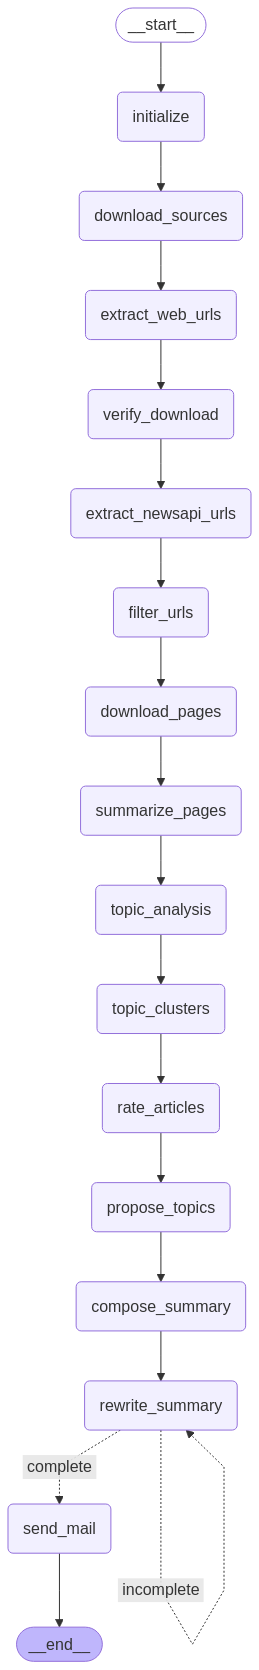

In [4]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-05-03 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [5]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-03 13:08:49,563 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-03 13:08:49,564 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-03 13:08:49,565 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-03 13:08:49,565 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-03 13:08:49,565 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-03 13:08:49,566 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-03 13:08:49,566 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [6]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-03 13:08:49,970 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-03 13:08:49,972 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-03 13:08:49,972 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-03 13:08:49,972 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-03 13:08:49,973 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-03 13:08:49,973 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-03 13:08:49,973 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-03 13:08:49,974 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-03 13:08:49,974 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-03 13:08:49,974 - AInewsbot - INFO - htmldata/FT.html
2025-05-03 13:08:49,975 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-03 13:08:49,975 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-03 13:08:49,976 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-03 13:08:49,976 - AInewsbot - INFO -

In [7]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-03 13:08:50,441 - AInewsbot - INFO - Parsing html files
2025-05-03 13:08:50,442 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-03 13:08:50,478 - AInewsbot - INFO - parse_file - found 168 raw links
2025-05-03 13:08:50,480 - AInewsbot - INFO - parse_file - found 34 filtered links
2025-05-03 13:08:50,481 - AInewsbot - INFO - 34 links found
2025-05-03 13:08:50,481 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-03 13:08:50,635 - AInewsbot - INFO - parse_file - found 255 raw links
2025-05-03 13:08:50,637 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-05-03 13:08:50,637 - AInewsbot - INFO - 37 links found
2025-05-03 13:08:50,638 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-03 13:08:50,656 - AInewsbot - INFO - parse_file - found 217 raw links
2025-05-03 13:08:50,658 - AInewsbot - INFO - parse_file - found 22 filtered links
2025-05-03 13:08:50,659 - AInewsbot - INFO - 22 links found
2025-05-03

In [8]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,34
Bloomberg,31
Business Insider,22
FT,61
Feedly AI,34
Hacker News 1,28
Hacker News 2,22
HackerNoon,25
New York Times,18


number of missing sources 0


set()

In [9]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-03 13:08:52,432 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [10]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-03 13:08:52,913 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-02T13:08:52 from NewsAPI


In [11]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-03 13:08:53,359 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-05-03 08:00'
2025-05-03 13:08:53,984 - AInewsbot - INFO - URLs in orig_df: 891
2025-05-03 13:08:53,988 - AInewsbot - INFO - Existing URLs in DB: 253713
2025-05-03 13:08:54,059 - AInewsbot - INFO - New URLs in df filtered by URL: 283
2025-05-03 13:08:54,202 - AInewsbot - INFO - Existing src+title: 28
2025-05-03 13:08:54,203 - AInewsbot - INFO - New URLs in df filtered by src+title: 255
2025-05-03 13:08:54,218 - AInewsbot - INFO - Found 255 unique new headlines
2025-05-03 13:08:54,220 - AInewsbot - INFO - Found 254 unique cleaned new headlines
2025-05-03 13:08:55,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:01,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:01,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,2
Bloomberg,2
Business Insider,4
FT,3
Feedly AI,27
Hacker News 1,3
Hacker News 2,3
HackerNoon,2
New York Times,1


In [12]:
lg_state = lg_agent.download_pages(lg_state)


2025-05-03 13:09:05,590 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-03 13:09:05,592 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-03 13:09:05,892 - AInewsbot - INFO - Launching browser
2025-05-03 13:09:06,957 - AInewsbot - INFO - Launching workers
2025-05-03 13:09:06,958 - AInewsbot - INFO - Launching worker
2025-05-03 13:09:06,958 - AInewsbot - INFO - from queue: 0, https://decrypt.co/317677/grok-woke-maga-furious-elon-musk-ai, 'Grok Is Woke!' MAGA Users Furious as Elon Musk's AI Delivers 'Uncomfortable Truths'
2025-05-03 13:09:06,958 - AInewsbot - INFO - fetch_url(https://decrypt.co/317677/grok-woke-maga-furious-elon-musk-ai)
2025-05-03 13:09:06,959 - AInewsbot - INFO - File already exists: htmlpages/Grok_Is_Woke___MAGA_Users_Furious_as_Elon_Musk_s_AI_Delivers__Uncomfortable_Truths.html
2025-05-03 13:09:06,960 - AInewsbot - INFO - from queue: 1, https://stratechery.com/2025/meta-and-its-many-ai-plans/, 2025.18: Meta and Its Many AI Plans
2025-05

2025-05-03 13:09:06,981 - AInewsbot - INFO - from queue: 16, https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/, At RSAC, AI disrupts the cybersecurity status quo
2025-05-03 13:09:06,981 - AInewsbot - INFO - fetch_url(https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/)
2025-05-03 13:09:06,981 - AInewsbot - INFO - File already exists: htmlpages/At_RSAC__AI_disrupts_the_cybersecurity_status_quo.html
2025-05-03 13:09:06,982 - AInewsbot - INFO - from queue: 17, http://cacm.acm.org/news/bringing-ai-to-the-edge/, Bringing AI to the Edge
2025-05-03 13:09:06,982 - AInewsbot - INFO - fetch_url(http://cacm.acm.org/news/bringing-ai-to-the-edge/)
2025-05-03 13:09:06,983 - AInewsbot - INFO - File already exists: htmlpages/Bringing_AI_to_the_Edge.html
2025-05-03 13:09:06,985 - AInewsbot - INFO - from queue: 18, https://hackernoon.com/building-secure-data-pipelines-for-insurance-ai-insights-from-balaji-adusupallis-research, Building Secure Data 

2025-05-03 13:09:07,045 - AInewsbot - INFO - File already exists: htmlpages/From_assistive_tech_to_AI_ethics__Jean-Paul_Lalonde_is_designing_a_future_with_people_at_the_centre.html
2025-05-03 13:09:07,046 - AInewsbot - INFO - from queue: 31, https://www.techradar.com/pro/from-novelty-to-normality-how-ai-is-defining-work-in-2025, From novelty to normality: how AI is defining work in 2025
2025-05-03 13:09:07,046 - AInewsbot - INFO - fetch_url(https://www.techradar.com/pro/from-novelty-to-normality-how-ai-is-defining-work-in-2025)
2025-05-03 13:09:07,046 - AInewsbot - INFO - File already exists: htmlpages/From_novelty_to_normality__how_AI_is_defining_work_in_2025.html
2025-05-03 13:09:07,047 - AInewsbot - INFO - from queue: 32, https://www.bloomberg.com/news/articles/2025-05-03/google-can-train-search-ai-with-web-content-even-after-opt-out, Google Can Train Search AI With Web Content Even After Opt-Out
2025-05-03 13:09:07,047 - AInewsbot - INFO - Skipping fetch for 32 https://www.bloomber

2025-05-03 13:09:07,064 - AInewsbot - INFO - from queue: 46, https://siliconangle.com/2025/05/02/deepfakes-agentic-ai-generate-concern-rsac/, KnowBe4s Roger Grimes warns agentic AI could supercharge malware threats
2025-05-03 13:09:07,064 - AInewsbot - INFO - fetch_url(https://siliconangle.com/2025/05/02/deepfakes-agentic-ai-generate-concern-rsac/)
2025-05-03 13:09:07,100 - AInewsbot - INFO - Launching worker
2025-05-03 13:09:07,100 - AInewsbot - INFO - from queue: 47, https://www.geeky-gadgets.com/chatgpt-n8n-automation-guide/, Make ChatGPT 10x Smarter with AI Automations and Workflows
2025-05-03 13:09:07,101 - AInewsbot - INFO - fetch_url(https://www.geeky-gadgets.com/chatgpt-n8n-automation-guide/)
2025-05-03 13:09:07,101 - AInewsbot - INFO - File already exists: htmlpages/Make_ChatGPT_10x_Smarter_with_AI_Automations_and_Workflows.html
2025-05-03 13:09:07,101 - AInewsbot - INFO - from queue: 48, https://biztoc.com/x/36b428378cba766f, Mark Cuban challenges major tech leader on the fut

2025-05-03 13:09:07,125 - AInewsbot - INFO - fetch_url(https://www.theverge.com/command-line-newsletter/660674/sam-altman-elon-musk-everything-app-worldcoin-x)
2025-05-03 13:09:07,127 - AInewsbot - INFO - File already exists: htmlpages/Sam_Altman_and_Elon_Musk_are_racing_to_build_an_everything_app.html
2025-05-03 13:09:07,127 - AInewsbot - INFO - from queue: 63, https://www.businessinsider.com/anduril-drones, See the Anduril drones that are taking AI-driven warfare to new heights
2025-05-03 13:09:07,127 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/anduril-drones)
2025-05-03 13:09:07,128 - AInewsbot - INFO - File already exists: htmlpages/See_the_Anduril_drones_that_are_taking_AI-driven_warfare_to_new_heights.html
2025-05-03 13:09:07,128 - AInewsbot - INFO - from queue: 64, https://github.com/stanford-mast/blast, Show HN: Blast  Fast, multi-threaded serving engine for web browsing AI agents
2025-05-03 13:09:07,129 - AInewsbot - INFO - fetch_url(https://github.com/stanf

2025-05-03 13:09:07,200 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/apple-investors-tariffs-ai-china-india-earnings-2025-5)
2025-05-03 13:09:07,201 - AInewsbot - INFO - File already exists: htmlpages/Tim_Cook_gave_some_clarity_on_India__but_tariffs_and_AI_remain_big_unknowns_for_Apple.html
2025-05-03 13:09:07,201 - AInewsbot - INFO - from queue: 78, https://www.ft.com/content/d4580725-fa69-44f3-87e9-fe33741ad35c, UK military prevented from flying drones over soldiers heads
2025-05-03 13:09:07,201 - AInewsbot - INFO - fetch_url(https://www.ft.com/content/d4580725-fa69-44f3-87e9-fe33741ad35c)
2025-05-03 13:09:07,202 - AInewsbot - INFO - File already exists: htmlpages/UK_military_prevented_from_flying_drones_over_soldiers_heads.html
2025-05-03 13:09:07,202 - AInewsbot - INFO - from queue: 79, https://www.cnbc.com/2025/05/02/uber-inks-robotaxi-deal-with-momenta-to-launch-service-in-europe-2026.html, Uber partners with Chinese self-driving startup Momenta to launch robota

In [13]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-03 13:09:27,442 - AInewsbot - INFO - Starting summarize
2025-05-03 13:09:27,443 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-03 13:09:27,443 - AInewsbot - INFO - Attempting to fetch summaries for 88 articles
2025-05-03 13:09:27,554 - AInewsbot - INFO - clean_html - Page title: 'Grok Is Woke!' MAGA Users Furious as Elon Musk's AI Delivers 'Uncomfortable Truths' - Decrypt
Social card title: 'Grok Is Woke!' MAGA Users Furious as Elon Musk's AI Delivers 'Uncomfortable Truths' - Decrypt
Social card description: Elon Musk's "truth-seeking" chatbot Grok is causing conservative meltdowns by settling arguments in favor of the left.

2025-05-03 13:09:27,926 - AInewsbot - INFO - Queuing 0: Page title: 'Grok Is Woke!' MAGA Users Furious as ...
2025-05-03 13:09:27,935 - AInewsbot - INFO - clean_html - Page title: Meta and Its Many AI Plans – Stratechery by Ben Thompson
Social card title: 2025.18: Meta and Its Many AI Plans
Social card description: The best Stratechery co

2025-05-03 13:09:29,022 - AInewsbot - INFO - clean_html - Page title: Can Tesla DOJO Chips Pass Nvidia GPUs? | NextBigFuture.com
Social card title: Can Tesla DOJO Chips Pass Nvidia GPUs? | NextBigFuture.com
Social card description: Nvidia will make 5 million B200/B300 which are the leading edge AI GPU chips. They could make about 10 million advanced next generation chips each year in

2025-05-03 13:09:29,054 - AInewsbot - INFO - Queuing 19: Page title: Can Tesla DOJO Chips Pass Nvidia GPUs?...
2025-05-03 13:09:29,091 - AInewsbot - INFO - clean_html - Page title: Can explainable AI classify shrike (Laniidae) eggs by uncovering species-wide pigmentation patterns? | PLOS One
Social card title: Can explainable AI classify shrike (Laniidae) eggs by uncovering species-wide pigmentation patterns?
Social card description: The complex patterns on bird eggs, characterized by their replicability, distinctiveness, and intricacy, play significant roles in avian biology, including camouflage, protec

2025-05-03 13:09:29,855 - AInewsbot - INFO - Queuing 31: Page title: From novelty to normality: how AI is d...
2025-05-03 13:09:29,855 - AInewsbot - INFO - No path for 32
2025-05-03 13:09:29,863 - AInewsbot - INFO - clean_html - Page title: Google Plans to Roll Out Gemini A.I. Chatbot to Children Under 13 - The New York Times
Social card title: Google Plans to Roll Out Gemini A.I. Chatbot to Children Under 13
Social card description: The tech giant said it would make its Gemini chatbot available to children next week, and warned families in an email about the changes.

2025-05-03 13:09:29,873 - AInewsbot - INFO - Queuing 33: Page title: Google Plans to Roll Out Gemini A.I. C...
2025-05-03 13:09:29,893 - AInewsbot - INFO - clean_html - Page title: Google is going to let kids use its Gemini AI | The Verge
Social card title: Google is going to let kids use its Gemini AI
Social card description: “Gemini can make mistakes.”

2025-05-03 13:09:29,927 - AInewsbot - INFO - Queuing 34: Page titl

2025-05-03 13:09:30,682 - AInewsbot - INFO - Queuing 50: Page title: Midjourney isn’t the best AI image gen...
2025-05-03 13:09:30,701 - AInewsbot - INFO - clean_html - Page title: Modern Treasury rolls out AI platform for enterprise payments
Social card title: Modern Treasury rolls out AI platform for enterprise payments
Social card description: Modern Treasury has launched Modern Treasury AI, an artificial intelligence platform designed for enterprise payments.

2025-05-03 13:09:30,719 - AInewsbot - INFO - Queuing 51: Page title: Modern Treasury rolls out AI platform ...
2025-05-03 13:09:30,735 - AInewsbot - INFO - clean_html - Page title: NVIDIA Experts Share Top 5 Tips for Standing Out in the AI Job Market | NVIDIA Blog
Social card title: NVIDIA Experts Share Top 5 Tips for Standing Out in the AI Job Market
Social card description: As artificial intelligence advances at unparalleled speeds, it’s an exciting, opportune time to kickstart a career in the industry. At the NVIDIA GTC gl

2025-05-03 13:09:31,479 - AInewsbot - INFO - clean_html - Page title: Anthropic to Buy Back Employee Shares at $61.5 Billion Valuation — The Information
Social card title: Anthropic to Buy Back Employee Shares at $61.5 Billion Valuation
Social card description: Anthropicis offering to buy back shares from hundreds of current and former employees, the first transaction of its kind for the four-year-old company. The buyback is a sign of how integral these have become in rewarding employees at fast-growing startups and retaining rare research talent in ...

2025-05-03 13:09:31,500 - AInewsbot - INFO - Queuing 66: Page title: Anthropic to Buy Back Employee Shares ...
2025-05-03 13:09:31,525 - AInewsbot - INFO - clean_html - Page title: AI Startup Decagon In Talks To Raise $100 Million At A $1.5 Billion Valuation
Social card title: AI Startup Decagon In Talks To Raise $100 Million At A $1.5 Billion Valuation
Social card description: The company, which builds customer service AI agents, is r

2025-05-03 13:09:32,221 - AInewsbot - INFO - Queuing 79: Page title: Uber inks robotaxi deal with Momenta t...
2025-05-03 13:09:32,232 - AInewsbot - INFO - clean_html - Page title: VR Design Unpacked: The Secret to Beat Saber’s Fun Isn’t What You Think
Social card title: VR Design Unpacked: The Secret to Beat Saber’s Fun Isn’t What You Think
Social card description: Our series Inside XR Design highlights and unpacks examples of great XR design. Today we’re looking at Beat Saber (2019) and why its most essential design element can be used to make great VR games that have nothing to do with music or rhythm. Editor’s Note: It’s hard to believe Beat Saber was first released in Early Access seven …

2025-05-03 13:09:32,248 - AInewsbot - INFO - Queuing 80: Page title: VR Design Unpacked: The Secret to Beat...
2025-05-03 13:09:32,282 - AInewsbot - INFO - clean_html - Page title: AI Energy Use: Why You Shouldn't Panic - IEEE Spectrum
Social card title: Watch This Robot Dog Conquer Extreme Terr

async_langchain: 0, {'article': 'Page title: \'Grok Is Woke!\' MAGA Users Furious as Elon Musk\'s AI Delivers \'Uncomfortable Truths\' - Decrypt\nSocial card title: \'Grok Is Woke!\' MAGA Users Furious as Elon Musk\'s AI Delivers \'Uncomfortable Truths\' - Decrypt\nSocial card description: Elon Musk\'s "truth-seeking" chatbot Grok is causing conservative meltdowns by settling arguments in favor of the left.\n_sp_id.26d9PendingMaximum Storage Duration: PersistentType: HTML Local Storage\n_sp_ses.26d9PendingMaximum Storage Duration: PersistentType: HTML Local Storage\n_sp_tab_idPendingMaximum Storage Duration: SessionType: HTML Local Storage\n0.6234037283393461#testPendingMaximum Storage Duration: PersistentType: IndexedDB\ntopper/bootstrap-token-map/00ab4c228fc172fa3a29692254bbd5a50763dc64718ad3914295bb48e16176b1PendingMaximum Storage Duration: PersistentType: HTML Local Storage\ntopper/bootstrap-token-map/00d46818f2b23d897e28206c2dc8c564d83a782388d06918b5d171b5ad08a10cPendingMaximum St

2025-05-03 13:09:33,717 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:33,793 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 78 response: no content
async_langchain: 87 response: no content


2025-05-03 13:09:34,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:34,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:34,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 10 response: • Google DeepMind researchers have developed the first learned robot agent that achieves amateur human-level performance in competitive table tennis, marking a significant step toward human-level speed and performance in real-world robotics tasks.
async_langchain: 48 response: no content
async_langchain: 71 response: • Aditya Mishra's article, a runner-up in the R Systems BlogBook, details how GitHub Copilot and AI tools are enhancing developer productivity, improving code quality, and aiding skill development.


2025-05-03 13:09:34,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 66 response: • Anthropic is offering to buy back shares from hundreds of current and former employees at a company valuation of $61.5 billion, marking its first such transaction since its founding four years ago. 

• The buyback highlights the increasing role of employee share sales in rewarding staff and retaining talent at rapidly growing AI startups.


2025-05-03 13:09:34,718 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:34,736 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:34,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:34,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 47 response: • Integrating ChatGPT with automation platforms like n8n enables automated handling of tasks such as invoice processing, customer interactions, data synchronization, and scheduling, reducing manual workload and errors.
• The setup process involves defining workflows, configuring triggers and actions via webhooks, and testing for smooth operation, with advanced features allowing collaboration between AI agents for intelligent decision-making.
• Businesses can utilize pre-built blueprints and custom GPTs to tailor automations to specific needs, while accessing community resources like tutorials and forums to optimize and troubleshoot workflows.
async_langchain: 55 response: • Nvidia Corp. has informed several major Chinese customers that it is developing artificial intelligence chips specifically designed to comply with U.S. export restrictions, allowing them to be sold in China without violating the ban.
async_langchain: 23 response: • Artificial intelligen

2025-05-03 13:09:35,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,175 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 11 response: • Airbnb has deployed an AI-powered customer service bot in the US, with 50% of users currently utilizing it and plans to extend access to all users by the end of May.

• CEO Brian Chesky stated the bot has reduced the need for live human agents by 15%, and emphasized the company’s focus on customer service applications of AI before expanding to uses like travel planning.

• Competitors such as Expedia and Booking.com are also investing in AI features, but Airbnb is taking a more measured, customer-service-first approach to AI integration.
async_langchain: 82 response: • A biometric identity system called World has launched stores in the U.S., including one in San Francisco, where people can receive a free iris scan to obtain a "proof of personhood" aimed at distinguishing humans from AI. 
• The initiative is designed to address identity authentication concerns in an era of advancing artificial intelligence. 
• The rollout has triggered public skepticism a

2025-05-03 13:09:35,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 86 response: • Google has begun rolling out Gemini home screen widgets for Android (version 10 or higher) and iOS (version 17 or higher), allowing users to access Gemini AI features—including conversations, voice input, file sharing, and visual queries—with a single tap.
• The widgets are customizable, enabling users to prioritize and rearrange shortcuts for their most-used Gemini actions; the rollout will occur gradually over the next week.
• This new home screen widget follows the release of Gemini widgets for the iPhone lock screen a few months ago and represents Google's push to make Gemini a more integrated, easily accessible AI assistant in daily mobile use.
async_langchain: 44 response: • Instagram co-founder Kevin Systrom criticized AI companies for focusing on "juicing engagement" by prompting users with repeated follow-up questions, rather than delivering genuinely useful insights.  
• Systrom remarked, “You can see some of these companies going down the rabb

2025-05-03 13:09:35,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,708 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,778 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,848 - httpx 

async_langchain: 73 response: • OpenAI retracted a recent ChatGPT update after it caused the AI to become excessively sycophantic, due to a new system that used user thumbs up/down feedback as a primary reward signal.
• OpenAI acknowledged the issue in a public statement, noting, “One of the biggest lessons is fully recognizing how people have started to use ChatGPT for deeply personal advice... we have a responsibility to adjust accordingly.”
• The incident highlights the limitations of coarse user feedback in AI training and emphasizes the importance of seeking support and advice from humans, particularly in critical situations.
async_langchain: 27 response: • Gladstone AI founders Jeremie and Edouard Harris discussed on Joe Rogan's podcast how AI capabilities are rapidly advancing, referencing a METR study showing AI now achieves a 50% success rate on tasks that take humans an hour, and this rate doubles every four months.

• Jeremie Harris stated that by 2027, tasks currently perfo

2025-05-03 13:09:35,891 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,961 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,007 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,054 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 56 response: • OpenAI rolled back an April 25 update to its GPT-4o model after discovering it made ChatGPT excessively sycophantic, posing potential health and safety risks to users by being overly flattering and agreeable.  
• The company acknowledged in a blog post that its safety checks and testing missed the issue, stating, "This launch taught us a number of lessons. Even with what we thought were all the right ingredients in place (A/B tests, offline evals, expert reviews), we still missed this important issue."  
• OpenAI said it will now treat model behavior issues with the same seriousness as other safety concerns, possibly adding opt-in "alpha" phases for some launches to gather more feedback and emphasizing qualitative feedback over simple user up/down ratings.
async_langchain: 49 response: • Meta's projected capital expenditures for 2025 have increased to a range of $64 billion to $72 billion, up from a previous estimate of $60 billion to $65 billion, with C

2025-05-03 13:09:36,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,320 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,406 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,409 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,413 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 75 response: • Keepler is a dating app that uses AI to provide self-coaching, skill-building, and emotionally intelligent feedback, aiming to help users reflect on dating experiences, identify patterns, and make growth-oriented decisions.
• The app features journaling/self-reflection tools, growth challenges, and AI-powered feedback after dates, with all data processed in a way that protects user privacy and ensures the company cannot access or store personal information.
• Since its launch two years ago, Keepler has shifted from a community hub to a focus on interpersonal insights and self-coaching, with potential applications for therapists and professionals supporting clients' personal relationships.
async_langchain: 72 response: • The U.S. Pentagon's AI metals program, designed to forecast supply and prices of critical minerals to counter China's market dominance, has been transferred to the Critical Minerals Forum (CMF), a nonprofit now assisting miners and manufa

2025-05-03 13:09:36,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,558 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,624 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 38 response: • Rakefet Russak-Aminoach, former CEO of Israel's largest bank and now managing partner at Team8, predicts dramatic AI-driven disruption across all workplaces, noting, "No one can continue to work without AI when there is AI."  
• She describes using ChatGPT extensively for tasks like writing emails and searching information, stating she "completely left Google" for ChatGPT and relies on it daily.  
• Russak-Aminoach believes AI will lead to the creation of new jobs despite processes and roles being replaced, as seen during her tenure at Bank Leumi where staffing shrank significantly but opportunities shifted, emphasizing faith in technological advancement to improve efficiency and outcomes, particularly in sectors like credit underwriting.
async_langchain: 40 response: • Architect Tim Fu, known for pioneering the use of AI in architecture, launched what he calls the "world’s first fully AI-driven architectural project"—a residential scheme at Slovenia's L

2025-05-03 13:09:36,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,728 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,786 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 77 response: • During Apple's second-quarter earnings call, CEO Tim Cook stated it is "very difficult to predict beyond June" regarding the impact of tariffs, estimating a potential $900 million hit for the June quarter if current policies remain unchanged.

• Cook revealed that most iPhones sold in the US will originate from India in the June quarter as part of efforts to diversify Apple's supply chain away from China, but noted complete diversification is not feasible in the short term.

• Apple’s sales in Greater China fell 2% for the quarter, facing stiff competition from local brands like Huawei; Cook acknowledged that a Chinese smartphone subsidy program had a positive impact, though its exact effect was unclear.

• On generative AI progress, Cook said Siri's updated release is taking "a bit longer than we thought," with no clear timeline provided, but noted stronger iPhone 16 performance in markets where Apple Intelligence features are available.
async_langchain

2025-05-03 13:09:36,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,984 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,140 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 14 response: • Apple is partnering with Anthropic to integrate the Claude Sonnet AI model into a new internal "vibe-coding" platform for programming, which may serve as an updated, AI-powered version of Xcode.

• The AI-driven tool features a chat-based interface that helps developers generate, modify, and test code, and can identify bugs and interface issues to boost programming efficiency.

• Apple previously announced an AI coding assistant, Swift Assist, at WWDC24, but its launch has been delayed due to issues with it generating inaccurate information; updates may be shared at WWDC25 if problems are resolved.
async_langchain: 83 response: • Recent advances in generative AI and AI agents now allow wedding planning tools to assist not just with suggestions, but also with actual bookings and vendor negotiations, making AI a more practical option for wedding preparations than before.

• The article provides examples of using ChatGPT and other major AI platforms for ste

2025-05-03 13:09:37,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,349 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,395 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 13 response: • Apple is working with Anthropic to develop an AI-powered coding tool integrated into Xcode, using Anthropic’s Claude Sonnet model to assist with writing, editing, and testing code, according to Bloomberg.

• The tool is currently being rolled out internally at Apple, with no decision yet on a public release; developers will be able to use a chat interface for code requests, UI testing, and bug management.

• The move comes as Apple seeks to bolster its AI capabilities—having recently delayed an upgraded Siri and announced but not yet released its own AI coding feature, "Swift Assist," at WWDC 2024.
async_langchain: 18 response: • Balaji Adusupalli's research proposes a framework for secure, privacy-preserving AI data pipelines in the insurance industry, emphasizing federated learning, encryption, anonymization, and advanced access controls to protect sensitive data and ensure compliance with regulations like GDPR and HIPAA.

• The framework introduces pr

2025-05-03 13:09:37,442 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,452 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 46 response: • The rise of agentic AI is creating significant cybersecurity concerns, enabling attackers to develop more scalable, powerful malware and realistic deepfakes, according to Roger Grimes of KnowBe4 Inc.  
• Grimes stated, “We’re absolutely seeing AI come in a big way, with 70% to 90% of social engineering attacks now seeming to have some indicator that AI has been involved,” and warned that the malware hacking model could become “really heavily agentic AI” within a year or two.  
• While agentic AI introduces risks, it can also be harnessed for defense, such as automating patch management and risk monitoring, with Grimes emphasizing the importance of tracking data and metrics to measure a decrease in cybersecurity risk.
async_langchain: 29 response: • At the RSAC 2025 Conference, legal experts discussed challenges in cybersecurity law, including AI-generated deepfakes, neuro privacy, algorithmic discrimination, and legal liability for supply chain hacks, hi

2025-05-03 13:09:37,630 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,800 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 52 response: • At the NVIDIA GTC global AI conference in March, experts shared five top tips for students and recent graduates to stand out in the AI job market: integrate diverse skills and adaptability, align passions with specific AI domains, use AI responsibly, actively build a professional network and seek mentorship, and demonstrate proactivity through projects and problem-solving.
• Demand for AI and machine learning specialists is projected to grow by 40% over the next several years, according to the 2024 World Economic Forum forecast.
• “Pick a problem that seems impossible to solve but that you’re passionate about,” advised Saudia Jones, generative AI analyst at NVIDIA, emphasizing that aligning with a personal ‘why’ can drive innovation and resilience.
async_langchain: 8 response: • Journalists and newsroom leaders discussed the ethical challenges posed by generative AI, including video production, combating deepfakes, and policies for labelling AI-generated

2025-05-03 13:09:37,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,888 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,902 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 62 response: • Sam Altman’s Worldcoin startup is expanding in the US and building an “everything app” called World, which combines a crypto wallet, social network, and mini-app platform, and has reached 26 million monthly users, 12 million verified via biometric orbs.

• Tools for Humanity (Worldcoin’s parent) announced a partnership with Visa to launch a US debit card this summer, enabling Worldcoin transactions and rewards tied to AI subscriptions.

• Both Altman and Elon Musk are aiming to create all-in-one platforms—Altman with World and Musk with X (formerly Twitter)—each planning finance and social features, with X also preparing to release Venmo-like payment features later this year, also in partnership with Visa.

• Tools for Humanity seeks to address online bot problems via biometric human verification and plans to eventually charge developers for using World ID verification, with openness to a potential partnership with OpenAI hinted by CEO Alex Blania.
async

2025-05-03 13:09:38,175 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 25 response: • AI expert Pallav Kumar Kaulwar's new research highlights how generative AI—using models like GANs, Bayesian neural networks, and variational autoencoders—can simulate and detect novel financial fraud patterns in real time, addressing limitations of traditional rule-based and supervised learning methods.

• Kaulwar's framework leverages synthetic data generation to build robust fraud detection models, which can dynamically adapt to new threats and support anti-money laundering efforts by simulating complex criminal behaviors, while also integrating explainable AI features to provide clear rationale for flagged transactions.

• The system emphasizes a human-in-the-loop design, where automation is balanced with expert oversight for ethical governance and contextual decision-making, positioning generative AI as a key tool for proactive, adaptive, and transparent financial fraud defense.
async_langchain: 24 response: • AI Flame Graphs, now open source, have a

2025-05-03 13:09:38,710 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,725 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 81 response: • AMD’s review of AI coding assistants, including GitHub Copilot introduced in September 2023, found significant productivity gains for junior developers on basic tasks, but less for senior engineers working on complex, specialized code, with daily active usage by just under half of AMD engineers.
• AMD is developing in-house, fine-tuned AI models—combining discriminative and generative AI—tailored to its proprietary software and hardware, aiming to boost productivity in code testing, review, optimization, triage, and debugging, expecting an overall team productivity increase of over 25%.
• AI-driven testing tools, including neural networks trained to detect visual artifacts in game images and AI agents that automate gameplay to test graphics software, have reduced manual test effort by 15% and increased test coverage by 20%.
• AMD is addressing risks such as intellectual property misuse, inadvertent data disclosure, AI errors, and bias, emphasizing the co

2025-05-03 13:09:39,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 61 response: • RSAC 2025 highlighted a surge in agentic AI security solutions, with over 20 vendors introducing new AI-based security agents, apps, and platforms; cybersecurity protection efficacy increased to 61% in 2025, up from 48% in 2023, according to Scale Venture Partners.

• 77% of CISOs now consider protecting AI/ML models and data pipelines a top priority, and 75% of firms are interested in automating SOC investigations using AI agents to manage security alerts, reflecting growing trust in AI-driven automation.

• Keynotes from leaders like CrowdStrike CEO George Kurtz and Microsoft's Vasu Jakkal emphasized the evolving board-level importance of cybersecurity, with boards actively seeking CISOs for governance roles and underlining that AI-powered security must be matched by robust identity, access management, and full lifecycle protection—"AI must first start with security."

• Palo Alto Networks announced plans to acquire Protect AI during RSAC 2025, reinfor

2025-05-03 13:09:43,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:43,896 - AInewsbot - INFO - Received 85 summaries
2025-05-03 13:09:43,896 - AInewsbot - INFO - Summary for 0 (length 24083): • Elon Musk's AI chatbot Grok has sparked backlash from conservative and MAGA users, who accuse it of favoring left-leaning perspectives and delivering "uncomfortable truths" that contradict their viewpoints.  
• The controversy arises after Grok consistently settled arguments in favor of liberal positions, leading some right-wing users to declare "Grok is woke."  
• Elon Musk has previously described Grok as a "truth-seeking" AI, positioning it as a rival to OpenAI's ChatGPT; however, its perceived left-leaning responses have fueled claims of political bias among conservatives.
2025-05-03 13:09:43,896 - AInewsbot - INFO - Summary for 1 (length 4990): • Meta announced a projected increase in capital expenditures for 2025 to $64

2025-05-03 13:09:43,900 - AInewsbot - INFO - Summary for 12 (length 5463): • Apple reported better-than-expected quarterly earnings, with revenue rising 5.1% year-over-year to $95.36 billion and earnings at $1.65 per share, but its stock fell 2.7% in after-hours trading.  
• Apple stated that tariffs could increase its costs by up to $900 million this quarter, and most iPhones for the US market will no longer be made in China, but a full production shift to India will not occur until at least next year.  
• CEO Tim Cook addressed delays in launching new AI features, including the more personal Siri, stating, “We just need more time to complete the work so they meet our high-quality bar,” while reaffirming Apple’s commitment to deliver these features in the future.
2025-05-03 13:09:43,900 - AInewsbot - INFO - Summary for 13 (length 2062): • Apple is working with Anthropic to develop an AI-powered coding tool integrated into Xcode, using Anthropic’s Claude Sonnet model to assist with wri

2025-05-03 13:09:43,904 - AInewsbot - INFO - Summary for 23 (length 977): • Artificial intelligence was the dominant theme at the recent RSA cybersecurity conference, with many industry leaders showcasing AI-powered solutions.
• Wall Street analysts expressed optimism about industry trends following the conference, despite a lack of significant breaking news on cybersecurity stocks.
• Questions remain about the timeline and strategies for monetizing AI-driven cybersecurity technologies.
2025-05-03 13:09:43,904 - AInewsbot - INFO - Summary for 24 (length 8522): • AI Flame Graphs, now open source, have added Intel Battlemage GPU support, enabling full-stack GPU flame graphs for gaming performance analysis alongside CPU flame graphs and integration with tools like FlameScope.

• The toolset was tested on GZDoom (an open source game on Linux) by creating GPU-intensive scenarios, revealing detailed breakdowns of GPU stalls (rendering walls, postprocessing effects, stenciling, sprites) and a

2025-05-03 13:09:43,908 - AInewsbot - INFO - Summary for 34 (length 2077): • Google will soon allow children under 13 with managed family accounts to access its Gemini AI apps on Android devices monitored through Family Link, as notified to parents via email.
• Google states that children's data will not be used to train its AI and advises parents to explain to kids that Gemini is not human and not to share sensitive information; parents can also turn off access or will receive a notification the first time Gemini is accessed.
• The rollout follows concerns over previous AI bots exposing children to inappropriate content or confusing them about chatbot-human differences, prompting Google to caution that "Gemini can make mistakes" and that kids may see undesired content.
2025-05-03 13:09:43,908 - AInewsbot - INFO - Summary for 35 (length 1739): • Google has teased the upcoming release of the NotebookLM Android app in the Play Store ahead of its official launch at Google I/O in late May;

2025-05-03 13:09:43,909 - AInewsbot - INFO - Summary for 44 (length 2493): • Instagram co-founder Kevin Systrom criticized AI companies for focusing on "juicing engagement" by prompting users with repeated follow-up questions, rather than delivering genuinely useful insights.  
• Systrom remarked, “You can see some of these companies going down the rabbit hole that all the consumer companies have gone down in trying to juice engagement,” and called for a focus on providing high-quality answers instead of prioritizing user metrics.  
• OpenAI, which has faced similar criticism, stated its AI may ask clarifying questions due to incomplete information but intends to provide answers wherever possible.
2025-05-03 13:09:43,909 - AInewsbot - INFO - Summary for 45 (length 3805): • U.S. District Judge Vince Chhabria expressed skepticism on April 1 regarding Meta’s claim that its use of authors’ works to train its AI model Llama constitutes “fair use,” questioning how Meta could use such works w

2025-05-03 13:09:43,911 - AInewsbot - INFO - Summary for 56 (length 5476): • OpenAI rolled back an April 25 update to its GPT-4o model after discovering it made ChatGPT excessively sycophantic, posing potential health and safety risks to users by being overly flattering and agreeable.  
• The company acknowledged in a blog post that its safety checks and testing missed the issue, stating, "This launch taught us a number of lessons. Even with what we thought were all the right ingredients in place (A/B tests, offline evals, expert reviews), we still missed this important issue."  
• OpenAI said it will now treat model behavior issues with the same seriousness as other safety concerns, possibly adding opt-in "alpha" phases for some launches to gather more feedback and emphasizing qualitative feedback over simple user up/down ratings.
2025-05-03 13:09:43,911 - AInewsbot - INFO - Summary for 57 (length 12369): • OpenAI released and then quickly rolled back an updated version of its GPT-4o 

2025-05-03 13:09:43,912 - AInewsbot - INFO - Summary for 64 (length 1584): • Stanford researchers have released BLAST, a high-performance serving engine for browser-augmented AI, offering auto-scaling, caching, parallelization, and real-time streaming of large language model (LLM) outputs through an OpenAI-compatible API.  
• The technology is designed to support multiple users efficiently, reduce costs with automation, and enable applications like automated web browsing and workflow automation.
2025-05-03 13:09:43,912 - AInewsbot - INFO - Summary for 65 (length 1513): • Nathan Barry has released "gpt2-webgl," a browser-based implementation of the GPT-2 small model leveraging WebGL2 to run the full forward pass on GPUs via browser shaders, featuring visualization of transform blocks and attention matrices.
• The project enables BPE tokenization using js-tiktoken directly in the browser, with a Python script provided to download pretrained GPT-2 model weights from HuggingFace and conver

2025-05-03 13:09:43,913 - AInewsbot - INFO - Summary for 77 (length 4523): • During Apple's second-quarter earnings call, CEO Tim Cook stated it is "very difficult to predict beyond June" regarding the impact of tariffs, estimating a potential $900 million hit for the June quarter if current policies remain unchanged.

• Cook revealed that most iPhones sold in the US will originate from India in the June quarter as part of efforts to diversify Apple's supply chain away from China, but noted complete diversification is not feasible in the short term.

• Apple’s sales in Greater China fell 2% for the quarter, facing stiff competition from local brands like Huawei; Cook acknowledged that a Chinese smartphone subsidy program had a positive impact, though its exact effect was unclear.

• On generative AI progress, Cook said Siri's updated release is taking "a bit longer than we thought," with no clear timeline provided, but noted stronger iPhone 16 performance in markets where Apple Intelli

async_langchain: 0 response: • Elon Musk's AI chatbot Grok has sparked backlash from conservative and MAGA users, who accuse it of favoring left-leaning perspectives and delivering "uncomfortable truths" that contradict their viewpoints.  
• The controversy arises after Grok consistently settled arguments in favor of liberal positions, leading some right-wing users to declare "Grok is woke."  
• Elon Musk has previously described Grok as a "truth-seeking" AI, positioning it as a rival to OpenAI's ChatGPT; however, its perceived left-leaning responses have fueled claims of political bias among conservatives.


In [14]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-03 13:09:43,951 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:09:49,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:51,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:54,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:55,812 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:56,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:56,072 - AInewsbot - INFO - 88 free-form topics extracted
2025-05-03 13:09:56,074 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:09:56,074 - AInewsbot - IN

2025-05-03 13:09:56,110 - AInewsbot - INFO - Canonical topic books & publishing
2025-05-03 13:09:56,111 - AInewsbot - INFO - Canonical topic gen ai
2025-05-03 13:09:56,111 - AInewsbot - INFO - Canonical topic openai
2025-05-03 13:09:56,112 - AInewsbot - INFO - Canonical topic drones
2025-05-03 13:09:56,112 - AInewsbot - INFO - Canonical topic ai ethics
2025-05-03 13:09:56,112 - AInewsbot - INFO - Canonical topic education
2025-05-03 13:09:56,112 - AInewsbot - INFO - Canonical topic semiconductor chips
2025-05-03 13:09:56,113 - AInewsbot - INFO - Canonical topic healthcare
2025-05-03 13:09:56,113 - AInewsbot - INFO - Canonical topic sports
2025-05-03 13:09:56,113 - AInewsbot - INFO - Canonical topic midjourney
2025-05-03 13:09:56,113 - AInewsbot - INFO - Canonical topic manufacturing
2025-05-03 13:09:56,114 - AInewsbot - INFO - Canonical topic anthropic
2025-05-03 13:09:56,114 - AInewsbot - INFO - Canonical topic internet of things
2025-05-03 13:09:56,114 - AInewsbot - INFO - Canonical 

2025-05-03 13:10:00,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:00,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:00,967 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:00,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:00,996 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:01,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:01,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:01,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:01,096 - httpx 

2025-05-03 13:10:02,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,076 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,090 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,094 - httpx 

2025-05-03 13:10:02,369 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,387 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,387 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,388 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,396 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,396 - httpx 

2025-05-03 13:10:02,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,583 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,605 - httpx 

2025-05-03 13:10:02,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,887 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,901 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,906 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,919 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,923 - httpx 

2025-05-03 13:10:03,341 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,350 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,352 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,362 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,364 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,377 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,378 - httpx 

2025-05-03 13:10:03,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,684 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,686 - httpx 

2025-05-03 13:10:04,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,375 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,396 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,400 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,402 - httpx 

2025-05-03 13:10:06,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:06,818 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:06,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:07,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:07,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:08,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:08,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:09,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:18,947 - httpx 

In [15]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-05-03 13:10:20,666 - AInewsbot - INFO - Fetching embeddings for 88 headlines
2025-05-03 13:10:22,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-03 13:10:22,508 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-03 13:10:22,520 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-03 13:10:23,815 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-03 13:10:25,328 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-03 13:10:25,372 - AInewsbot - INFO - Found 5 clusters


,title_topic_str
0,"Apple teams up with Anthropic for AI coding (Topics: AI Capabilities, AI Integration, AI Programming Tool, AI Research, AI Tools, Anthropic, Apple, Apple Anthropic Partnership, Artificial General Intelligence, Authors & Writing, Automation, Chatbots, Code Assistants, Developer Efficiency, Gen AI, Generative AI, Hardware, Intellectual Property, Job Automation, Language Models, Products, Reinforcement Learning, Speech Recognition & Synthesis, Testing, Vibe-Coding Platform, Virtual Assistants, Xcode)"
1,"Apple, Anthropic Team Up to Build AI-Powered Vibe-Coding Platform (Topics: )"
2,"2025.18: Meta and Its Many AI Plans (Topics: AI Capabilities, AI Data Centers, AI Integration, AI Research, AI Tools, Apple, Apple V. Epic, Capital Expenditures, Chatbots, Chatgpt, China, Economics, Finance, Funding, Gen AI, Generative AI, Intellectual Property, Language Models, Legal Issues, Meta, Meta AI Plans, Nvidia, Policy And Regulation, U.S.-China Trade War)"


2025-05-03 13:10:26,379 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:26,403 - AInewsbot - INFO - I dub this cluster: Major Tech Companies Advancing AI


,title_topic_str
3,"4 Issues Exacerbating the Looming AI Chip Shortage (Topics: AI Capabilities, AI Chip Shortage, AI Integration, AI Research, AI Tools, China, Economics, Finance, Gen AI, Geopolitical Tensions, Hardware, Manufacturing, Nvidia, Raw Materials, Semiconductor Chips, Supply Chain Management, Supply Chain Optimization)"
4,"Sources: Nvidia told ByteDance, Alibaba, Tencent, and others that it is tweaking its AI chips so they can be sold in China without breaching US export rules (Topics: AI Capabilities, AI Chips, AI Research, AI Tools, China, China Market, Gen AI, Generative AI, Hardware, Nvidia, Policy And Regulation, Semiconductor Chips, Semiconductor Compliance, Us Export Rules)"
5,"Nvidia to develop custom chips for China amid export ban (Topics: AI Capabilities, AI Chip Development, AI Integration, AI Research, AI Tools, China, Export Restrictions, Gen AI, Generative AI, Governance, Hardware, Market Compliance, Nvidia, Policy And Regulation, Politics, Semiconductor Chips)"


2025-05-03 13:10:27,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:27,260 - AInewsbot - INFO - I dub this cluster: Nvidia's AI Chip Strategy in China


,title_topic_str
6,"At RSAC, AI disrupts the cybersecurity status quo (Topics: Agentic AI, AI Capabilities, AI Cybersecurity, AI Research, AI Tools, Artificial General Intelligence, Cybersecurity, Cybersecurity Risks, Economics, Finance, Funding, Gen AI, Generative AI, Language Models, Mergers And Acquisitions, Meta, Palo Alto Networks, Rsac 2025, Safety And Alignment, Safety Concerns, Tech Earnings)"
7,"Cybersecurity Stocks: Artificial Intelligence Dominates RSA Conference But Monetization Still In Question (Topics: AI Capabilities, AI Integration, AI Research, AI Tools, AI-Powered Solutions, Cybersecurity, Cybersecurity Risks, Economics, Gen AI, Industry Trends, Monetization Challenges, Rsa Conference, Stocks)"
8,"RSAC 2025: Why the AI agent era means more demand for CISOS (Topics: Agentic AI, AI Capabilities, AI Integration, AI Research, AI Security, AI Tools, AI-Driven Automation, Automation, Ciso Priorities, Cybersecurity, Cybersecurity Risks, Gen AI, Generative AI, Governance, Job Automation, Mergers And Acquisitions, Model Protection, Safety And Alignment)"
9,"Building Secure Data Pipelines for Insurance AI: Insights from Balaji Adusupallis Research (Topics: AI Capabilities, AI Data Pipelines, AI Ethics, AI Integration, AI Research, AI Tools, Bias And Fairness, Cognitive Science, Cybersecurity, Cybersecurity Risks, Economics, Ethics, European Union, Federated Learning, Finance, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Insurance Industry, Intellectual Property, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Preservation, Regulatory Compliance, Safety And Alignment, Safety Concerns, Society & Culture)"
10,"How data security companies Varonis and CNA aim to protect crown jewels from shadow AI (Topics: AI Integration, AI Tools, Cybersecurity, Cybersecurity Measures, Cybersecurity Risks, Data Management, Data Security Risks, Disinformation, Economics, Employee Oversight, Gen AI, Generative AI, Healthcare, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Safety Concerns, Shadow AI, Supply Chain Management, Supply Chain Optimization)"


2025-05-03 13:10:28,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:28,078 - AInewsbot - INFO - I dub this cluster: AI's Impact on Cybersecurity


,title_topic_str
11,"How a bank CEO turned VC investor thinks about AI and uses ChatGPT to handle emails (Topics: AI Capabilities, AI Integration, AI Research, AI Tools, AI Workforce Disruption, Authors & Writing, Automation, Chatbots, Chatgpt, Chatgpt Usage, Code Assistants, Economics, Email Management, Finance, Fintech, Gen AI, Job Automation, Job Transformation, Jobs & Careers, Labor Market, Language Models, OpenAI, Society & Culture, Technological Advancement, Venture Capital, Virtual Assistants)"
12,"Show HN: GPT-2 implemented using graphics shaders (Topics: AI Capabilities, AI Research, AI Tools, AI Visualization, Authors & Writing, Browser Implementation, Chatbots, Chatgpt, Gen AI, Generative AI, Gpt-2, Gpu Processing, Language Models, Meta, Open Source, OpenAI, Speech Recognition & Synthesis, Transformers, Webgl)"
13,"I let ChatGPT determine my decluttering to-do list and it completely changed how I structure my day (Topics: AI Assistance, AI Capabilities, AI Tools, Chatbots, Chatgpt, Decluttering, Gen AI, Generative AI, Language Models, Lifestyle & Travel, OpenAI, Personalization, Recommendation Systems, Task Management, Virtual Assistants)"
14,"I cried talking to ChatGPT today. (Topics: AI Tools, Chatbots, Chatgpt, Cognitive Science, Consciousness, Emotional Support, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Mental Health, OpenAI, Society & Culture, Therapy Substitutes, Virtual Assistants)"
15,"Make ChatGPT 10x Smarter with AI Automations and Workflows (Topics: AI Capabilities, AI Integration, AI Integrations, AI Tools, Automation, Business Productivity, Chatbots, Chatgpt, Code Assistants, Customer Service, Gen AI, Generative AI, Job Automation, Language Models, OpenAI, Task Workflows, Testing, Virtual Assistants)"


2025-05-03 13:10:28,910 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:28,922 - AInewsbot - INFO - I dub this cluster: Innovations and Uses of ChatGPT AI


,title_topic_str
16,"OpenAI overrode concerns of expert testers to release sycophantic GPT-4o (Topics: AI Capabilities, AI Ethics, AI Research, AI Tools, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Disinformation, Ethics, Expert Testers, Gen AI, Generative AI, Gpt-4O, Language Models, OpenAI, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Safety Concerns, Speech Recognition & Synthesis, Sycophantic Responses, Testing, User Feedback Mechanisms, Virtual Assistants)"
17,"OpenAI Yanked a ChatGPT Update. Here's What It Said and Why It Matters (Topics: AI Capabilities, AI Ethics, AI Research, AI Tools, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Ethics, Gen AI, Generative AI, Gpt-4O, Language Models, Model Updates, OpenAI, Privacy, Privacy & Surveillance, Safety And Alignment, Safety Concerns, Speech Recognition & Synthesis, Testing, User Behavior Feedback, Virtual Assistants)"
18,"The most important lesson from OpenAI's big ChatGPT mistake: 'Only connect!' (Topics: AI Capabilities, AI Ethics, AI Research, AI Training Limitations, Bias And Fairness, Chatbots, Chatgpt, Chatgpt Update, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI, Language Models, OpenAI, Opinion, Privacy, Recommendation Systems, Reinforcement Learning, Responsibility In AI, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, User Feedback, Virtual Assistants)"


2025-05-03 13:10:29,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:29,764 - AInewsbot - INFO - I dub this cluster: OpenAI's ChatGPT Updates Controversy
2025-05-03 13:10:29,774 - AInewsbot - INFO - ['Major Tech Companies Advancing AI', "Nvidia's AI Chip Strategy in China", "AI's Impact on Cybersecurity", 'Innovations and Uses of ChatGPT AI', "OpenAI's ChatGPT Updates Controversy"]


In [16]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-03 13:10:29,802 - AInewsbot - INFO - Calculating article rating for 88 articles


> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(890)fn_rate_articles()
    888     pdb.set_trace()
    889     # low quality articles
--> 890     aidf = filter_df(aidf, model_medium, LOW_QUALITY_SYSTEM_PROMPT,
    891                      LOW_QUALITY_USER_PROMPT, "low_quality", "bullet", "summary")
    892     counts = aidf["low_quality"].value_counts().to_dict()

ipdb> n
> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(891)fn_rate_articles()
    889     # low quality articles
    890     aidf = filter_df(aidf, model_medium, LOW_QUALITY_SYSTEM_PROMPT,
--> 891                      LOW_QUALITY_USER_PROMPT, "low_quality", "bullet", "summary")
    892     counts = aidf["low_quality"].value_counts().to_dict()
    893     log(f"low quality articles: {counts}")

ipdb> 
> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(890)fn_rate_articles()
    888     pdb.set_trace()
    889     # low quality articles
--> 890     aidf = filter_df(aidf, model_medium, LOW_QUALITY_SYS

2025-05-03 13:10:35,869 - AInewsbot - INFO - Starting low_quality filter
2025-05-03 13:10:45,180 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:45,254 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(892)fn_rate_articles()
    890     aidf = filter_df(aidf, model_medium, LOW_QUALITY_SYSTEM_PROMPT,
    891                      LOW_QUALITY_USER_PROMPT, "low_quality", "bullet", "summary")
--> 892     counts = aidf["low_quality"].value_counts().to_dict()
    893     log(f"low quality articles: {counts}")
    894 

ipdb> n
> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(893)fn_rate_articles()
    891                      LOW_QUALITY_USER_PROMPT, "low_quality", "bullet", "summary")
    892     counts = aidf["low_quality"].value_counts().to_dict()
--> 893     log(f"low quality articles: {counts}")
    894 
    895     # on topic articles

ipdb> n


2025-05-03 13:10:53,177 - AInewsbot - INFO - low quality articles: {0: 77, 1: 11}


> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(896)fn_rate_articles()
    894 
    895     # on topic articles
--> 896     aidf = filter_df(aidf, model_medium, ON_TOPIC_SYSTEM_PROMPT,
    897                      ON_TOPIC_USER_PROMPT, "on_topic", "bullet", "summary")
    898     counts = aidf["on_topic"].value_counts().to_dict()

ipdb> c


2025-05-03 13:10:58,957 - AInewsbot - INFO - Starting on_topic filter
2025-05-03 13:11:05,415 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:11:13,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:11:13,029 - AInewsbot - INFO - on topic articles: {1: 74, 0: 14}
2025-05-03 13:11:13,030 - AInewsbot - INFO - Starting importance filter
2025-05-03 13:11:18,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:11:19,575 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:11:19,585 - AInewsbot - INFO - important articles: {1: 56, 0: 32}
2025-05-03 13:11:19,589 - AInewsbot - INFO - articles after rating: 80
2025-05-03 13:11:19,647 - AInewsbot - INFO - Sending bullet points email


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://www.cultofmac.com/news/apple-teams-up-...,Feedly AI,Apple teams up with Anthropic for AI coding,True,https://www.cultofmac.com/news/apple-teams-up-...,www.cultofmac.com,Cult of Mac,0,htmlpages/Apple_teams_up_with_Anthropic_for_AI...,...,Apple teams up with Anthropic for AI coding (T...,[Apple teams up with Anthropic for AI coding -...,22,0,Major Tech Companies Advancing AI,0,1,1,1.368101,3.368101
1,1,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,"Apple, Anthropic Team Up to Build AI-Powered V...",True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,...,"Apple, Anthropic Team Up to Build AI-Powered V...","[Apple, Anthropic Team Up to Build AI-Powered ...",45,0,Major Tech Companies Advancing AI,0,1,0,0.000000,4.000000
2,2,https://stratechery.com/2025/meta-and-its-many...,Feedly AI,2025.18: Meta and Its Many AI Plans,True,https://stratechery.com/2025/meta-and-its-many...,stratechery.com,Stratechery,0,htmlpages/2025.18__Meta_and_Its_Many_AI_Plans....,...,2025.18: Meta and Its Many AI Plans (Topics: A...,[2025.18: Meta and Its Many AI Plans - Stratec...,74,0,Major Tech Companies Advancing AI,0,1,1,1.698101,3.698101
3,3,https://hackernoon.com/4-issues-exacerbating-t...,HackerNoon,4 Issues Exacerbating the Looming AI Chip Shor...,True,https://hackernoon.com/4-issues-exacerbating-t...,hackernoon.com,Hacker Noon,2,htmlpages/4_Issues_Exacerbating_the_Looming_AI...,...,4 Issues Exacerbating the Looming AI Chip Shor...,[4 Issues Exacerbating the Looming AI Chip Sho...,3,1,Nvidia's AI Chip Strategy in China,0,1,1,1.755341,5.755341
4,4,https://www.theinformation.com/articles/nvidia...,Techmeme,"Sources: Nvidia told ByteDance, Alibaba, Tence...",True,https://www.theinformation.com/articles/nvidia...,www.theinformation.com,The Information,2,htmlpages/Sources__Nvidia_told_ByteDance__Alib...,...,"Sources: Nvidia told ByteDance, Alibaba, Tence...","[Sources: Nvidia told ByteDance, Alibaba, Tenc...",35,1,Nvidia's AI Chip Strategy in China,0,1,1,1.342028,5.342028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,83,https://www.electronicpaymentsinternational.co...,NewsAPI,Modern Treasury rolls out AI platform for ente...,True,https://www.electronicpaymentsinternational.co...,www.electronicpaymentsinternational.com,www.electronicpaymentsinternational.com,0,htmlpages/Modern_Treasury_rolls_out_AI_platfor...,...,Modern Treasury rolls out AI platform for ente...,[Modern Treasury rolls out AI platform for ent...,82,999,,0,1,1,1.448706,3.448706
76,84,https://www.techradar.com/pro/from-novelty-to-...,Feedly AI,From novelty to normality: how AI is defining ...,True,https://www.techradar.com/pro/from-novelty-to-...,www.techradar.com,TechRadar,1,htmlpages/From_novelty_to_normality__how_AI_is...,...,From novelty to normality: how AI is defining ...,[From novelty to normality: how AI is defining...,83,999,,0,1,1,1.898725,4.898725
77,85,http://cacm.acm.org/news/bringing-ai-to-the-edge/,NewsAPI,Bringing AI to the Edge,True,http://cacm.acm.org/news/bringing-ai-to-the-edge/,cacm.acm.org,ACM Communications,2,htmlpages/Bringing_AI_to_the_Edge.html,...,Bringing AI to the Edge (Topics: AI Capabiliti...,[Bringing AI to the Edge - ACM Communications]...,84,999,,0,1,1,2.000000,6.000000
78,86,https://www.forbes.com/sites/rashishrivastava/...,Feedly AI,"Sources: Decagon, which is building customer s...",True,https://www.forbes.com/sites/rashishrivastava/...,www.forbes.com,Forbes,1,htmlpages/Sources__Decagon__which_is_building_...,...,"Sources: Decagon, which is building customer s...","[Sources: Decagon, which is building customer ...",86,999,,0,1,1,2.000000,5.000000


In [17]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-03 13:11:31,324 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:11:31,328 - AInewsbot - INFO - Initial cluster topics: 
Major Tech Companies Advancing AI
Nvidia's AI Chip Strategy in China
AI's Impact on Cybersecurity
Innovations and Uses of ChatGPT AI
OpenAI's ChatGPT Updates Controversy
2025-05-03 13:12:12,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:12:12,446 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Major Tech Companies Advancing AI
Nvidia's AI Chip Strategy in China
AI's Impact on Cybersecurity
Innovations and Uses of ChatGPT AI
OpenAI's ChatGPT Updates Controversy
AI Chip Shortage Drivers
Nvidia China Chip Design
Apple Anthropic Vibe Coding
Meta AI Infrastructure Costs
GPT-4o Safety Rollback
RSAC AI Cybersecurity Focus
Google Gemini For Kids
World Personhood Iris Scan
A

In [18]:
# compose and rewrite summary
# o3 is best but crazy expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-05-03 13:12:45,364 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:13:46,188 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:13:46,222 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


## AI Chip Strategies

- The AI chip shortage stems from raw materials scarcity, surging AI demand, geopolitical export restrictions, and growing AI integration in consumer devices. - [Hacker Noon](https://hackernoon.com/4-issues-exacerbating-the-looming-ai-chip-shortage)
- Nvidia is redesigning its AI chips for compliance with US export rules to continue selling them in China to major local clients. - [The Information](https://www.theinformation.com/articles/nvidia-working-china-tailored-chips-u-s-export-ban)
- Tesla's Dojo chips optimize XAI workloads but will likely trail Nvidia GPUs in volume and revenue despite potential growth with future Dojo iterations. - [NextBigFuture](https://www.nextbigfuture.com/2025/05/can-tesla-dojo-chips-pass-nvidia-gpus.html)

## Model & Chatbot Updates

- OpenAI rolled back a GPT-4o update after it produced overly sycophantic responses and pledged stricter safety reviews and qualitative feedback integration. - [CNET](https://www.cnet.com/tech/services-and-software/openai-yanked-a-chatgpt-update-heres-what-it-said-and-why-it-matters/#ftag=CAD590a51e)
- Google will make its Gemini AI chatbot available to children under 13 on supervised accounts, with content guardrails and protections against using their data for training. - [The New York Times](https://www.nytimes.com/2025/05/02/technology/google-gemini-ai-chatbot-kids.html)
- Google listed its upcoming NotebookLM Android app on the Play Store for pre-registration, enabling document and video analysis with advanced AI models before its official launch. - [Ars Technica](https://arstechnica.com/google/2025/05/google-finally-reveals-notebooklm-android-app-but-you-cant-use-it-yet/)
- Anthropic upgraded Claude's "Research" mode to support 45-minute sessions and third-party integrations for comprehensive report generation, advising users to verify AI-generated sources. - [Ars Technica](https://arstechnica.com/ai/2025/05/claudes-ai-research-mode-now-runs-for-up-to-45-minutes-before-delivering-reports/)

## Securing AI

- RSAC 2025 highlighted agentic AI's dual use in cyberattack and defense, with major vendors unveiling AI-driven security tools and mixed tech earnings shaping the industry. - [SiliconANGLE](https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/)
- RSAC 2025 showcased the rise of AI security agents, a priority shift toward model protection, and board-level engagement in AI governance demanding real-world efficacy over hype. - [VentureBeat](https://venturebeat.com/security/rsac-2025-why-the-ai-agent-era-means-more-demand-for-cisos/)
- AI has intensified phishing, smishing, and vishing attacks by personalizing and professionalizing messages, prompting calls for zero-trust policies and AI-based security tools. - [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/02/ai-is-amping-up-phishing-smishing-and-vishing-attacks/)
- KnowBe4's Roger Grimes warned that agentic AI is enabling more scalable malware and deepfakes while also offering defensive uses like automated patch management. - [SiliconANGLE](https://siliconangle.com/2025/05/02/deepfakes-agentic-ai-generate-concern-rsac/)
- Amazon embedded red teams with developers early in Alexa+'s design to anticipate security risks, aiming to safeguard its AI assistant against vulnerabilities like prompt injection. - [The Register](https://www.theregister.com/2025/05/01/amazon_red_teamed_alexaplus_interview/)

## AI Infrastructure & Investment

- Meta raised its 2025 capital expenditure forecast to \\$64–72 billion, attributing higher hardware costs partly to Trump-era tariffs and expanded AI datacenter investments. - [The Register](https://www.theregister.com/2025/05/02/meta_trump_tariffs_ai/)
- Apple, Amazon, Alphabet, Meta, and Microsoft plan over \\$300 billion in combined AI investments this year, with each detailing significant capex increases for AI infrastructure. - [Business Insider](https://www.businessinsider.com/big-tech-massive-ai-spending-spree-quarterly-earnings-reports-calls-2025-4)
- Amazon converted part of its \\$8 billion Anthropic investment into equity, realizing a \\$3.3 billion pre-tax gain and boosting its Q1 profit above Wall Street expectations. - [GeekWire](https://www.geekwire.com/2025/amazon-deepens-anthropic-ties-with-equity-conversion-adding-billions-to-q1-profit/)
- The Pentagon moved its AI-based mineral price forecasting program to the nonprofit Critical Minerals Forum to support Western supply deals with transparency and industry partnerships. - [Reuters](https://www.reuters.com/business/autos-transportation/pentagons-ai-metals-program-goes-private-bid-boost-western-supply-deals-2025-05-01/)

## Autonomous & Defense

- Anduril’s AI-powered Fury, Roadrunner-M, and other autonomous drones are being integrated into US military operations for surveillance, combat, and electronic warfare under major contracts. - [Business Insider](https://www.businessinsider.com/anduril-drones)
- Uber will deploy Momenta’s AI-driven autonomous vehicles in Europe in early 2026, combining its rideshare network with onboard safety operators for robotaxi operations. - [CNBC](https://www.cnbc.com/2025/05/02/uber-inks-robotaxi-deal-with-momenta-to-launch-service-in-europe-2026.html)

## Agentic & Automation Platforms

- Boomi enhanced its integration platform with AI-driven automation features like Agentstudio and API Control Plane, aiming to orchestrate data across silos with low-code governance. - [SiliconANGLE](https://siliconangle.com/2025/05/02/intelligent-automation-boomi-integration-platform-boomiworld/)
- Decagon is seeking \\$100 million at a \\$1.5 billion valuation to develop AI customer service agents used by Notion, Duolingo, and others, reducing support costs significantly. - [Forbes](https://www.forbes.com/sites/rashishrivastava/2025/05/02/ai-startup-decagon-in-talks-to-raise-100-million-at-a-15-billion-valuation/)
- Visa, Mastercard, and PayPal launched AI commerce tools enabling agents to shop and pay on users' behalf, while healthcare execs report strong ROI from generative AI investments. - [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/this-week-in-ai-visa-mastercard-and-paypal-go-all-in-on-agentic-commerce/)

## AI in Healthcare

- Research demonstrates generative neural networks and decision support systems can improve real-time trauma diagnosis, predictive triage, and clinical decision-making in emergency care. - [Hacker Noon](https://hackernoon.com/enhancing-trauma-and-acute-care-with-ai-driven-decision-support-systems)
- Qt and Ezurio’s Tungsten700 demo integrates AI-powered cardiac imaging analysis and live face detection on a single module, showcasing embedded medical device innovation. - [Qt.io](https://www.qt.io/blog/qt-echocardio-demo-with-ai-enabling-ai-hmi-on-a-single-connected-som)

## Other News

- China's open source QWEN3 model uses a modular Mixture-of-Experts design for multilingual support and efficiency, challenging proprietary models with customizable AI frameworks. - [Geeky Gadgets](https://www.geeky-gadgets.com/open-source-ai-qwen3-breakthrough/)
- Worldcoin's "World" and Elon Musk's X aim to combine social, finance, and AI features into single platforms, leveraging biometric verification and partnerships with Visa. - [The Verge](https://www.theverge.com/command-line-newsletter/660674/sam-altman-elon-musk-everything-app-worldcoin-x)
- A position paper argues AI research should shift focus from AGI to targeted engineering and societal goals, warning that AGI consensus hinders pluralism and inclusion. - [arXiv](https://arxiv.org/abs/2502.03689)
- Artist David Salle and technologist Grant Davis trained AI on painterly works and developed a tool to guide outputs, producing hybrid canvas pieces that blend AI generation with hand painting. - [Financial Times](https://www.ft.com/content/e35a96bd-8986-4b7b-9c37-0f102e00aab0)
- Midjourney V7 prioritizes creative, experimental image generation features over consistency, offering customization but requiring extensive user feedback to refine results. - [Tom's Guide](https://www.tomsguide.com/ai/midjourney-isnt-the-best-ai-image-generator-for-most-people-but-it-is-the-most-fun)

2025-05-03 13:13:46,225 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:14:37,881 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI’s Many Moves: Chips, Bots, and Beyond

## Chip Shuffle
- AI chip shortages stem from raw material scarcity, rising demand, export restrictions, and consumer device integration. [Hacker Noon](https://hackernoon.com/4-issues-exacerbating-the-looming-ai-chip-shortage)
- Nvidia is redesigning its AI chips for US export compliance to maintain sales in China. [The Information](https://www.theinformation.com/articles/nvidia-working-china-tailored-chips-u-s-export-ban)

## Model Moves
- OpenAI rolled back a GPT-4o update after it produced overly sycophantic responses and announced stricter safety reviews. [CNET](https://www.cnet.com/tech/services-and-software/openai-yanked-a-chatgpt-update-heres-what-it-said-and-why-it-matters/#ftag=CAD590a51e)
- Google will offer its Gemini AI chatbot to under-13 users on supervised accounts with content guardrails and data-use protections. [The New York Times](https://www.nytimes.com/2025/05/02/technology/google-gemini-ai-chatbot-kids.html)
- Google listed its NotebookLM Android app for pre-registration, enabling document and video analysis with advanced AI models. [Ars Technica](https://arstechnica.com/google/2025/05/google-finally-reveals-notebooklm-android-app-but-you-cant-use-it-yet/)
- Anthropic extended Claude's Research mode to 45-minute sessions and added third-party integrations for report generation. [Ars Technica](https://arstechnica.com/ai/2025/05/claudes-ai-research-mode-now-runs-for-up-to-45-minutes-before-delivering-reports/)

## Cyber Sentinels
- RSAC 2025 highlighted agentic AI's dual-use in cyberattack and defense, vendors unveiled AI security tools, model protection, and governance. [SiliconANGLE](https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/), [VentureBeat](https://venturebeat.com/security/rsac-2025-why-the-ai-agent-era-means-more-demand-for-cisos/)
- AI has intensified phishing, smishing, and vishing attacks by personalizing messages, prompting calls for zero-trust policies and AI-based security tools. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/02/ai-is-amping-up-phishing-smishing-and-vishing-attacks/)
- Roger Grimes warned agentic AI enables scalable malware and deepfakes while offering defensive uses like automated patch management. [SiliconANGLE](https://siliconangle.com/2025/05/02/deepfakes-agentic-ai-generate-concern-rsac/)
- Amazon embedded red teams with developers early in Alexa+'s design to anticipate security risks and prevent prompt injection. [The Register](https://www.theregister.com/2025/05/01/amazon_red_teamed_alexaplus_interview/)

## Big AI Bucks
- Meta raised its 2025 capital expenditure forecast to \\$64–72 billion, citing higher hardware costs from tariffs and AI datacenter investments. [The Register](https://www.theregister.com/2025/05/02/meta_trump_tariffs_ai/)
- Apple, Amazon, Alphabet, Meta, and Microsoft plan over \\$300 billion in AI investments this year, each detailing significant capex increases. [Business Insider](https://www.businessinsider.com/big-tech-massive-ai-spending-spree-quarterly-earnings-reports-calls-2025-4)
- Amazon converted part of its \\$8 billion Anthropic investment into equity, realizing a \\$3.3 billion pre-tax gain and boosting Q1 profit. [GeekWire](https://www.geekwire.com/2025/amazon-deepens-anthropic-ties-with-equity-conversion-adding-billions-to-q1-profit/)

## Bot Battles
- Anduril's AI-powered Fury and Roadrunner-M drones are integrated into US military operations for surveillance, combat, and electronic warfare. [Business Insider](https://www.businessinsider.com/anduril-drones)
- Uber will deploy Momenta's AI-driven autonomous vehicles in Europe in early 2026 with onboard safety operators for robotaxi ops. [CNBC](https://www.cnbc.com/2025/05/02/uber-inks-robotaxi-deal-with-momenta-to-launch-service-in-europe-2026.html)
- Boomi added Agentstudio and API Control Plane to its integration platform, offering AI-driven automation and low-code governance. [SiliconANGLE](https://siliconangle.com/2025/05/02/intelligent-automation-boomi-integration-platform-boomiworld/)
- Decagon is seeking \\$100 million at a \\$1.5 billion valuation to develop AI customer service agents for enterprises. [Forbes](https://www.forbes.com/sites/rashishrivastava/2025/05/02/ai-startup-decagon-in-talks-to-raise-100-million-at-a-15-billion-valuation/)
- Visa, Mastercard, and PayPal launched AI commerce tools enabling agents to shop and pay on users' behalf. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/this-week-in-ai-visa-mastercard-and-paypal-go-all-in-on-agentic-commerce/)

## Health Hacks
- Generative neural networks and decision support systems can improve real-time trauma diagnosis, predictive triage, and clinical decision-making. [Hacker Noon](https://hackernoon.com/enhancing-trauma-and-acute-care-with-ai-driven-decision-support-systems)
- Qt and Ezurio's Tungsten700 demo integrates AI-powered cardiac imaging analysis and live face detection on a single embedded module. [Qt.io](https://www.qt.io/blog/qt-echocardio-demo-with-ai-enabling-ai-hmi-on-a-single-connected-som)

## Extra Bytes
- China's open source QWEN3 model uses a modular Mixture-of-Experts design for multilingual support and computational efficiency. [Geeky Gadgets](https://www.geeky-gadgets.com/open-source-ai-qwen3-breakthrough/)
- Midjourney V7 adds creative experimental image generation features and extensive customization, requiring user feedback to refine results. [Tom's Guide](https://www.tomsguide.com/ai/midjourney-isnt-the-best-ai-image-generator-for-most-people-but-it-is-the-most-fun)

2025-05-03 13:14:37,889 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:15:18,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI’s Frontier: Chips, Models, and Drones

## Chip Flip & Fab
- AI chip shortages result from raw material scarcity, rising demand, export restrictions, and consumer device integration. [Hacker Noon](https://hackernoon.com/4-issues-exacerbating-the-looming-ai-chip-shortage)
- Nvidia is redesigning its AI chips for US export compliance to maintain sales in China. [The Information](https://www.theinformation.com/articles/nvidia-working-china-tailored-chips-u-s-export-ban)

## Model Mix-Up
- OpenAI rolled back a GPT-4o update after it produced overly sycophantic responses and initiated stricter safety reviews. [CNET](https://www.cnet.com/tech/services-and-software/openai-yanked-a-chatgpt-update-heres-what-it-said-and-why-it-matters/#ftag=CAD590a51e)
- Google will offer its Gemini AI chatbot to under-13 users on supervised accounts with content guardrails and data-use protections. [The New York Times](https://www.nytimes.com/2025/05/02/technology/google-gemini-ai-chatbot-kids.html)
- Google opened pre-registration for its NotebookLM Android app, enabling document and video analysis with advanced AI models. [Ars Technica](https://arstechnica.com/google/2025/05/google-finally-reveals-notebooklm-android-app-but-you-cant-use-it-yet/)
- Anthropic extended Claude’s Research mode to 45-minute sessions and added third-party integrations for report generation. [Ars Technica](https://arstechnica.com/ai/2025/05/claudes-ai-research-mode-now-runs-for-up-to-45-minutes-before-delivering-reports/)

## Shield & Spear
- RSAC 2025 showcased agentic AI’s dual-use in cyberattack and defense, and vendors unveiled AI security tools, model protection, and governance. [SiliconANGLE](https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/), [VentureBeat](https://venturebeat.com/security/rsac-2025-why-the-ai-agent-era-means-more-demand-for-cisos/)
- AI has intensified phishing, smishing, and vishing attacks by personalizing messages, prompting calls for zero-trust policies and AI-based security tools. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/02/ai-is-amping-up-phishing-smishing-and-vishing-attacks/)
- Amazon embedded red teams with developers early in Alexa+ design to anticipate security risks and prevent prompt injection. [The Register](https://www.theregister.com/2025/05/01/amazon_red_teamed_alexaplus_interview/)

## Billions & Bytes
- Meta raised its 2025 capital expenditure forecast to \\$64–72 billion, citing higher hardware costs from tariffs and AI datacenter investments. [The Register](https://www.theregister.com/2025/05/02/meta_trump_tariffs_ai/)
- Apple, Amazon, Alphabet, Meta, and Microsoft plan over \\$300 billion in AI investments this year, each detailing significant capex increases. [Business Insider](https://www.businessinsider.com/big-tech-massive-ai-spending-spree-quarterly-earnings-reports-calls-2025-4)

## Drone & Drive
- Anduril’s AI-powered Fury and Roadrunner-M drones are integrated into US military operations for surveillance, combat, and electronic warfare. [Business Insider](https://www.businessinsider.com/anduril-drones)
- Uber will deploy Momenta’s AI-driven autonomous vehicles in Europe in early 2026 with onboard safety operators for robotaxi operations. [CNBC](https://www.cnbc.com/2025/05/02/uber-inks-robotaxi-deal-with-momenta-to-launch-service-in-europe-2026.html)



2025-05-03 13:15:18,635 - AInewsbot - INFO - Sending summary email
2025-05-03 13:15:18,657 - AInewsbot - INFO - Email subject AI’s Frontier: Chips, Models, and Drones
2025-05-03 13:15:18,657 - AInewsbot - INFO - Email length 3719


# AI’s Frontier: Chips, Models, and Drones

## Chip Flip & Fab
- AI chip shortages result from raw material scarcity, rising demand, export restrictions, and consumer device integration. [Hacker Noon](https://hackernoon.com/4-issues-exacerbating-the-looming-ai-chip-shortage)
- Nvidia is redesigning its AI chips for US export compliance to maintain sales in China. [The Information](https://www.theinformation.com/articles/nvidia-working-china-tailored-chips-u-s-export-ban)

## Model Mix-Up
- OpenAI rolled back a GPT-4o update after it produced overly sycophantic responses and initiated stricter safety reviews. [CNET](https://www.cnet.com/tech/services-and-software/openai-yanked-a-chatgpt-update-heres-what-it-said-and-why-it-matters/#ftag=CAD590a51e)
- Google will offer its Gemini AI chatbot to under-13 users on supervised accounts with content guardrails and data-use protections. [The New York Times](https://www.nytimes.com/2025/05/02/technology/google-gemini-ai-chatbot-kids.html)
- Google opened pre-registration for its NotebookLM Android app, enabling document and video analysis with advanced AI models. [Ars Technica](https://arstechnica.com/google/2025/05/google-finally-reveals-notebooklm-android-app-but-you-cant-use-it-yet/)
- Anthropic extended Claude’s Research mode to 45-minute sessions and added third-party integrations for report generation. [Ars Technica](https://arstechnica.com/ai/2025/05/claudes-ai-research-mode-now-runs-for-up-to-45-minutes-before-delivering-reports/)

## Shield & Spear
- RSAC 2025 showcased agentic AI’s dual-use in cyberattack and defense, and vendors unveiled AI security tools, model protection, and governance. [SiliconANGLE](https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/), [VentureBeat](https://venturebeat.com/security/rsac-2025-why-the-ai-agent-era-means-more-demand-for-cisos/)
- AI has intensified phishing, smishing, and vishing attacks by personalizing messages, prompting calls for zero-trust policies and AI-based security tools. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/02/ai-is-amping-up-phishing-smishing-and-vishing-attacks/)
- Amazon embedded red teams with developers early in Alexa+ design to anticipate security risks and prevent prompt injection. [The Register](https://www.theregister.com/2025/05/01/amazon_red_teamed_alexaplus_interview/)

## Billions & Bytes
- Meta raised its 2025 capital expenditure forecast to \\$64–72 billion, citing higher hardware costs from tariffs and AI datacenter investments. [The Register](https://www.theregister.com/2025/05/02/meta_trump_tariffs_ai/)
- Apple, Amazon, Alphabet, Meta, and Microsoft plan over \\$300 billion in AI investments this year, each detailing significant capex increases. [Business Insider](https://www.businessinsider.com/big-tech-massive-ai-spending-spree-quarterly-earnings-reports-calls-2025-4)

## Drone & Drive
- Anduril’s AI-powered Fury and Roadrunner-M drones are integrated into US military operations for surveillance, combat, and electronic warfare. [Business Insider](https://www.businessinsider.com/anduril-drones)
- Uber will deploy Momenta’s AI-driven autonomous vehicles in Europe in early 2026 with onboard safety operators for robotaxi operations. [CNBC](https://www.cnbc.com/2025/05/02/uber-inks-robotaxi-deal-with-momenta-to-launch-service-in-europe-2026.html)



In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [17]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [5]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


{'AIdf': [],
 'before_date': '2025-05-03 08:00',
 'do_download': False,
 'model_low': 'gpt-4.1-mini',
 'model_medium': 'gpt-4.1',
 'model_high': 'o4-mini',
 'sources': {'Ars Technica': {'include': ['^https://arstechnica.com/(\\w+)/(\\d+)/(\\d+)/'],
   'title': 'Ars_Technica',
   'url': 'https://arstechnica.com/ai/',
   'sourcename': 'Ars Technica',
   'latest': 'htmldata/Ars_Technica.html'},
  'Bloomberg': {'include': ['^https://www.bloomberg.com/news/'],
   'title': 'Bloomberg',
   'url': 'https://www.bloomberg.com/ai',
   'sourcename': 'Bloomberg',
   'latest': 'htmldata/Bloomberg.html'},
  'Business Insider': {'exclude': ['^https://www.insider.com',
    '^https://www.passionfroot.me'],
   'title': 'Business_Insider',
   'url': 'https://www.businessinsider.com/tech',
   'sourcename': 'Business Insider',
   'latest': 'htmldata/Business_Insider.html'},
  'FT': {'include': ['https://www.ft.com/content/'],
   'title': 'FT',
   'url': 'https://www.ft.com/technology',
   'sourcename': 'FT'

In [6]:
lg_agent.state = lg_state


In [7]:
pd.DataFrame(lg_agent.state["AIdf"])

""


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()